***
## Table of Contents
<br>
<ol>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;"> 70:30 Uninfected:Infected Users</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. 80:20 Train Test Split </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. 70:30 Train Test Split </h3></a>
            </ul>
        <ul>
            <a href='#1.C' style="text-decoration : none; color : #000000;"><h3>C. 80:20 Train Test Split with PCA </h3></a>
        </ul>
        <ul>
            <a href='#1.D' style="text-decoration : none; color : #000000;"><h3>D. 70:30 Train Test Split with PCA </h3></a>
           </ul>
     </ol>
<br>

In [1]:
### Import Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pprint
from tabulate import tabulate
import warnings

%matplotlib inline
pd.set_option("display.max_columns",40)
warnings.filterwarnings("ignore")

from IPython.display import HTML


import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier


from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize



Using TensorFlow backend.


In [2]:
from pandas_ml import ConfusionMatrix

### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

### <a id='1.A' style="text-decoration : none; color : #000000;">A. 80:20 Train Test split </a>

#### Random State 0

In [3]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

In [4]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

In [5]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [6]:
## Table to store training and test measures
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4643     0     4643
1             0  1973     1973
__all__    4643  1973     6616

Accuracy of the  KNN  model for test data is: 0.800483675937

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  150     1146
1           180  328      508
__all__    1176  478     1654

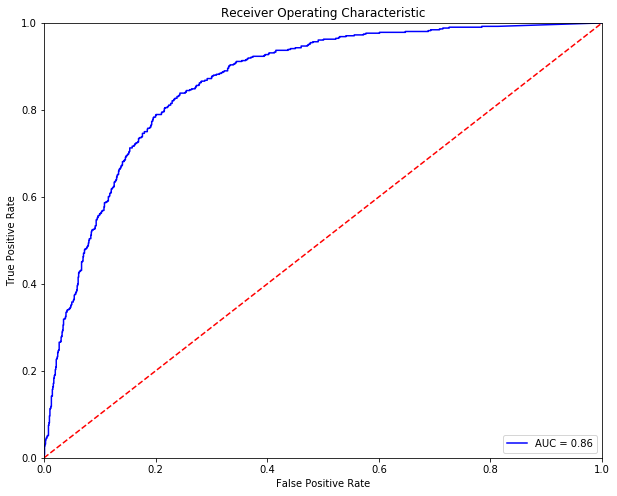

Optimal Threshold is 0.327979384477
Accuracy of Logistic Model on training data is: 0.790205562273


Predicted   0.0  1.0  __all__
Actual                       
0.0         906  240     1146
1.0         107  401      508
__all__    1013  641     1654

In [8]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [9]:
table_80_70_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [10]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5       100  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.799879081016

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3751   892     4643
1           432  1541     1973
__all__    4183  2433     6616

Accuracy of the  Logistic  model for test data is: 0.79746070133

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           926  220     1146
1           115  393      508
__all__    1041  613     1654

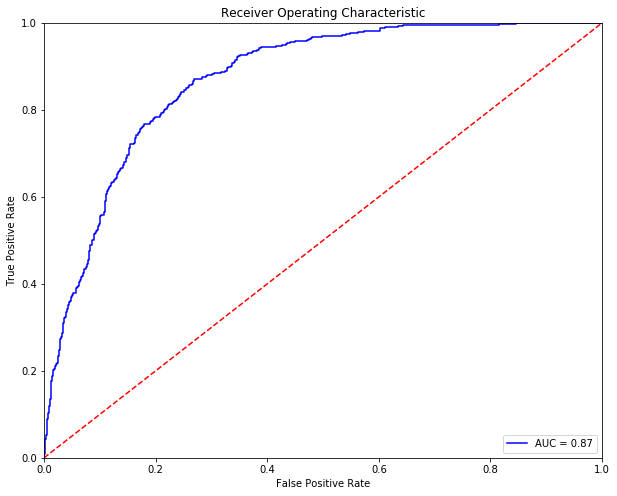

Optimal Threshold is 0.47948285364
Accuracy of Logistic Model on training data is: 0.790810157195


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  239     1146
1.0         107  401      508
__all__    1014  640     1654

In [11]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [12]:
table_80_70_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [13]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.807587666264

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3852   791     4643
1           482  1491     1973
__all__    4334  2282     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           949  197     1146
1           132  376      508
__all__    1081  573     1654

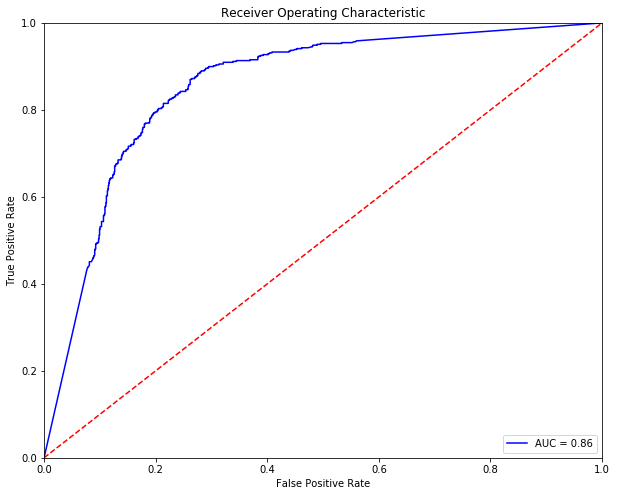

Optimal Threshold is 0.340085861062
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  232     1146
1.0         104  404      508
__all__    1018  636     1654

In [14]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [15]:
table_80_70_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

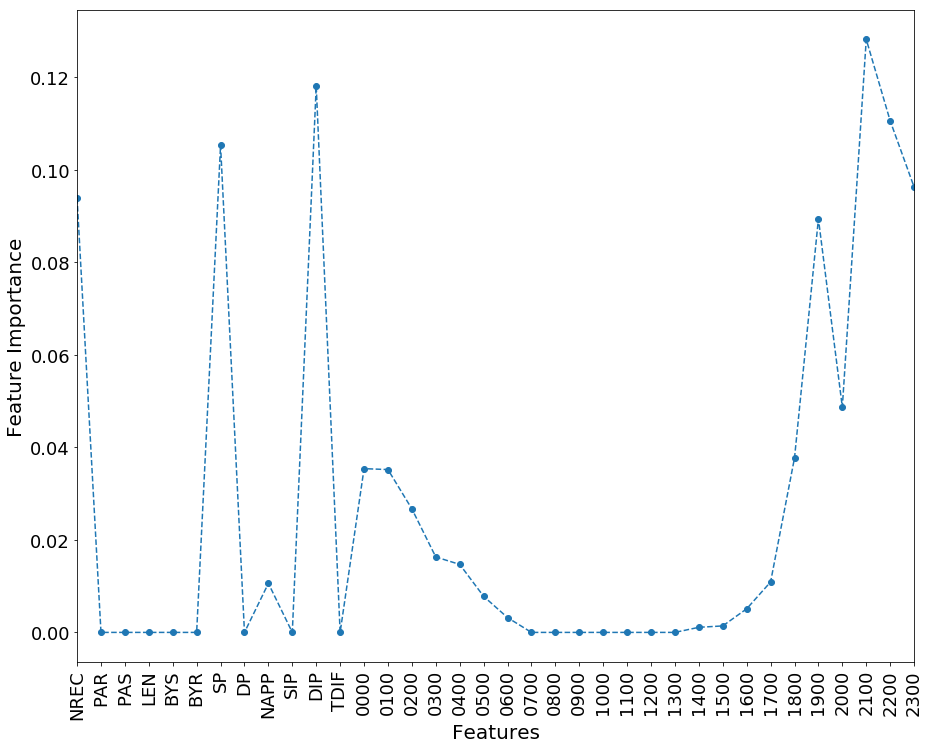

In [16]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [17]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.814087061669

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4009   634     4643
1           596  1377     1973
__all__    4605  2011     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.807134220073

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           986  160     1146
1           159  349      508
__all__    1145  509     1654

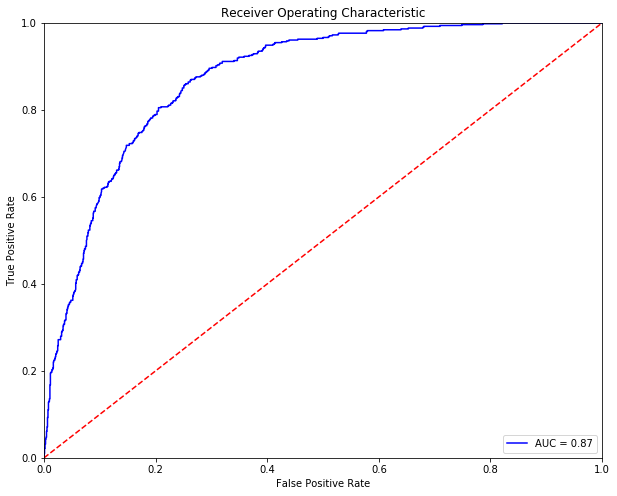

Optimal Threshold is 0.498636045028
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  232     1146
1.0         104  404      508
__all__    1018  636     1654

In [18]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [19]:
table_80_70_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

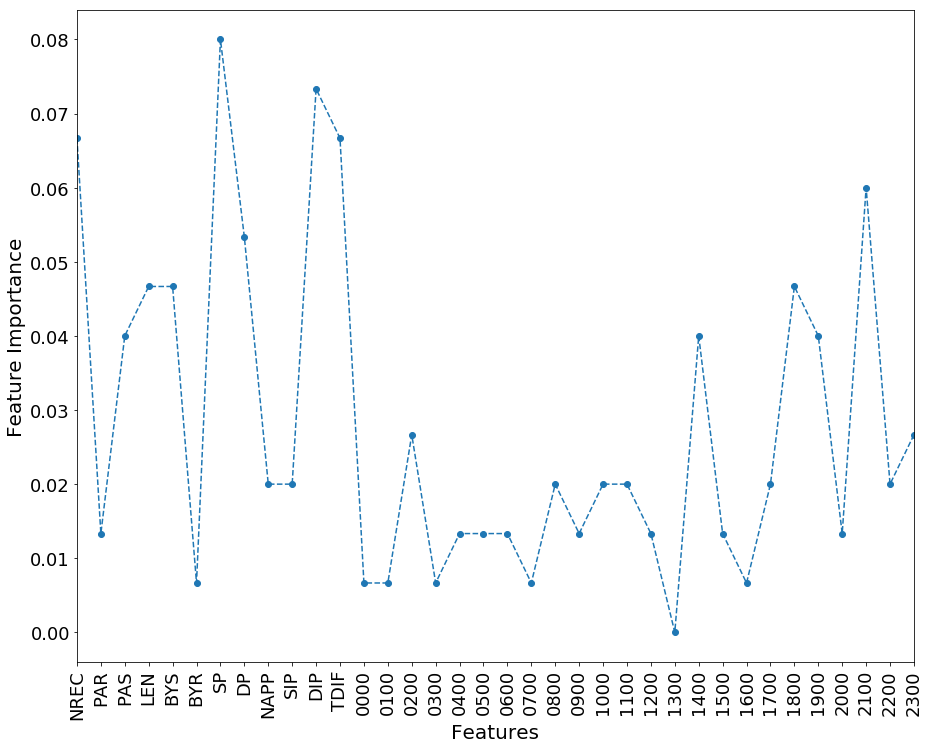

In [20]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [21]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.824365175333

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4047   596     4643
1           566  1407     1973
__all__    4613  2003     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.812575574365

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  150     1146
1           160  348      508
__all__    1156  498     1654

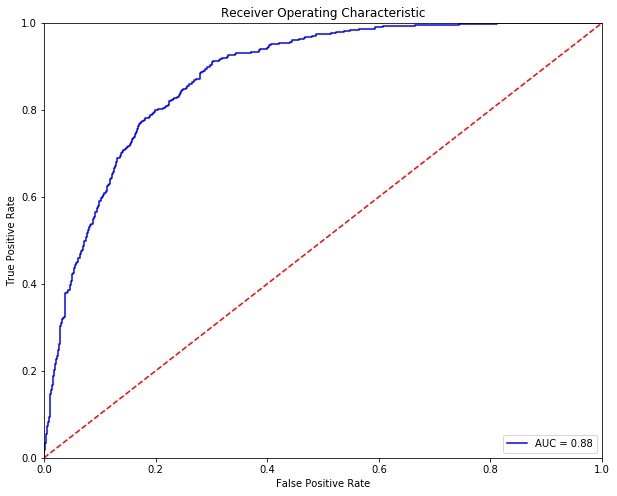

Optimal Threshold is 0.362099948659
Accuracy of Logistic Model on training data is: 0.799879081016


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  228     1146
1.0         103  405      508
__all__    1021  633     1654

In [22]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [23]:
table_80_70_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

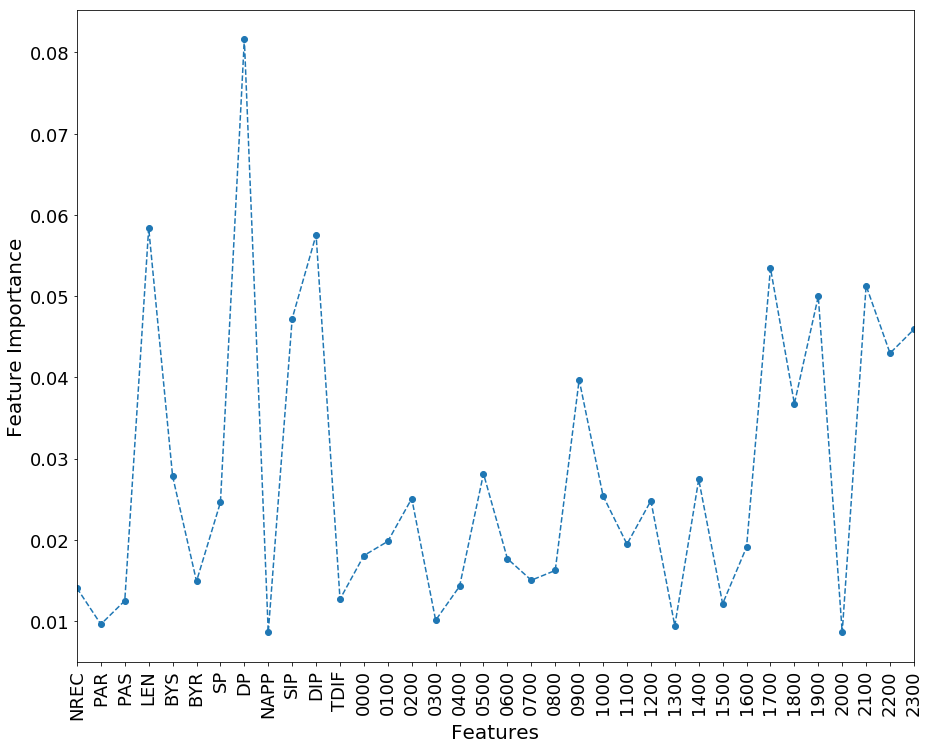

In [24]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [25]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808494558646

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3968   675     4643
1           592  1381     1973
__all__    4560  2056     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  158     1146
1           164  344      508
__all__    1152  502     1654

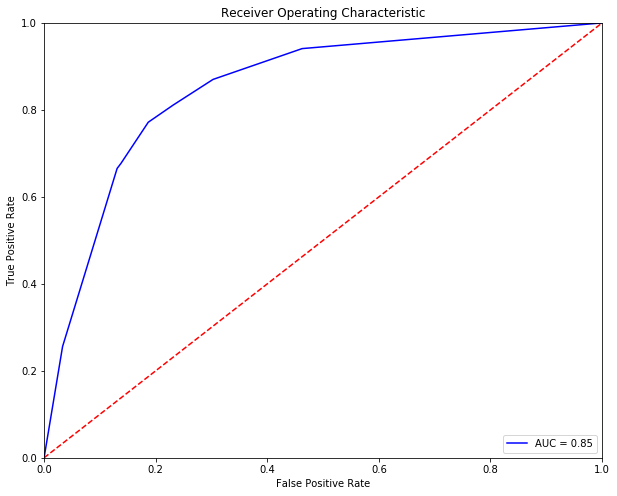

Optimal Threshold is 0.448453608247
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0         988  158     1146
1.0         164  344      508
__all__    1152  502     1654

In [26]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [27]:
table_80_70_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [28]:
%%capture
table_80_70_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

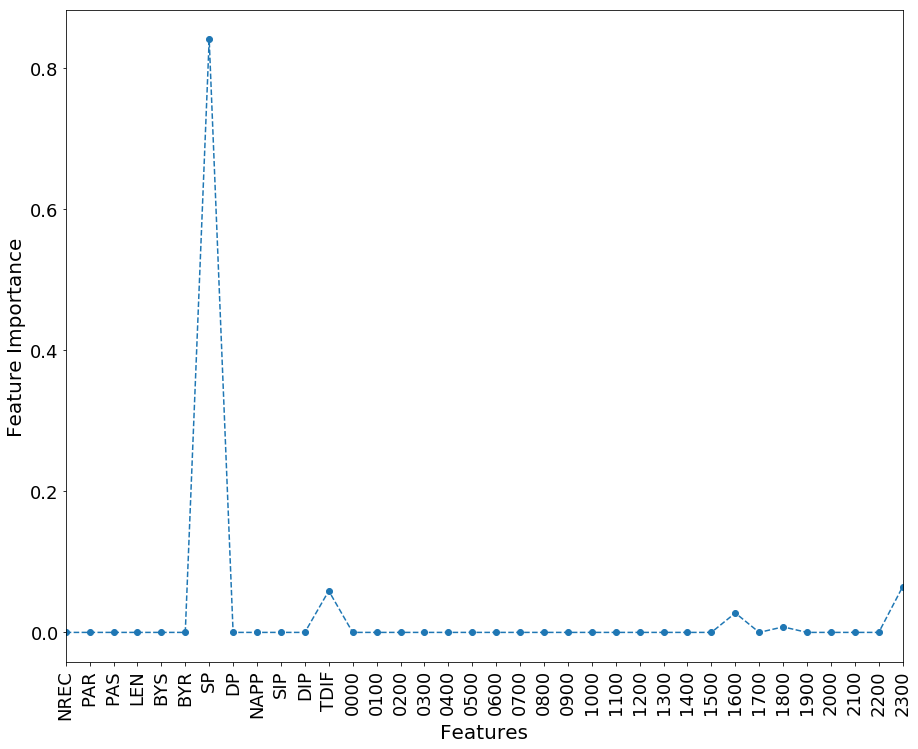

In [29]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [30]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.990931076179

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4640     3     4643
1            57  1916     1973
__all__    4697  1919     6616

Accuracy of the  Bagging  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  158     1146
1           154  354      508
__all__    1142  512     1654

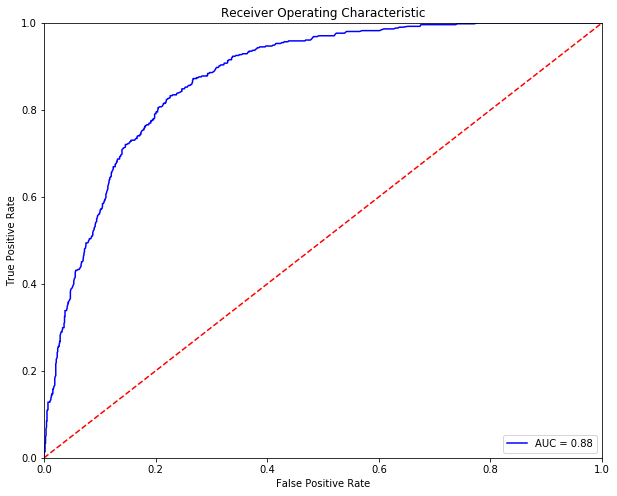

Optimal Threshold is 0.36
Accuracy of Logistic Model on training data is: 0.796251511487


Predicted   0.0  1.0  __all__
Actual                       
0.0         913  233     1146
1.0         104  404      508
__all__    1017  637     1654

In [31]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [32]:
table_80_70_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [33]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.933645707376


Predicted     0     1  __all__
Actual                        
0          4537   106     4643
1           333  1640     1973
__all__    4870  1746     6616

The test accuracy is: 0.796251511487


Predicted     0    1  __all__
Actual                       
0           992  154     1146
1           183  325      508
__all__    1175  479     1654

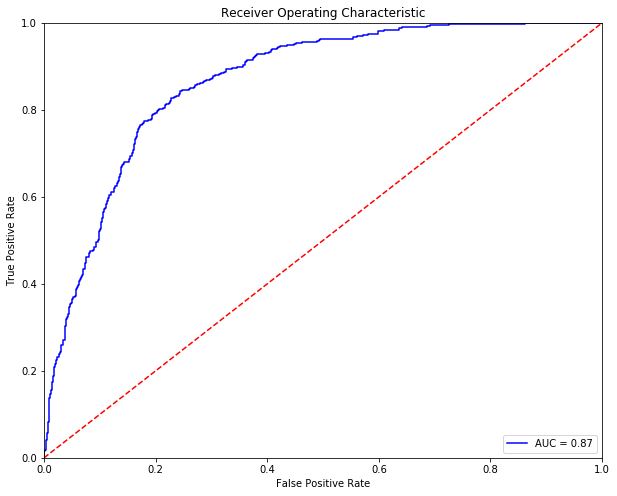

Optimal Threshold is 0.379334023078
Accuracy of Logistic Model on training data is: 0.79746070133


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  232     1146
1.0         103  405      508
__all__    1017  637     1654

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [35]:
table_80_70_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [36]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.925030229746


Predicted     0     1  __all__
Actual                        
0          4456   187     4643
1           309  1664     1973
__all__    4765  1851     6616

The accuracy of the model on test data is: 0.753929866989


Predicted     0    1  __all__
Actual                       
0           951  195     1146
1           212  296      508
__all__    1163  491     1654

  32/1654 [..............................] - ETA: 0s

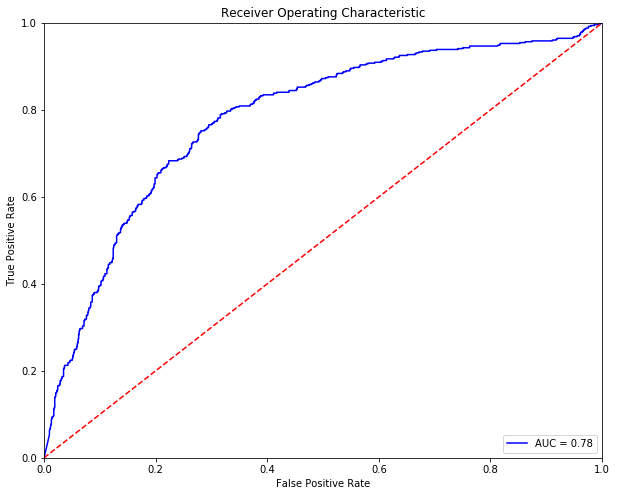

Optimal Threshold is 0.222119
Accuracy of Logistic Model on training data is: 0.726723095526


Predicted  0.0  1.0  __all__
Actual                      
0.0        833  313     1146
1.0        139  369      508
__all__    972  682     1654

In [37]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [38]:
table_80_70_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [39]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.5min finished


The accuracy of the model on training data is: 0.820888754534


Predicted     0     1  __all__
Actual                        
0          3953   690     4643
1           495  1478     1973
__all__    4448  2168     6616

The accuracy of the model on test data is: 0.80592503023


Predicted     0    1  __all__
Actual                       
0           969  177     1146
1           144  364      508
__all__    1113  541     1654

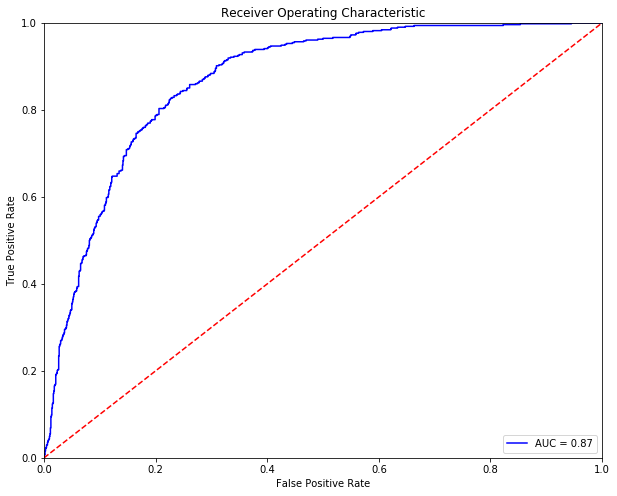

Optimal Threshold is 0.368492
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0         911  235     1146
1.0         107  401      508
__all__    1018  636     1654

In [40]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [41]:
table_80_70_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [42]:
table_80_70_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)
table_80_70_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1973.0  4643.0    0.0    0.0  0.000000   
LogisticRegression          0.799879  1541.0  3751.0  892.0  432.0  0.192117   
RandomForestClassifier      0.807588  1491.0  3852.0  791.0  482.0  0.170364   
AdaBoostClassifier          0.814087  1377.0  4009.0  634.0  596.0  0.136550   
GradientBoostingClassifier  0.824365  1407.0  4047.0  596.0  566.0  0.128365   
ExtraTreeClassifier         0.808495  1381.0  3968.0  675.0  592.0  0.145380   
BaggingClassifier           0.990931  1916.0  4640.0    3.0   57.0  0.000646   
VotingClassifier            0.933646  1640.0  4537.0  106.0  333.0  0.022830   
Neural Network-1            0.925030  1664.0  4456.0  187.0  309.0  0.040276   
Neural-Network-2            0.820889  1478.0  3953.0  690.0  495.0  0.148611   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.218956  
RandomForestClassifier      0.244298  
AdaBoostClassifier          0.302078  
GradientBoostingClassifier  0.286873  
ExtraTreeClassifier         0.300051  
BaggingClassifier           0.028890  
VotingClassifier            0.168779  
Neural Network-1            0.156614  
Neural-Network-2            0.250887

Comparision Table for Test Accuracies:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.800484  328.0  996.0  150.0  180.0  0.130890   
LogisticRegression          0.797461  393.0  926.0  220.0  115.0  0.191972   
RandomForestClassifier      0.801088  376.0  949.0  197.0  132.0  0.171902   
AdaBoostClassifier          0.807134  349.0  986.0  160.0  159.0  0.139616   
GradientBoostingClassifier  0.812576  348.0  996.0  150.0  160.0  0.130890   
ExtraTreeClassifier         0.805320  344.0  988.0  158.0  164.0  0.137871   
BaggingClassifier           0.811366  354.0  988.0  158.0  154.0  0.137871   
VotingClassifier            0.796252  325.0  992.0  154.0  183.0  0.134380   
Neural Network-1            0.753930  296.0  951.0  195.0  212.0  0.170157   
Neural-Network-2            0.805925  364.0  969.0  177.0  144.0  0.154450   

                                 FNR  
index                                 
KNeighborsClassifier        0.354331  
LogisticRegression          0.226378  
RandomForestClassifier      0.259843  
AdaBoostClassifier          0.312992  
GradientBoostingClassifier  0.314961  
ExtraTreeClassifier         0.322835  
BaggingClassifier           0.303150  
VotingClassifier            0.360236  
Neural Network-1            0.417323  
Neural-Network-2            0.283465

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.790206  401.0  906.0  240.0  107.0  0.209424   
LogisticRegression          0.790810  401.0  907.0  239.0  107.0  0.208551   
RandomForestClassifier      0.796856  404.0  914.0  232.0  104.0  0.202443   
AdaBoostClassifier          0.796856  404.0  914.0  232.0  104.0  0.202443   
GradientBoostingClassifier  0.799879  405.0  918.0  228.0  103.0  0.198953   
ExtraTreeClassifier         0.805320  344.0  988.0  158.0  164.0  0.137871   
BaggingClassifier           0.796252  404.0  913.0  233.0  104.0  0.203316   
VotingClassifier            0.797461  405.0  914.0  232.0  103.0  0.202443   
Neural Network-1            0.726723  369.0  833.0  313.0  139.0  0.273124   
Neural-Network-2            0.793229  401.0  911.0  235.0  107.0  0.205061   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.210630   0.327979  0.864256  
LogisticRegression          0.210630   0.479483  0.870132  
RandomForestClassifier      0.204724   0.340086  0.855453  
AdaBoostClassifier          0.204724   0.498636  0.874723  
GradientBoostingClassifier  0.202756   0.362100  0.878697  
ExtraTreeClassifier         0.322835   0.448454  0.850954  
BaggingClassifier           0.204724   0.360000  0.875368  
VotingClassifier            0.202756   0.379334  0.865594  
Neural Network-1            0.273622   0.222119  0.780780  
Neural-Network-2            0.210630   0.368492  0.869274

#### Random State 10

In [43]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

In [44]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

In [45]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [46]:
## Table to store training and test measures
table_80_70_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4647     0     4647
1             0  1969     1969
__all__    4647  1969     6616

Accuracy of the  KNN  model for test data is: 0.809552599758

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           988  154     1142
1           161  351      512
__all__    1149  505     1654

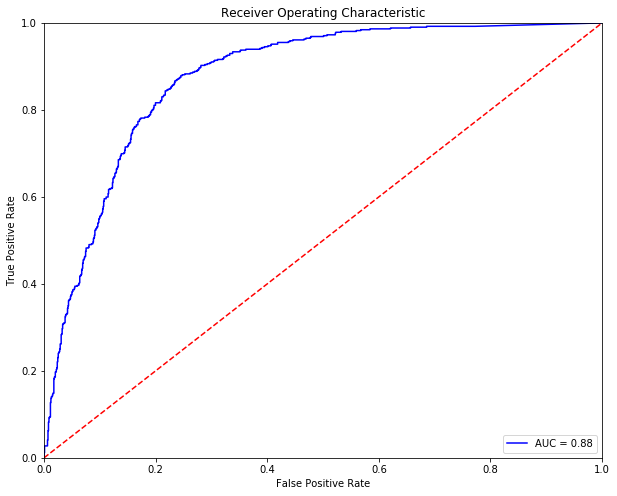

Optimal Threshold is 0.361130302069
Accuracy of Logistic Model on training data is: 0.803506650544


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         101  411      512
__all__    1019  635     1654

In [48]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [49]:
table_80_70_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [50]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False           True                0.7        50  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.799274486094

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4106   541     4647
1           787  1182     1969
__all__    4893  1723     6616

Accuracy of the  Logistic  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1011  131     1142
1           197  315      512
__all__    1208  446     1654

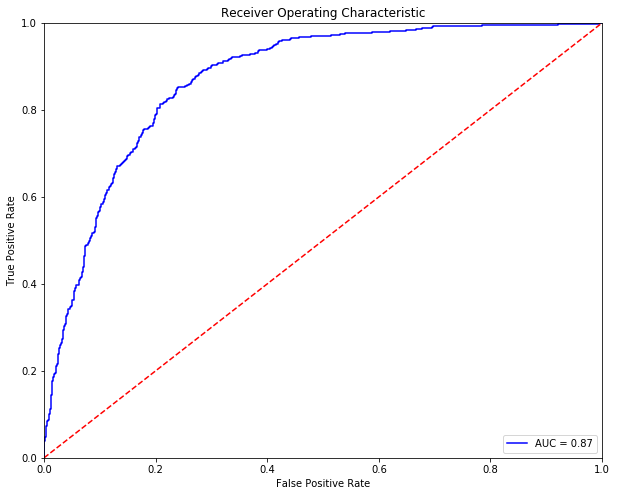

Optimal Threshold is 0.410512750798
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         911  231     1142
1.0         105  407      512
__all__    1016  638     1654

In [51]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [52]:
table_80_70_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [53]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.799879081016

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3830   817     4647
1           507  1462     1969
__all__    4337  2279     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.808343409915

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           936  206     1142
1           111  401      512
__all__    1047  607     1654

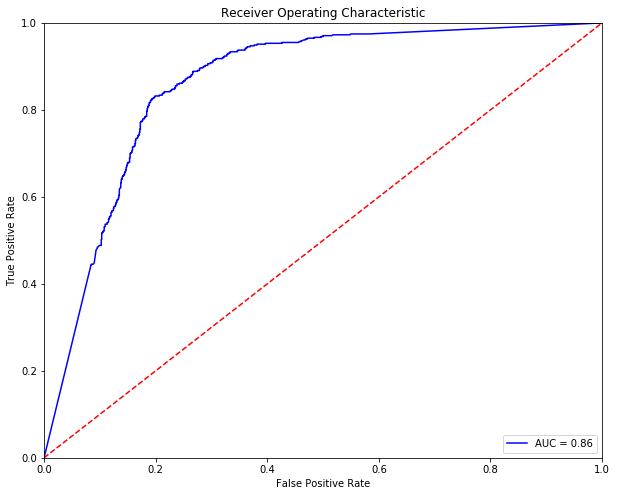

Optimal Threshold is 0.464083926809
Accuracy of Logistic Model on training data is: 0.811970979444


Predicted   0.0  1.0  __all__
Actual                       
0.0         928  214     1142
1.0          97  415      512
__all__    1025  629     1654

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [55]:
table_80_70_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

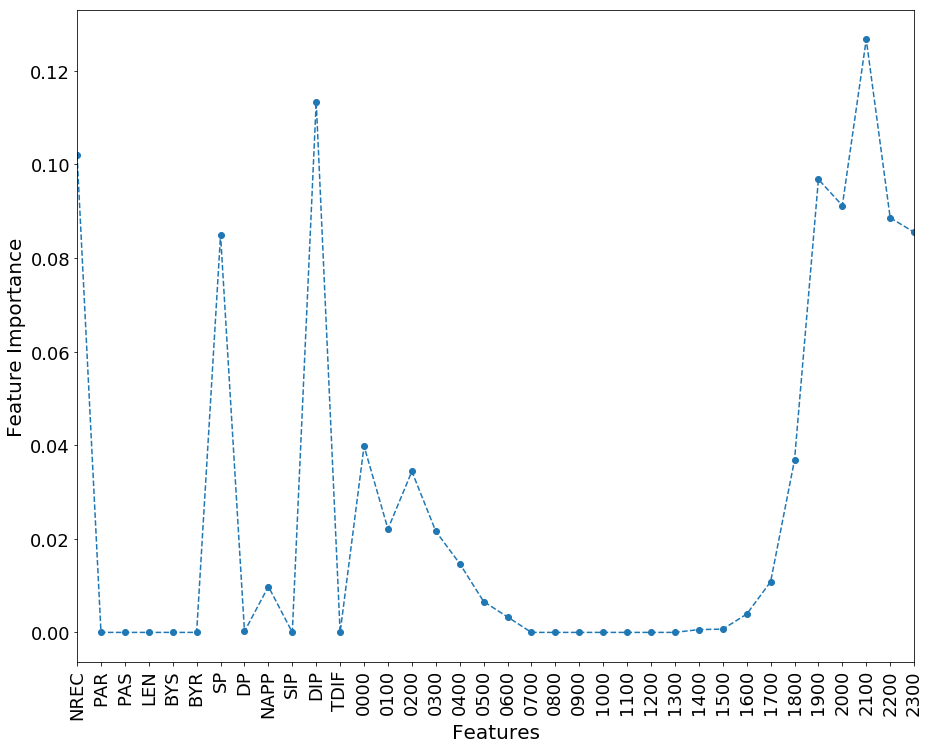

In [56]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [57]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.803960096735

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3976   671     4647
1           626  1343     1969
__all__    4602  2014     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.804111245466

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           972  170     1142
1           154  358      512
__all__    1126  528     1654

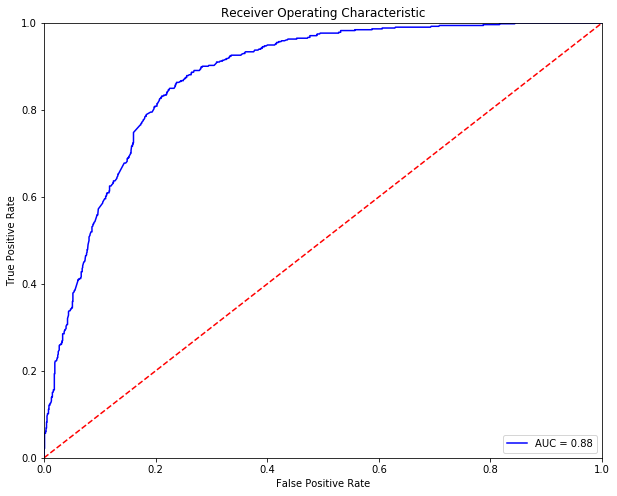

Optimal Threshold is 0.494776988413
Accuracy of Logistic Model on training data is: 0.802902055623


Predicted   0.0  1.0  __all__
Actual                       
0.0         921  221     1142
1.0         105  407      512
__all__    1026  628     1654

In [58]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [59]:
table_80_70_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

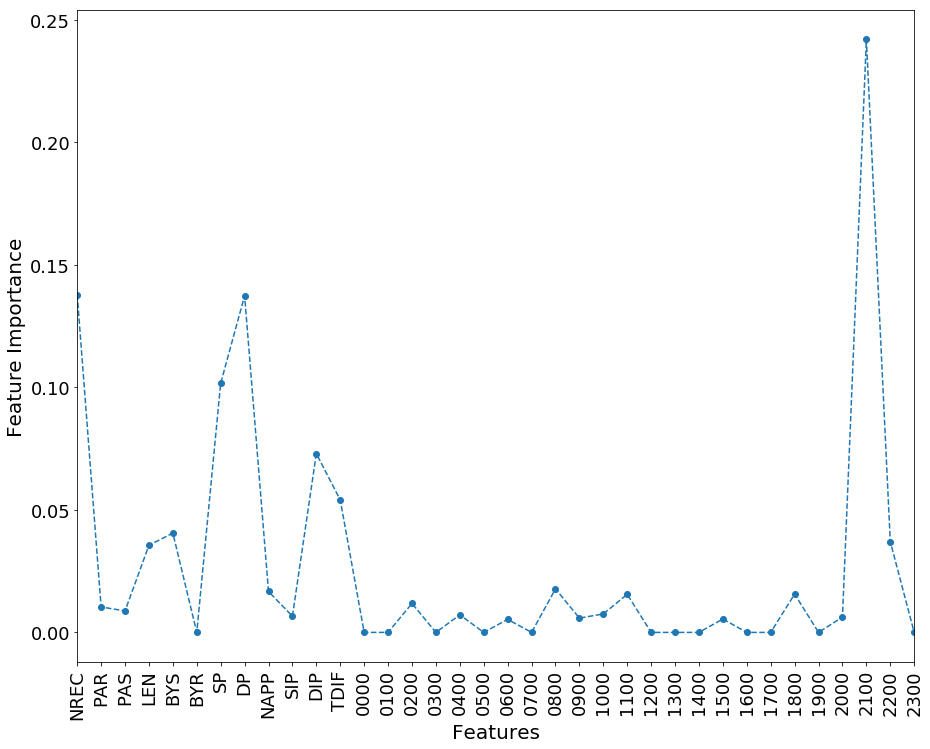

In [60]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [61]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.812575574365

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3984   663     4647
1           577  1392     1969
__all__    4561  2055     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           965  177     1142
1           141  371      512
__all__    1106  548     1654

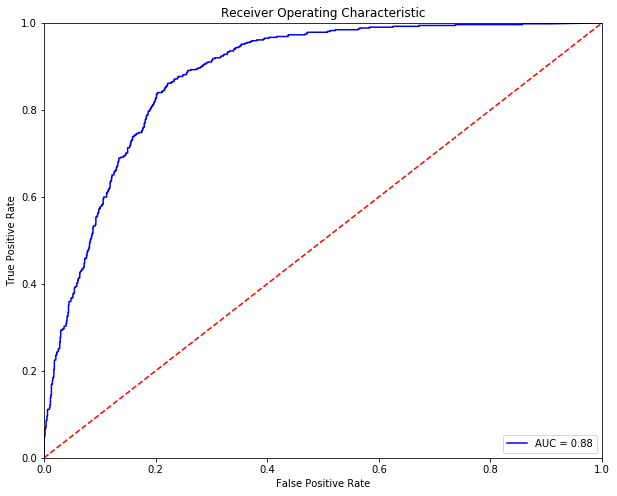

Optimal Threshold is 0.414849524422
Accuracy of Logistic Model on training data is: 0.807134220073


Predicted   0.0  1.0  __all__
Actual                       
0.0         922  220     1142
1.0          99  413      512
__all__    1021  633     1654

In [62]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [63]:
table_80_70_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

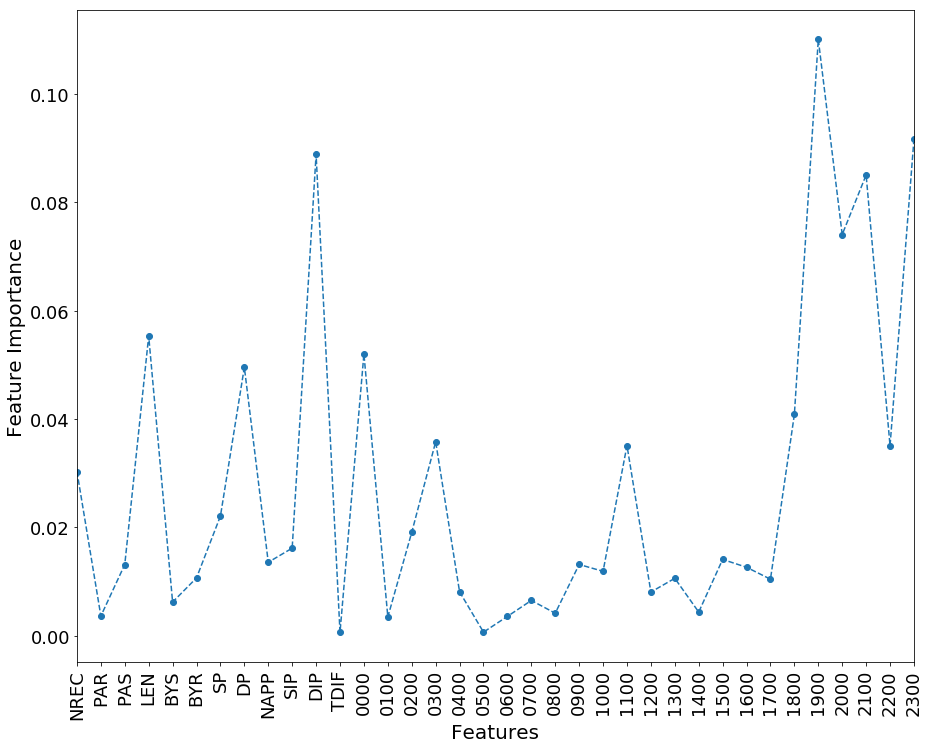

In [64]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [65]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808192261185

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3984   663     4647
1           606  1363     1969
__all__    4590  2026     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.790205562273

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           951  191     1142
1           156  356      512
__all__    1107  547     1654

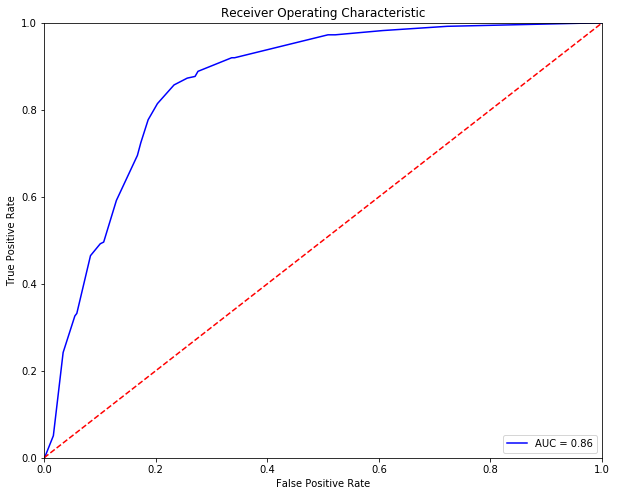

Optimal Threshold is 0.40414507772
Accuracy of Logistic Model on training data is: 0.802297460701


Predicted   0.0  1.0  __all__
Actual                       
0.0         929  213     1142
1.0         114  398      512
__all__    1043  611     1654

In [66]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [67]:
table_80_70_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [68]:
%%capture
table_80_70_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

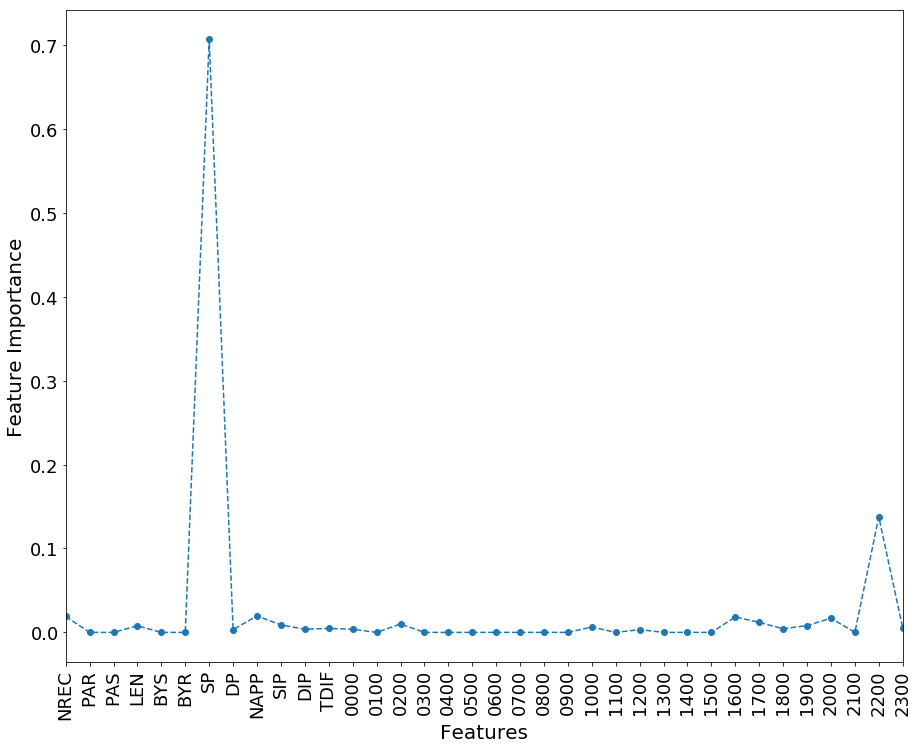

In [69]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [70]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.3          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.953899637243

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4575    72     4647
1           233  1736     1969
__all__    4808  1808     6616

Accuracy of the  Bagging  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           962  180     1142
1           134  378      512
__all__    1096  558     1654

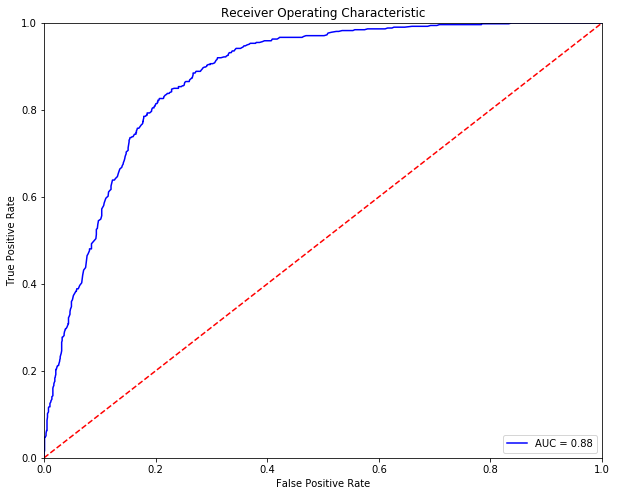

Optimal Threshold is 0.426
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0         920  222     1142
1.0         100  412      512
__all__    1020  634     1654

In [71]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [72]:
table_80_70_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [73]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936517533253


Predicted     0     1  __all__
Actual                        
0          4567    80     4647
1           340  1629     1969
__all__    4907  1709     6616

The test accuracy is: 0.789600967352


Predicted     0    1  __all__
Actual                       
0           973  169     1142
1           179  333      512
__all__    1152  502     1654

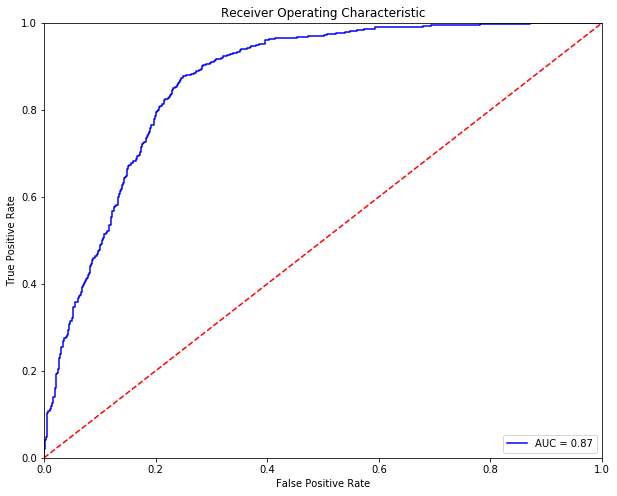

Optimal Threshold is 0.400545889187
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0         911  231     1142
1.0         105  407      512
__all__    1016  638     1654

In [74]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [75]:
table_80_70_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [76]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.926390568391


Predicted     0     1  __all__
Actual                        
0          4537   110     4647
1           377  1592     1969
__all__    4914  1702     6616

The accuracy of the model on test data is: 0.766021765417


Predicted     0    1  __all__
Actual                       
0           970  172     1142
1           215  297      512
__all__    1185  469     1654

  32/1654 [..............................] - ETA: 0s

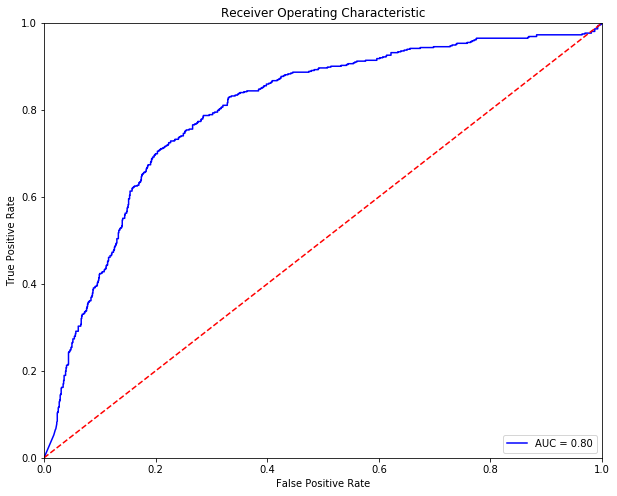

Optimal Threshold is 0.174893
Accuracy of Logistic Model on training data is: 0.747883917775


Predicted  0.0  1.0  __all__
Actual                      
0.0        855  287     1142
1.0        130  382      512
__all__    985  669     1654

In [77]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [78]:
table_80_70_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [79]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.1min finished


The accuracy of the model on training data is: 0.820284159613


Predicted     0     1  __all__
Actual                        
0          3956   691     4647
1           498  1471     1969
__all__    4454  2162     6616

The accuracy of the model on test data is: 0.802297460701


Predicted     0    1  __all__
Actual                       
0           943  199     1142
1           128  384      512
__all__    1071  583     1654

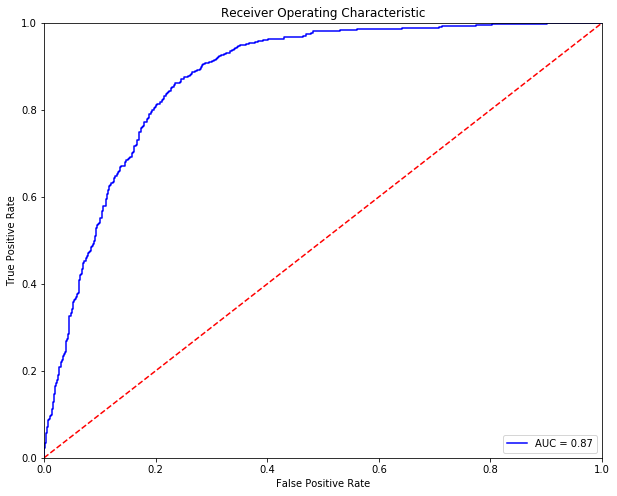

Optimal Threshold is 0.390337
Accuracy of Logistic Model on training data is: 0.802902055623


Predicted   0.0  1.0  __all__
Actual                       
0.0         917  225     1142
1.0         101  411      512
__all__    1018  636     1654

In [80]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [81]:
table_80_70_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [82]:
table_80_70_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_10_test.set_index(['index'],drop=True,inplace=True)
table_80_70_10_train.set_index(['index'],drop=True,inplace=True)
table_80_70_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1969.0  4647.0    0.0    0.0  0.000000   
LogisticRegression          0.799274  1182.0  4106.0  541.0  787.0  0.116419   
RandomForestClassifier      0.799879  1462.0  3830.0  817.0  507.0  0.175812   
AdaBoostClassifier          0.803960  1343.0  3976.0  671.0  626.0  0.144394   
GradientBoostingClassifier  0.812576  1392.0  3984.0  663.0  577.0  0.142673   
ExtraTreeClassifier         0.808192  1363.0  3984.0  663.0  606.0  0.142673   
BaggingClassifier           0.953900  1736.0  4575.0   72.0  233.0  0.015494   
VotingClassifier            0.936518  1629.0  4567.0   80.0  340.0  0.017215   
Neural Network-1            0.926391  1592.0  4537.0  110.0  377.0  0.023671   
Neural-Network-2            0.820284  1471.0  3956.0  691.0  498.0  0.148698   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.399695  
RandomForestClassifier      0.257491  
AdaBoostClassifier          0.317928  
GradientBoostingClassifier  0.293042  
ExtraTreeClassifier         0.307770  
BaggingClassifier           0.118334  
VotingClassifier            0.172676  
Neural Network-1            0.191468  
Neural-Network-2            0.252920

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.809553  351.0   988.0  154.0  161.0  0.134851   
LogisticRegression          0.801693  315.0  1011.0  131.0  197.0  0.114711   
RandomForestClassifier      0.808343  401.0   936.0  206.0  111.0  0.180385   
AdaBoostClassifier          0.804111  358.0   972.0  170.0  154.0  0.148862   
GradientBoostingClassifier  0.807739  371.0   965.0  177.0  141.0  0.154991   
ExtraTreeClassifier         0.790206  356.0   951.0  191.0  156.0  0.167250   
BaggingClassifier           0.810157  378.0   962.0  180.0  134.0  0.157618   
VotingClassifier            0.789601  333.0   973.0  169.0  179.0  0.147986   
Neural Network-1            0.766022  297.0   970.0  172.0  215.0  0.150613   
Neural-Network-2            0.802297  384.0   943.0  199.0  128.0  0.174256   

                                 FNR  
index                                 
KNeighborsClassifier        0.314453  
LogisticRegression          0.384766  
RandomForestClassifier      0.216797  
AdaBoostClassifier          0.300781  
GradientBoostingClassifier  0.275391  
ExtraTreeClassifier         0.304688  
BaggingClassifier           0.261719  
VotingClassifier            0.349609  
Neural Network-1            0.419922  
Neural-Network-2            0.250000

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.803507  411.0  918.0  224.0  101.0  0.196147   
LogisticRegression          0.796856  407.0  911.0  231.0  105.0  0.202277   
RandomForestClassifier      0.811971  415.0  928.0  214.0   97.0  0.187391   
AdaBoostClassifier          0.802902  407.0  921.0  221.0  105.0  0.193520   
GradientBoostingClassifier  0.807134  413.0  922.0  220.0   99.0  0.192644   
ExtraTreeClassifier         0.802297  398.0  929.0  213.0  114.0  0.186515   
BaggingClassifier           0.805320  412.0  920.0  222.0  100.0  0.194396   
VotingClassifier            0.796856  407.0  911.0  231.0  105.0  0.202277   
Neural Network-1            0.747884  382.0  855.0  287.0  130.0  0.251313   
Neural-Network-2            0.802902  411.0  917.0  225.0  101.0  0.197023   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.197266   0.361130  0.876199  
LogisticRegression          0.205078   0.410513  0.871148  
RandomForestClassifier      0.189453   0.464084  0.861933  
AdaBoostClassifier          0.205078   0.494777  0.876284  
GradientBoostingClassifier  0.193359   0.414850  0.881593  
ExtraTreeClassifier         0.222656   0.404145  0.861798  
BaggingClassifier           0.195312   0.426000  0.876496  
VotingClassifier            0.205078   0.400546  0.867353  
Neural Network-1            0.253906   0.174893  0.799227  
Neural-Network-2            0.197266   0.390337  0.874504

#### Random State 20

In [83]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

In [84]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

In [85]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [86]:
## Table to store training and test measures
table_80_70_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4632     0     4632
1             0  1984     1984
__all__    4632  1984     6616

Accuracy of the  KNN  model for test data is: 0.813180169287

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1018  139     1157
1           170  327      497
__all__    1188  466     1654

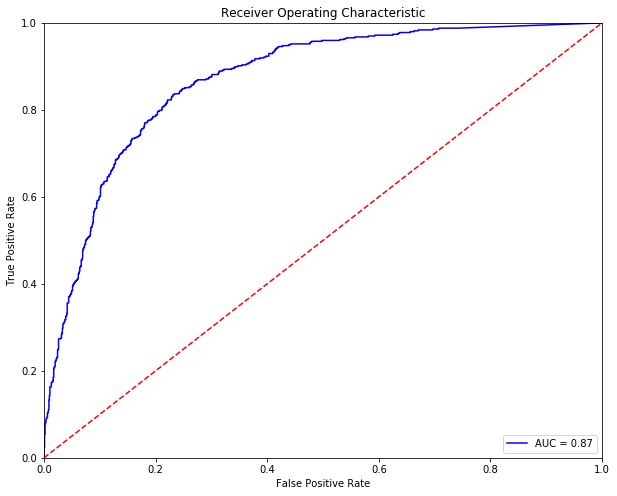

Optimal Threshold is 0.336884654846
Accuracy of Logistic Model on training data is: 0.795646916566


Predicted   0.0  1.0  __all__
Actual                       
0.0         921  236     1157
1.0         102  395      497
__all__    1023  631     1654

In [88]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [89]:
table_80_70_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [90]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False          False                0.7        50  multinomial   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.798065296252

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3737   895     4632
1           441  1543     1984
__all__    4178  2438     6616

Accuracy of the  Logistic  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           939  218     1157
1           111  386      497
__all__    1050  604     1654

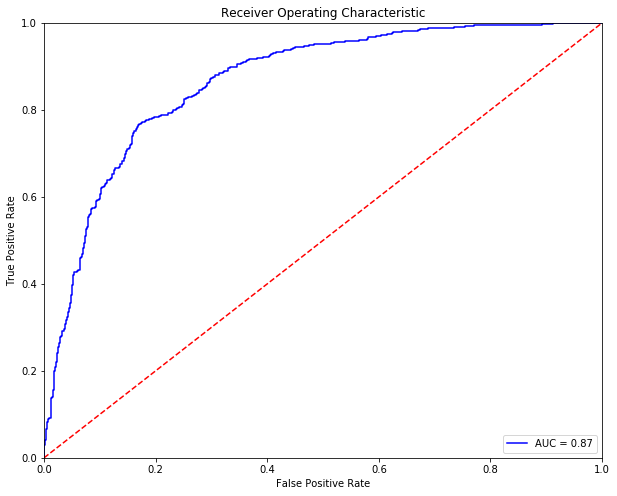

Optimal Threshold is 0.482061873305
Accuracy of Logistic Model on training data is: 0.78899637243


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  243     1157
1.0         106  391      497
__all__    1020  634     1654

In [91]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [92]:
table_80_70_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [93]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.800483675937

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3795   837     4632
1           483  1501     1984
__all__    4278  2338     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.804715840387

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           955  202     1157
1           121  376      497
__all__    1076  578     1654

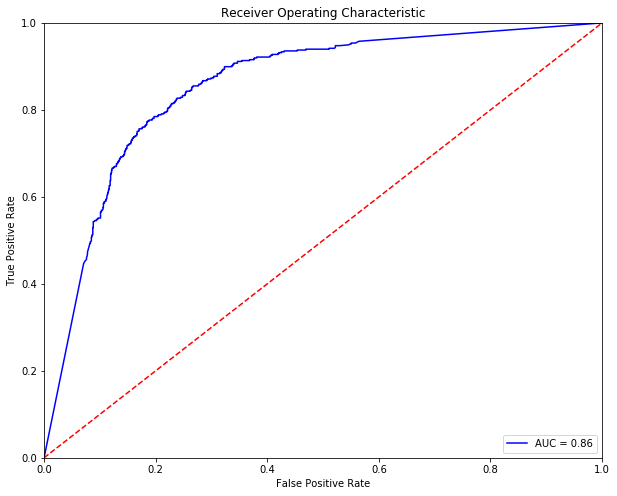

Optimal Threshold is 0.363405458772
Accuracy of Logistic Model on training data is: 0.789600967352


Predicted   0.0  1.0  __all__
Actual                       
0.0         914  243     1157
1.0         105  392      497
__all__    1019  635     1654

In [94]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [95]:
table_80_70_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

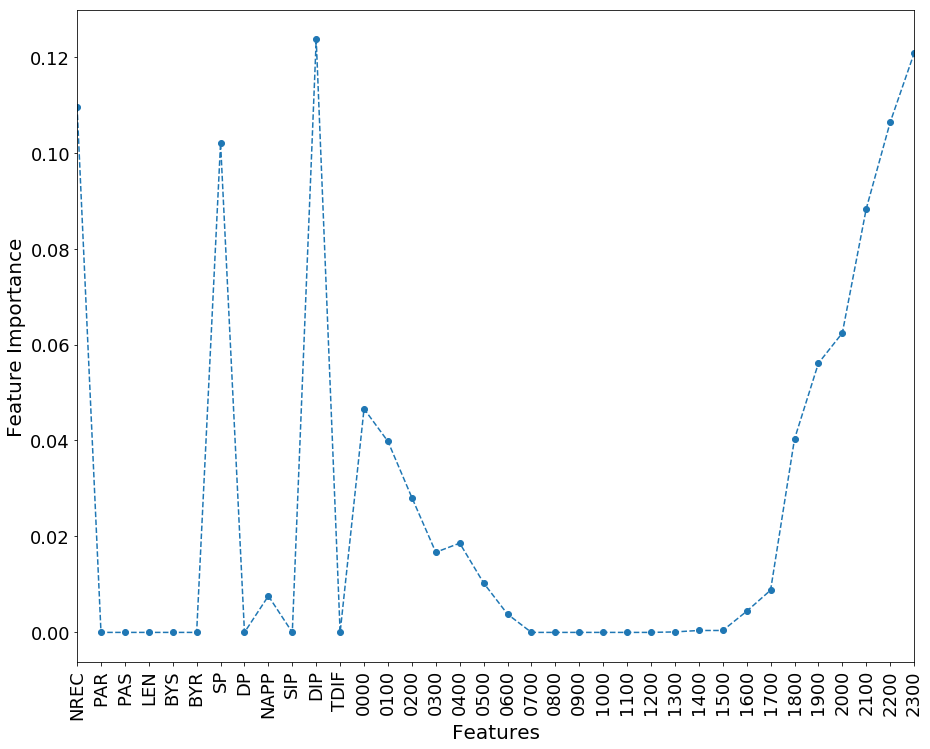

In [96]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [97]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.805018137848

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3965   667     4632
1           623  1361     1984
__all__    4588  2028     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.816203143894

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1003  154     1157
1           150  347      497
__all__    1153  501     1654

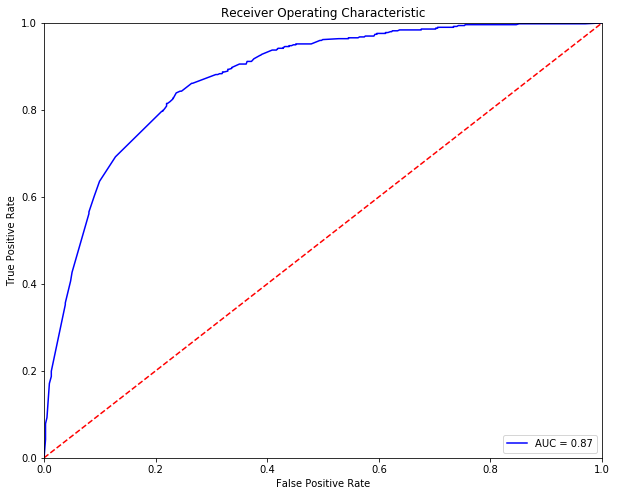

Optimal Threshold is 0.498020836779
Accuracy of Logistic Model on training data is: 0.818016928658


Predicted   0.0  1.0  __all__
Actual                       
0.0        1009  148     1157
1.0         153  344      497
__all__    1162  492     1654

In [98]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [99]:
table_80_70_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

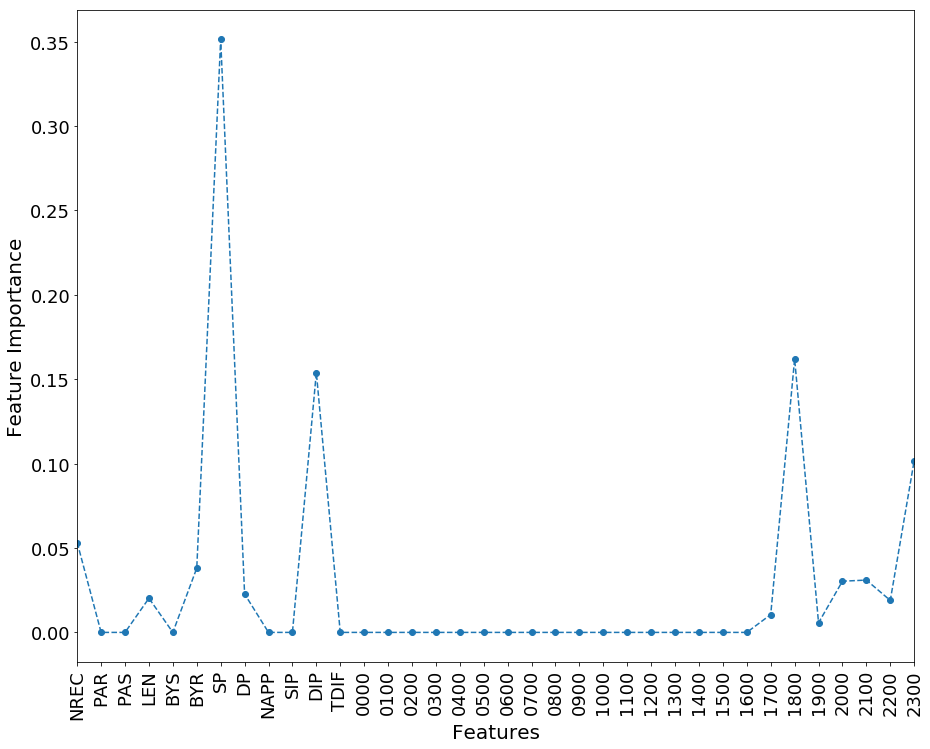

In [100]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [101]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2            50             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.806983071342

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3955   677     4632
1           600  1384     1984
__all__    4555  2061     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           991  166     1157
1           152  345      497
__all__    1143  511     1654

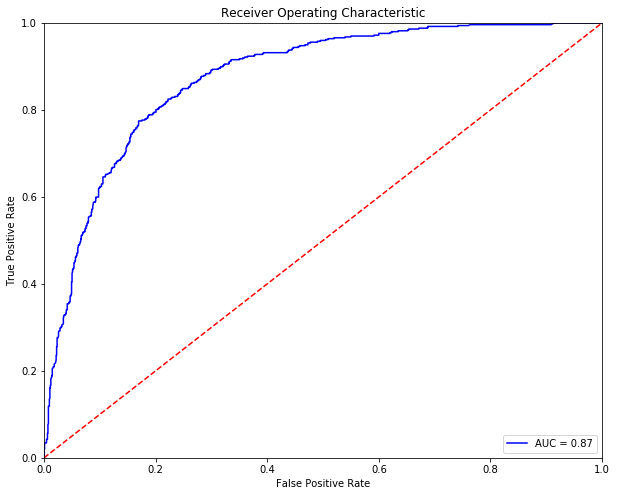

Optimal Threshold is 0.37340777921
Accuracy of Logistic Model on training data is: 0.799274486094


Predicted   0.0  1.0  __all__
Actual                       
0.0         925  232     1157
1.0         100  397      497
__all__    1025  629     1654

In [102]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [103]:
table_80_70_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

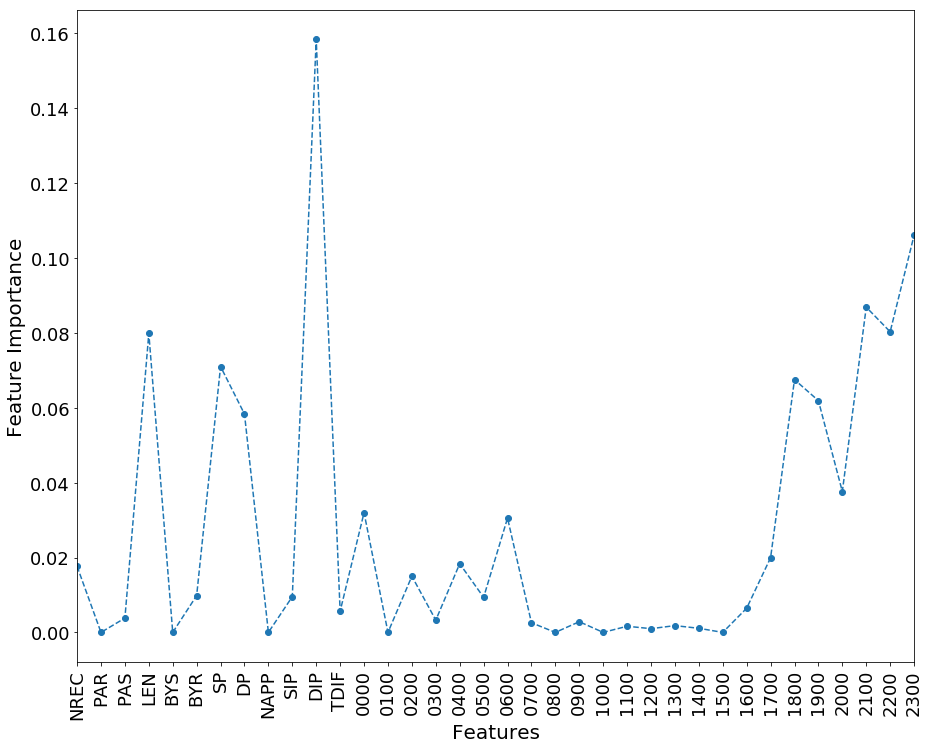

In [104]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [105]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.819981862152

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3989   643     4632
1           548  1436     1984
__all__    4537  2079     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.795646916566

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           981  176     1157
1           162  335      497
__all__    1143  511     1654

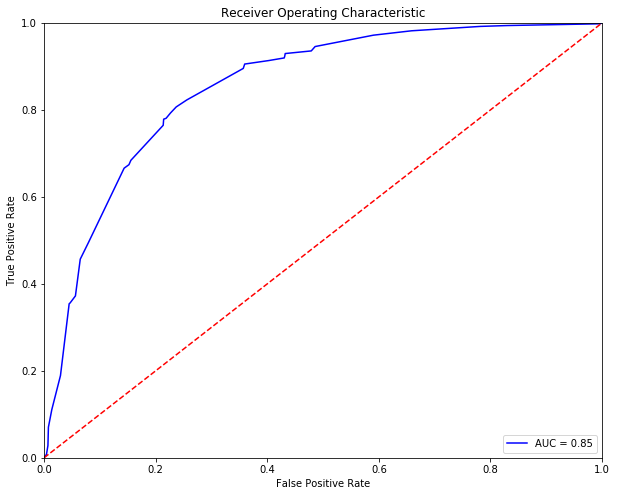

Optimal Threshold is 0.333333333333
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  248     1157
1.0         110  387      497
__all__    1019  635     1654

In [106]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [107]:
table_80_70_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [108]:
%%capture
table_80_70_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

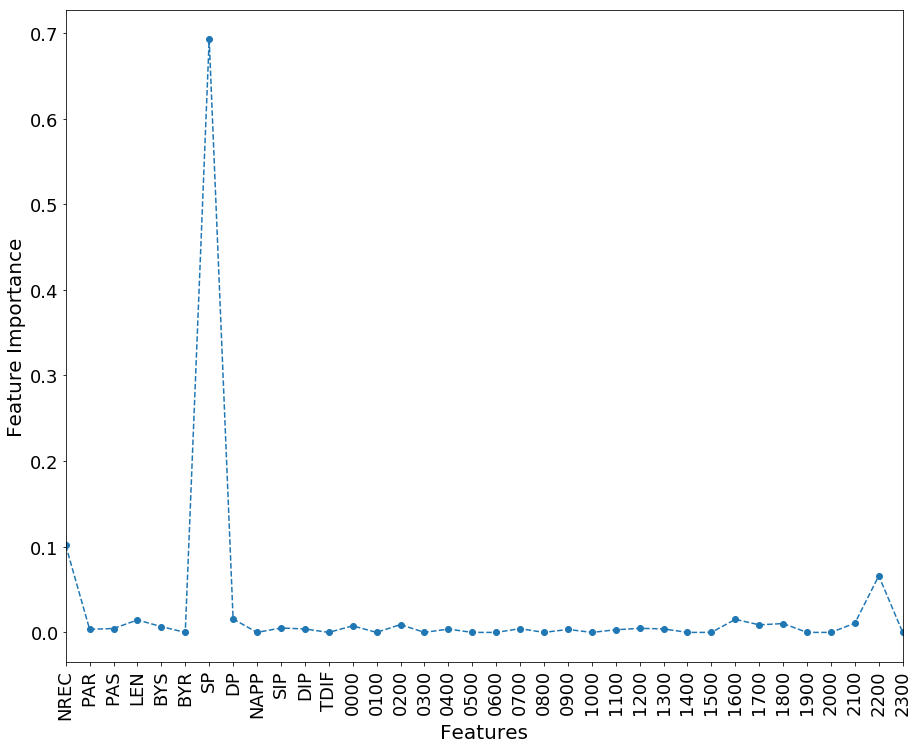

In [109]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [110]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.990931076179

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4630     2     4632
1            58  1926     1984
__all__    4688  1928     6616

Accuracy of the  Bagging  model for test data is: 0.810761789601

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           985  172     1157
1           141  356      497
__all__    1126  528     1654

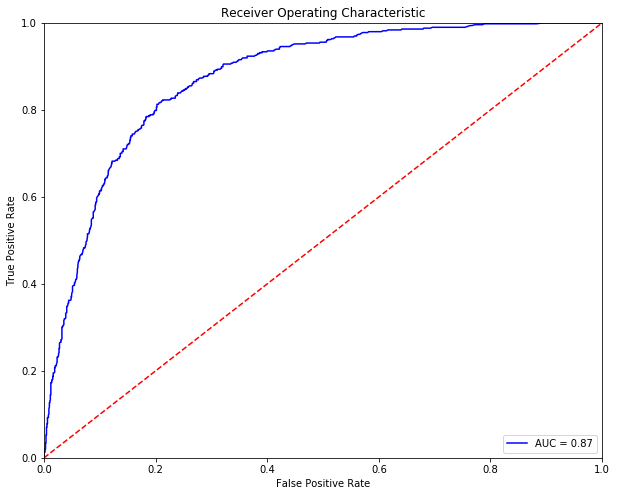

Optimal Threshold is 0.389333333333
Accuracy of Logistic Model on training data is: 0.799274486094


Predicted   0.0  1.0  __all__
Actual                       
0.0         925  232     1157
1.0         100  397      497
__all__    1025  629     1654

In [111]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [112]:
table_80_70_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [113]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936819830713


Predicted     0     1  __all__
Actual                        
0          4533    99     4632
1           319  1665     1984
__all__    4852  1764     6616

The test accuracy is: 0.813784764208


Predicted     0    1  __all__
Actual                       
0          1016  141     1157
1           167  330      497
__all__    1183  471     1654

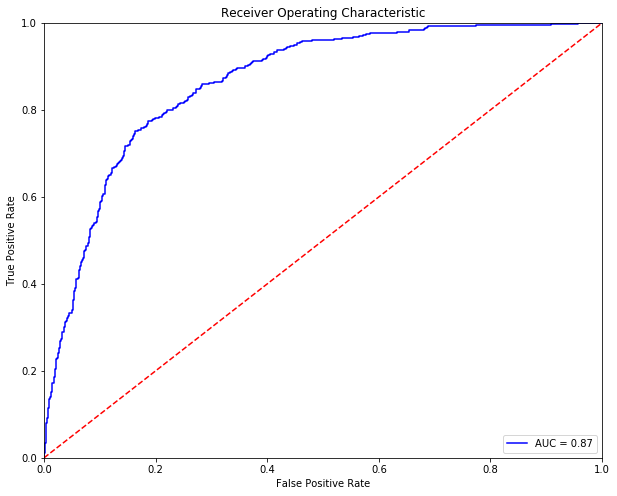

Optimal Threshold is 0.376694104679
Accuracy of Logistic Model on training data is: 0.788391777509


Predicted   0.0  1.0  __all__
Actual                       
0.0         913  244     1157
1.0         106  391      497
__all__    1019  635     1654

In [114]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [115]:
table_80_70_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [116]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.931076179032


Predicted     0     1  __all__
Actual                        
0          4513   119     4632
1           337  1647     1984
__all__    4850  1766     6616

The accuracy of the model on test data is: 0.780532043531


Predicted     0    1  __all__
Actual                       
0          1006  151     1157
1           212  285      497
__all__    1218  436     1654

  32/1654 [..............................] - ETA: 0s

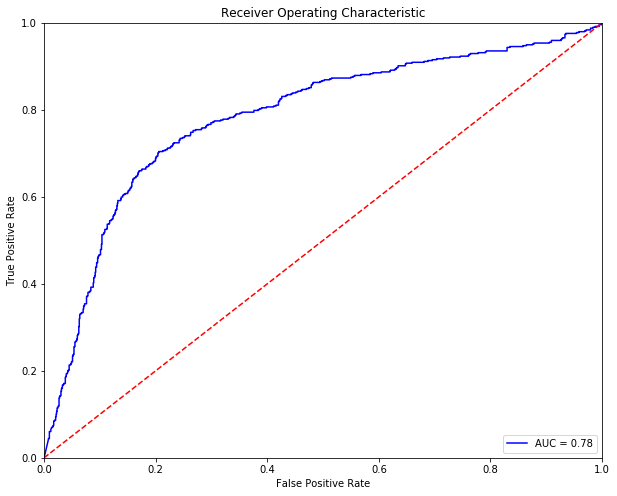

Optimal Threshold is 0.177605
Accuracy of Logistic Model on training data is: 0.739419588875


Predicted  0.0  1.0  __all__
Actual                      
0.0        855  302     1157
1.0        129  368      497
__all__    984  670     1654

In [117]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [118]:
table_80_70_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [119]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.6min finished


The accuracy of the model on training data is: 0.817110036276


Predicted     0     1  __all__
Actual                        
0          3950   682     4632
1           528  1456     1984
__all__    4478  2138     6616

The accuracy of the model on test data is: 0.802902055623


Predicted     0    1  __all__
Actual                       
0           974  183     1157
1           143  354      497
__all__    1117  537     1654

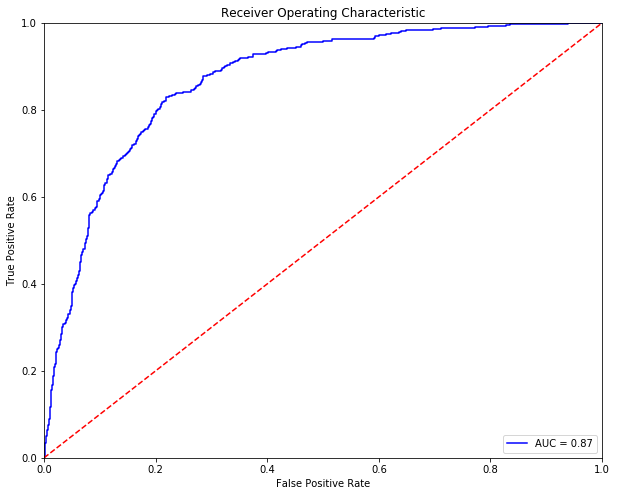

Optimal Threshold is 0.296417
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         924  233     1157
1.0         101  396      497
__all__    1025  629     1654

In [120]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [121]:
table_80_70_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [122]:
table_80_70_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_20_test.set_index(['index'],drop=True,inplace=True)
table_80_70_20_train.set_index(['index'],drop=True,inplace=True)
table_80_70_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1984.0  4632.0    0.0    0.0  0.000000   
LogisticRegression          0.798065  1543.0  3737.0  895.0  441.0  0.193221   
RandomForestClassifier      0.800484  1501.0  3795.0  837.0  483.0  0.180699   
AdaBoostClassifier          0.805018  1361.0  3965.0  667.0  623.0  0.143998   
GradientBoostingClassifier  0.806983  1384.0  3955.0  677.0  600.0  0.146157   
ExtraTreeClassifier         0.819982  1436.0  3989.0  643.0  548.0  0.138817   
BaggingClassifier           0.990931  1926.0  4630.0    2.0   58.0  0.000432   
VotingClassifier            0.936820  1665.0  4533.0   99.0  319.0  0.021373   
Neural Network-1            0.931076  1647.0  4513.0  119.0  337.0  0.025691   
Neural-Network-2            0.817110  1456.0  3950.0  682.0  528.0  0.147237   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.222278  
RandomForestClassifier      0.243448  
AdaBoostClassifier          0.314012  
GradientBoostingClassifier  0.302419  
ExtraTreeClassifier         0.276210  
BaggingClassifier           0.029234  
VotingClassifier            0.160786  
Neural Network-1            0.169859  
Neural-Network-2            0.266129

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.813180  327.0  1018.0  139.0  170.0  0.120138   
LogisticRegression          0.801088  386.0   939.0  218.0  111.0  0.188418   
RandomForestClassifier      0.804716  376.0   955.0  202.0  121.0  0.174589   
AdaBoostClassifier          0.816203  347.0  1003.0  154.0  150.0  0.133103   
GradientBoostingClassifier  0.807739  345.0   991.0  166.0  152.0  0.143475   
ExtraTreeClassifier         0.795647  335.0   981.0  176.0  162.0  0.152118   
BaggingClassifier           0.810762  356.0   985.0  172.0  141.0  0.148660   
VotingClassifier            0.813785  330.0  1016.0  141.0  167.0  0.121867   
Neural Network-1            0.780532  285.0  1006.0  151.0  212.0  0.130510   
Neural-Network-2            0.802902  354.0   974.0  183.0  143.0  0.158168   

                                 FNR  
index                                 
KNeighborsClassifier        0.342052  
LogisticRegression          0.223340  
RandomForestClassifier      0.243461  
AdaBoostClassifier          0.301811  
GradientBoostingClassifier  0.305835  
ExtraTreeClassifier         0.325956  
BaggingClassifier           0.283702  
VotingClassifier            0.336016  
Neural Network-1            0.426559  
Neural-Network-2            0.287726

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.795647  395.0   921.0  236.0  102.0  0.203976   
LogisticRegression          0.788996  391.0   914.0  243.0  106.0  0.210026   
RandomForestClassifier      0.789601  392.0   914.0  243.0  105.0  0.210026   
AdaBoostClassifier          0.818017  344.0  1009.0  148.0  153.0  0.127917   
GradientBoostingClassifier  0.799274  397.0   925.0  232.0  100.0  0.200519   
ExtraTreeClassifier         0.783555  387.0   909.0  248.0  110.0  0.214347   
BaggingClassifier           0.799274  397.0   925.0  232.0  100.0  0.200519   
VotingClassifier            0.788392  391.0   913.0  244.0  106.0  0.210890   
Neural Network-1            0.739420  368.0   855.0  302.0  129.0  0.261020   
Neural-Network-2            0.798065  396.0   924.0  233.0  101.0  0.201383   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.205231   0.336885  0.869022  
LogisticRegression          0.213280   0.482062  0.866082  
RandomForestClassifier      0.211268   0.363405  0.855414  
AdaBoostClassifier          0.307847   0.498021  0.874541  
GradientBoostingClassifier  0.201207   0.373408  0.874681  
ExtraTreeClassifier         0.221328   0.333333  0.854261  
BaggingClassifier           0.201207   0.389333  0.873589  
VotingClassifier            0.213280   0.376694  0.865490  
Neural Network-1            0.259557   0.177605  0.782754  
Neural-Network-2            0.203219   0.296417  0.868827

In [123]:
table_80_70_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_70_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_70_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

In [124]:
table_80_70_train_avg['accuracy']=(table_80_70_train['accuracy']+table_80_70_10_train['accuracy']+table_80_70_20_train['accuracy'])/3.0
table_80_70_train_avg['FPR']=(table_80_70_train['FPR']+table_80_70_10_train['FPR']+table_80_70_20_train['FPR'])/3.0
table_80_70_train_avg['FNR']=(table_80_70_train['FNR']+table_80_70_10_train['FNR']+table_80_70_20_train['FNR'])/3.0

In [125]:
table_80_70_test_avg['accuracy']=(table_80_70_test['accuracy']+table_80_70_10_test['accuracy']+table_80_70_20_test['accuracy'])/3.0
table_80_70_test_avg['FPR']=(table_80_70_test['FPR']+table_80_70_10_test['FPR']+table_80_70_20_test['FPR'])/3.0
table_80_70_test_avg['FNR']=(table_80_70_test['FNR']+table_80_70_10_test['FNR']+table_80_70_20_test['FNR'])/3.0

In [126]:
table_80_70_test_roc_avg['accuracy']=(table_80_70_test_roc['accuracy']+table_80_70_10_test_roc['accuracy']+table_80_70_20_test_roc['accuracy'])/3.0
table_80_70_test_roc_avg['FPR']=(table_80_70_test_roc['FPR']+table_80_70_10_test_roc['FPR']+table_80_70_20_test_roc['FPR'])/3.0
table_80_70_test_roc_avg['FNR']=(table_80_70_test_roc['FNR']+table_80_70_10_test_roc['FNR']+table_80_70_20_test_roc['FNR'])/3.0
table_80_70_test_roc_avg['auc']=(table_80_70_test_roc['auc']+table_80_70_10_test_roc['auc']+table_80_70_20_test_roc['auc'])/3.0

In [127]:
print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_80_70_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_80_70_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_test_roc_avg)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        1.000000  0.000000  0.000000
LogisticRegression          0.799073  0.167252  0.280310
RandomForestClassifier      0.802650  0.175625  0.248412
AdaBoostClassifier          0.807688  0.141647  0.311339
GradientBoostingClassifier  0.814641  0.139065  0.294111
ExtraTreeClassifier         0.812223  0.142290  0.294677
BaggingClassifier           0.978587  0.005524  0.058819
VotingClassifier            0.935661  0.020473  0.167414
Neural Network-1            0.927499  0.029879  0.172647
Neural-Network-2            0.819428  0.148182  0.256645

Comparision Table for Test Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        0.807739  0.128626  0.336945
LogisticRegression          0.800081  0.165034  0.278161
RandomForestClassifier      0.804716  0.175626  0.240033
AdaBoostClassifier          0.809150  0.140527  0.305195
GradientBoostingClassifier  0.809351  0.143119  0.298729
ExtraTreeClassifier         0.797058  0.152413  0.317826
BaggingClassifier           0.810762  0.148050  0.282857
VotingClassifier            0.799879  0.134744  0.348621
Neural Network-1            0.766828  0.150427  0.421268
Neural-Network-2            0.803708  0.162291  0.273730

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy       FPR       FNR       auc
index                                                             
KNeighborsClassifier        0.796453  0.203182  0.204376  0.869826
LogisticRegression          0.792221  0.206951  0.209663  0.869121
RandomForestClassifier      0.799476  0.199953  0.201815  0.857600
AdaBoostClassifier          0.805925  0.174627  0.239217  0.875182
GradientBoostingClassifier  0.802096  0.197372  0.199108  0.878324
ExtraTreeClassifier         0.797058  0.179578  0.255606  0.855671
BaggingClassifier           0.800282  0.199410  0.200415  0.875151
VotingClassifier            0.794236  0.205203  0.207038  0.866146
Neural Network-1            0.738009  0.261819  0.262362  0.787587
Neural-Network-2            0.798065  0.201156  0.203705  0.870868

### <a id='1.B'  style="text-decoration : none; color : #000000;"> B. 70:30 Train Test Split</a>

#### Random State 0

In [128]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

In [129]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

In [130]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [131]:
## Table to store training and test measures
table_70_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [132]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4078     0     4078
1             0  1711     1711
__all__    4078  1711     5789

Accuracy of the  KNN  model for test data is: 0.798065296252

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1491  220     1711
1           281  489      770
__all__    1772  709     2481

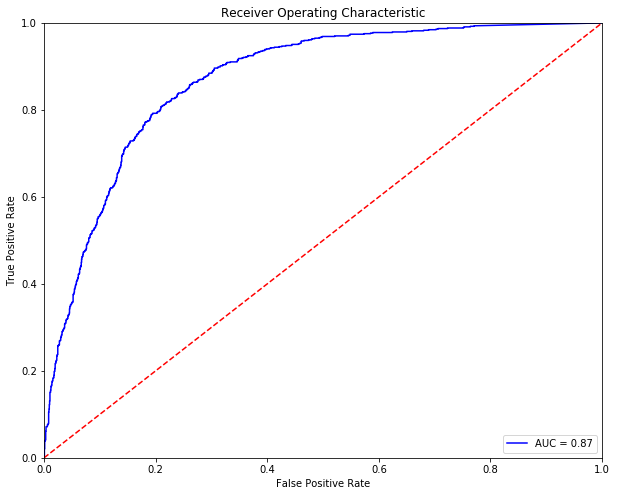

Optimal Threshold is 0.309981739228
Accuracy of Logistic Model on training data is: 0.796049979847


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         158  612      770
__all__    1521  960     2481

In [133]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [134]:
table_70_70_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [135]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.3  False           True                0.5       100          ovr   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.804111245466

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3585   493     4078
1           641  1070     1711
__all__    4226  1563     5789

Accuracy of the  Logistic  model for test data is: 0.800080612656

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1519  192     1711
1           304  466      770
__all__    1823  658     2481

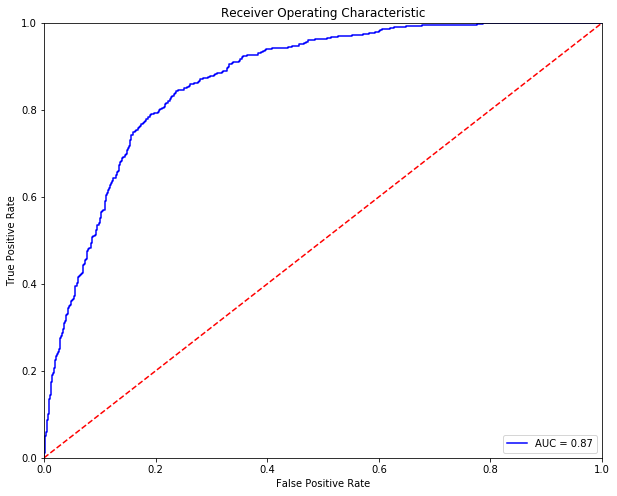

Optimal Threshold is 0.320835151966
Accuracy of Logistic Model on training data is: 0.795646916566


Predicted   0.0  1.0  __all__
Actual                       
0.0        1362  349     1711
1.0         158  612      770
__all__    1520  961     2481

In [136]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [137]:
table_70_70_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [138]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.805665918121

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3376   702     4078
1           423  1288     1711
__all__    3799  1990     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1440  271     1711
1           200  570      770
__all__    1640  841     2481

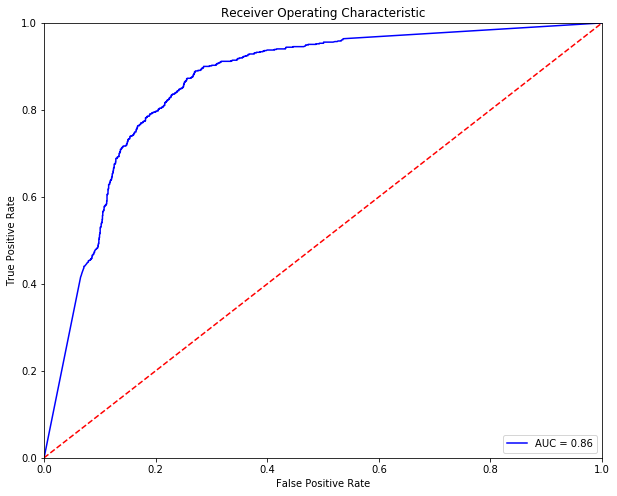

Optimal Threshold is 0.310408478215
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         156  614      770
__all__    1519  962     2481

In [139]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [140]:
table_70_70_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

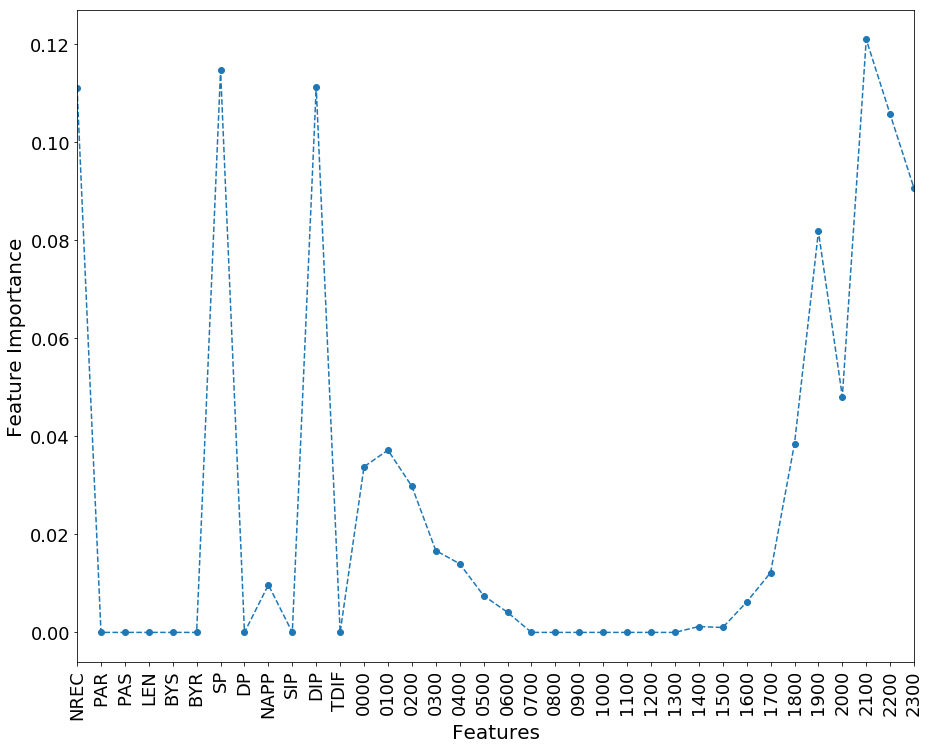

In [141]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [142]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808775263431

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3528   550     4078
1           557  1154     1711
__all__    4085  1704     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.810963321241

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1488  223     1711
1           246  524      770
__all__    1734  747     2481

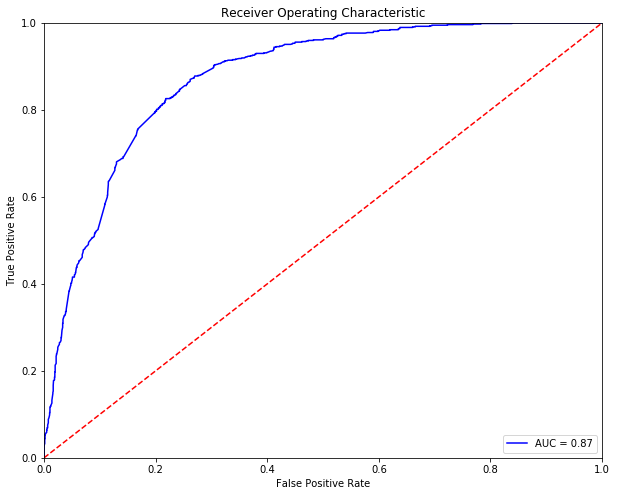

Optimal Threshold is 0.49612200695
Accuracy of Logistic Model on training data is: 0.798468359532


Predicted   0.0  1.0  __all__
Actual                       
0.0        1367  344     1711
1.0         156  614      770
__all__    1523  958     2481

In [143]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [144]:
table_70_70_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

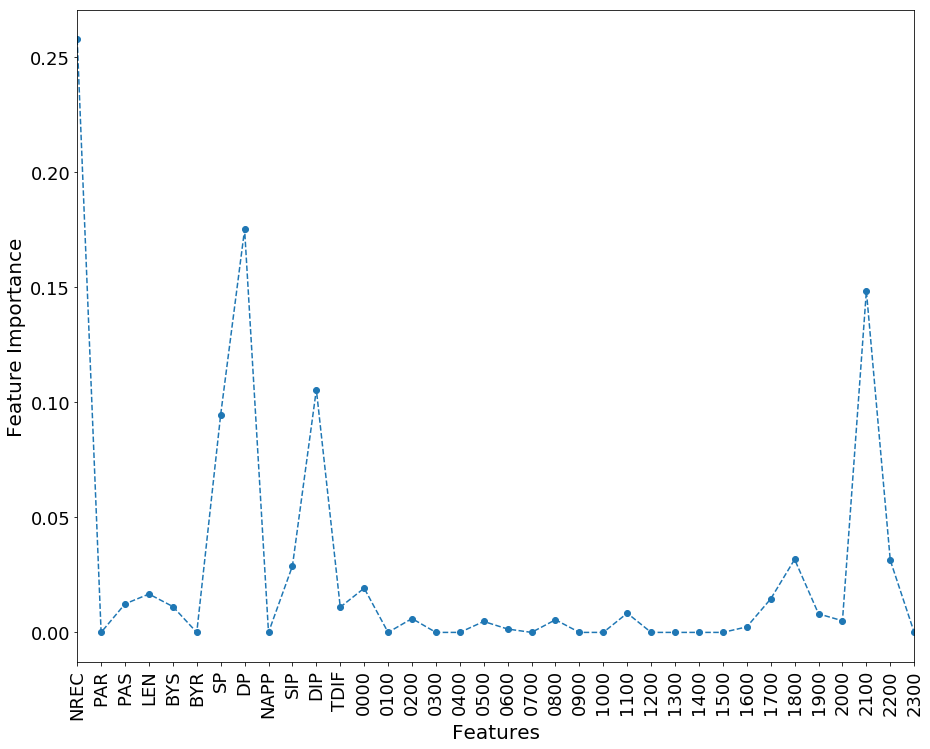

In [145]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [146]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse            0.1  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.822767317326

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3545   533     4078
1           493  1218     1711
__all__    4038  1751     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.815800080613

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1489  222     1711
1           235  535      770
__all__    1724  757     2481

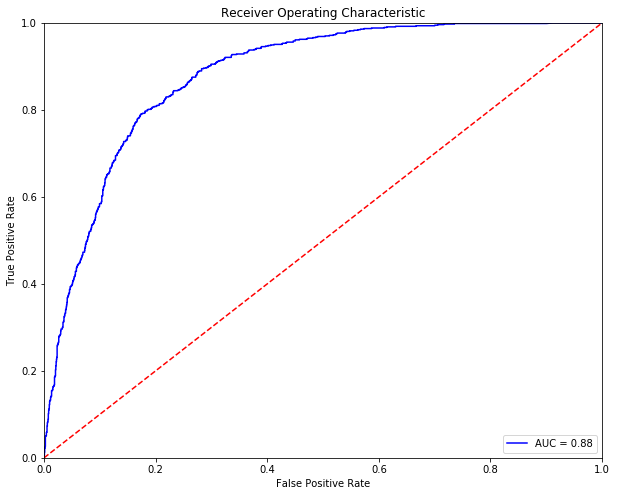

Optimal Threshold is 0.339776876504
Accuracy of Logistic Model on training data is: 0.805723498589


Predicted   0.0  1.0  __all__
Actual                       
0.0        1379  332     1711
1.0         150  620      770
__all__    1529  952     2481

In [147]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [148]:
table_70_70_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

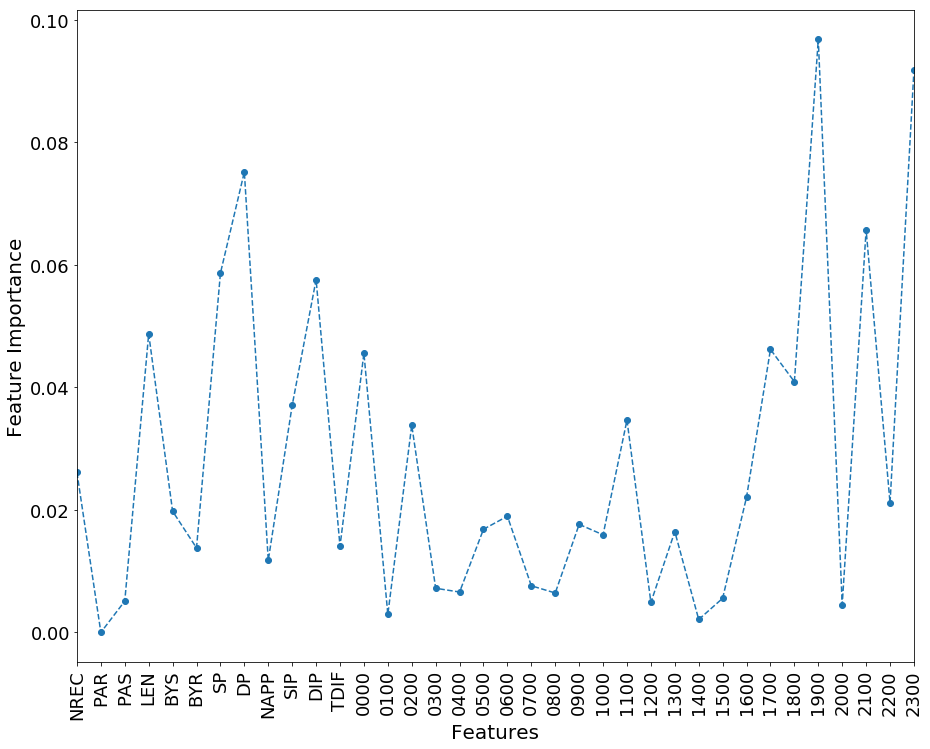

In [149]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [150]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.81015719468

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3519   559     4078
1           540  1171     1711
__all__    4059  1730     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1487  224     1711
1           259  511      770
__all__    1746  735     2481

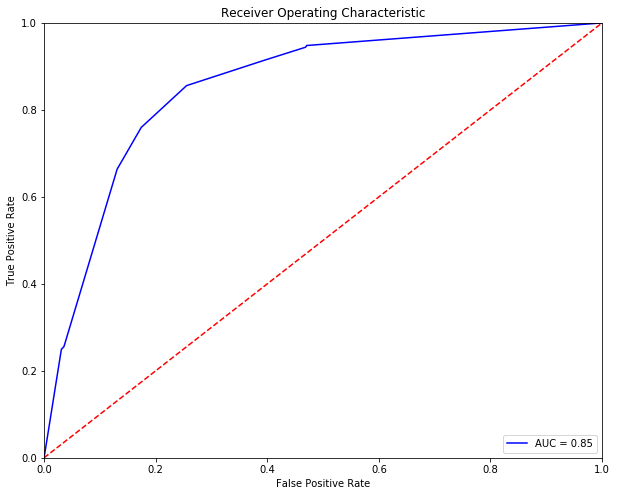

Optimal Threshold is 0.430199430199
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0        1487  224     1711
1.0         259  511      770
__all__    1746  735     2481

In [151]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [152]:
table_70_70_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [153]:
%%capture
table_70_70_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

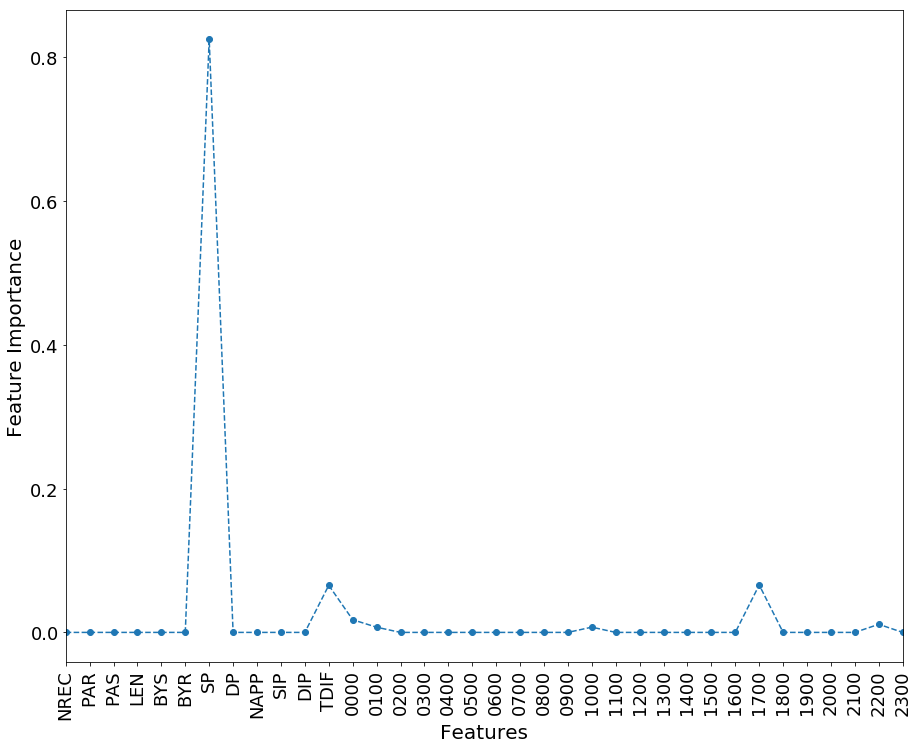

In [154]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [155]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.4          0.6          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.991190188288

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4077     1     4078
1            50  1661     1711
__all__    4127  1662     5789

Accuracy of the  Bagging  model for test data is: 0.812172511084

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1487  224     1711
1           242  528      770
__all__    1729  752     2481

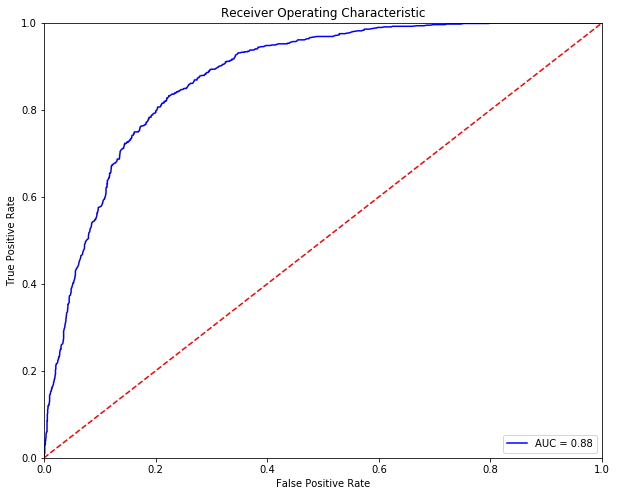

Optimal Threshold is 0.356
Accuracy of Logistic Model on training data is: 0.798871422813


Predicted   0.0  1.0  __all__
Actual                       
0.0        1368  343     1711
1.0         156  614      770
__all__    1524  957     2481

In [156]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [157]:
table_70_70_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [158]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.93418552427


Predicted     0     1  __all__
Actual                        
0          3990    88     4078
1           293  1418     1711
__all__    4283  1506     5789

The test accuracy is: 0.803708182185


Predicted     0    1  __all__
Actual                       
0          1501  210     1711
1           277  493      770
__all__    1778  703     2481

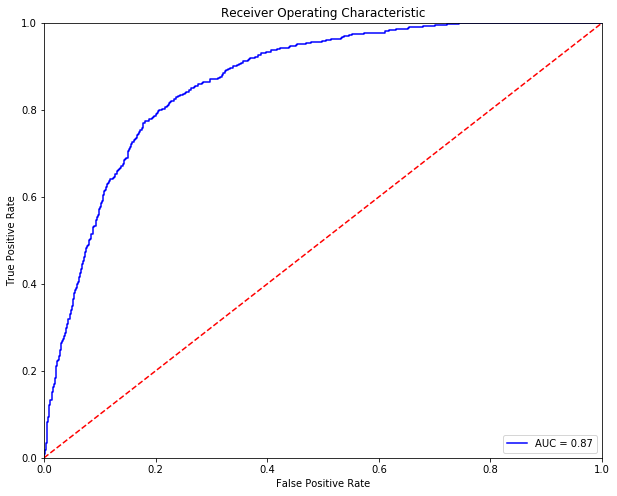

Optimal Threshold is 0.361538636439
Accuracy of Logistic Model on training data is: 0.795243853285


Predicted   0.0  1.0  __all__
Actual                       
0.0        1362  349     1711
1.0         159  611      770
__all__    1521  960     2481

In [159]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [160]:
table_70_70_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [161]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.93867680085


Predicted     0     1  __all__
Actual                        
0          3976   102     4078
1           253  1458     1711
__all__    4229  1560     5789

The accuracy of the model on test data is: 0.771060056429


Predicted     0    1  __all__
Actual                       
0          1477  234     1711
1           334  436      770
__all__    1811  670     2481

1440/2481 [================>.............] - ETA: 0s

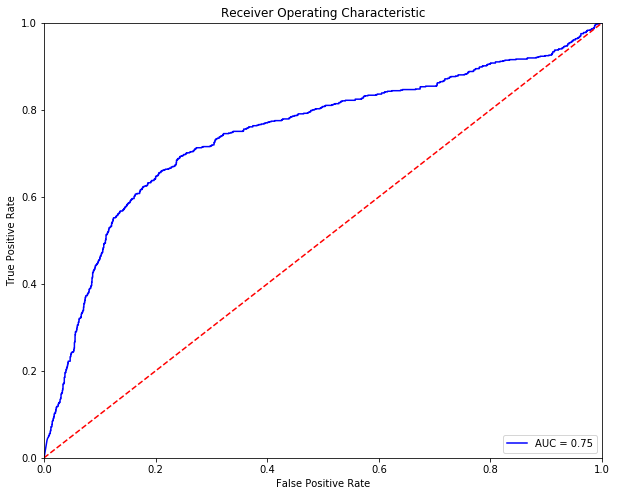

Optimal Threshold is 0.181713
Accuracy of Logistic Model on training data is: 0.715034260379


Predicted   0.0   1.0  __all__
Actual                        
0.0        1224   487     1711
1.0         220   550      770
__all__    1444  1037     2481

In [162]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [163]:
table_70_70_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [164]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.7min finished


The accuracy of the model on training data is: 0.821385386077


Predicted     0     1  __all__
Actual                        
0          3508   570     4078
1           464  1247     1711
__all__    3972  1817     5789

The accuracy of the model on test data is: 0.81015719468


Predicted     0    1  __all__
Actual                       
0          1470  241     1711
1           230  540      770
__all__    1700  781     2481

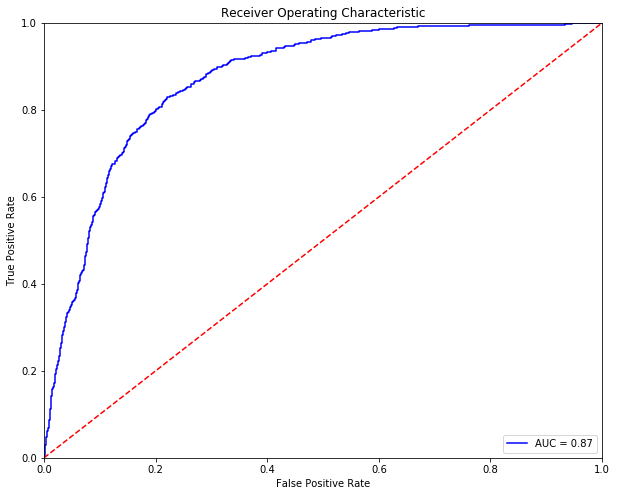

Optimal Threshold is 0.309543
Accuracy of Logistic Model on training data is: 0.799677549375


Predicted   0.0  1.0  __all__
Actual                       
0.0        1369  342     1711
1.0         155  615      770
__all__    1524  957     2481

In [165]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [166]:
table_70_70_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [167]:
table_70_70_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_test.set_index(['index'],drop=True,inplace=True)
table_70_70_train.set_index(['index'],drop=True,inplace=True)
table_70_70_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1711.0  4078.0    0.0    0.0  0.000000   
LogisticRegression          0.804111  1070.0  3585.0  493.0  641.0  0.120893   
RandomForestClassifier      0.805666  1288.0  3376.0  702.0  423.0  0.172143   
AdaBoostClassifier          0.808775  1154.0  3528.0  550.0  557.0  0.134870   
GradientBoostingClassifier  0.822767  1218.0  3545.0  533.0  493.0  0.130701   
ExtraTreeClassifier         0.810157  1171.0  3519.0  559.0  540.0  0.137077   
BaggingClassifier           0.991190  1661.0  4077.0    1.0   50.0  0.000245   
VotingClassifier            0.934186  1418.0  3990.0   88.0  293.0  0.021579   
Neural Network-1            0.938677  1458.0  3976.0  102.0  253.0  0.025012   
Neural-Network-2            0.821385  1247.0  3508.0  570.0  464.0  0.139774   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.374635  
RandomForestClassifier      0.247224  
AdaBoostClassifier          0.325541  
GradientBoostingClassifier  0.288136  
ExtraTreeClassifier         0.315605  
BaggingClassifier           0.029223  
VotingClassifier            0.171245  
Neural Network-1            0.147867  
Neural-Network-2            0.271186

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.798065  489.0  1491.0  220.0  281.0  0.128580   
LogisticRegression          0.800081  466.0  1519.0  192.0  304.0  0.112215   
RandomForestClassifier      0.810157  570.0  1440.0  271.0  200.0  0.158387   
AdaBoostClassifier          0.810963  524.0  1488.0  223.0  246.0  0.130333   
GradientBoostingClassifier  0.815800  535.0  1489.0  222.0  235.0  0.129749   
ExtraTreeClassifier         0.805320  511.0  1487.0  224.0  259.0  0.130918   
BaggingClassifier           0.812173  528.0  1487.0  224.0  242.0  0.130918   
VotingClassifier            0.803708  493.0  1501.0  210.0  277.0  0.122735   
Neural Network-1            0.771060  436.0  1477.0  234.0  334.0  0.136762   
Neural-Network-2            0.810157  540.0  1470.0  241.0  230.0  0.140853   

                                 FNR  
index                                 
KNeighborsClassifier        0.364935  
LogisticRegression          0.394805  
RandomForestClassifier      0.259740  
AdaBoostClassifier          0.319481  
GradientBoostingClassifier  0.305195  
ExtraTreeClassifier         0.336364  
BaggingClassifier           0.314286  
VotingClassifier            0.359740  
Neural Network-1            0.433766  
Neural-Network-2            0.298701

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.796050  612.0  1363.0  348.0  158.0  0.203390   
LogisticRegression          0.795647  612.0  1362.0  349.0  158.0  0.203974   
RandomForestClassifier      0.796856  614.0  1363.0  348.0  156.0  0.203390   
AdaBoostClassifier          0.798468  614.0  1367.0  344.0  156.0  0.201052   
GradientBoostingClassifier  0.805723  620.0  1379.0  332.0  150.0  0.194039   
ExtraTreeClassifier         0.805320  511.0  1487.0  224.0  259.0  0.130918   
BaggingClassifier           0.798871  614.0  1368.0  343.0  156.0  0.200468   
VotingClassifier            0.795244  611.0  1362.0  349.0  159.0  0.203974   
Neural Network-1            0.715034  550.0  1224.0  487.0  220.0  0.284629   
Neural-Network-2            0.799678  615.0  1369.0  342.0  155.0  0.199883   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.205195   0.309982  0.869327  
LogisticRegression          0.205195   0.320835  0.870470  
RandomForestClassifier      0.202597   0.310408  0.862398  
AdaBoostClassifier          0.202597   0.496122  0.873630  
GradientBoostingClassifier  0.194805   0.339777  0.880315  
ExtraTreeClassifier         0.336364   0.430199  0.854724  
BaggingClassifier           0.202597   0.356000  0.876970  
VotingClassifier            0.206494   0.361539  0.867260  
Neural Network-1            0.285714   0.181713  0.747694  
Neural-Network-2            0.201299   0.309543  0.871785

#### Random State 10

In [168]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

In [169]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

In [170]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [171]:
## Table to store training and test measures
table_70_70_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [172]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0      ball_tree          5  chebyshev           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4059     0     4059
1             0  1730     1730
__all__    4059  1730     5789

Accuracy of the  KNN  model for test data is: 0.795646916566

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1470  260     1730
1           247  504      751
__all__    1717  764     2481

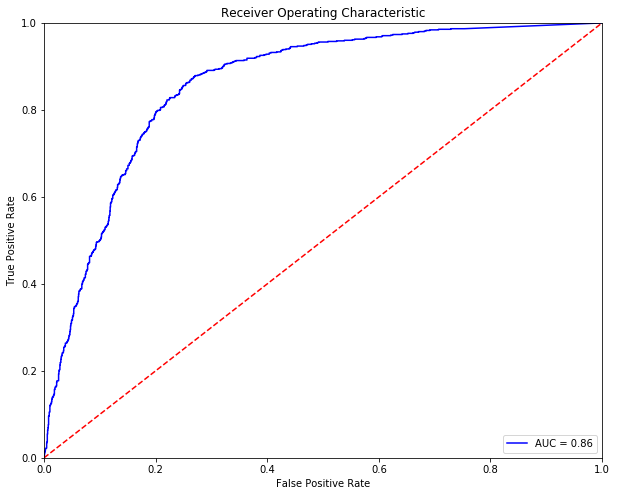

Optimal Threshold is 0.392734625212
Accuracy of Logistic Model on training data is: 0.79725916969


Predicted   0.0  1.0  __all__
Actual                       
0.0        1380  350     1730
1.0         153  598      751
__all__    1533  948     2481

In [173]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [174]:
table_70_70_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [175]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.7  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.796510623596

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3361   698     4059
1           480  1250     1730
__all__    3841  1948     5789

Accuracy of the  Logistic  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1433  297     1730
1           184  567      751
__all__    1617  864     2481

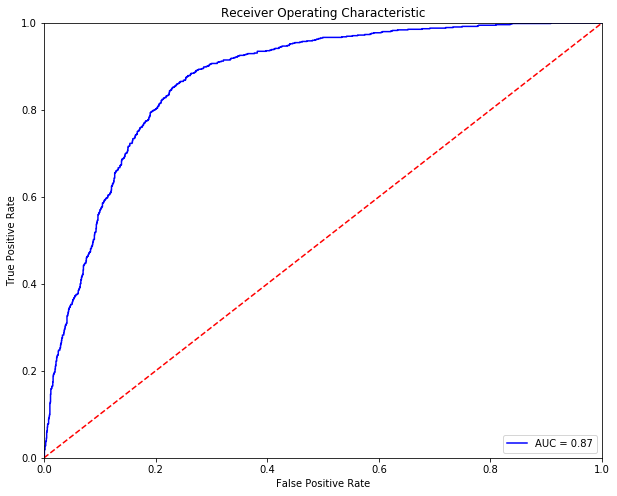

Optimal Threshold is 0.467420972221
Accuracy of Logistic Model on training data is: 0.800886739218


Predicted   0.0  1.0  __all__
Actual                       
0.0        1386  344     1730
1.0         150  601      751
__all__    1536  945     2481

In [176]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [177]:
table_70_70_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [178]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.796856106409

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3328   731     4059
1           445  1285     1730
__all__    3773  2016     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1427  303     1730
1           165  586      751
__all__    1592  889     2481

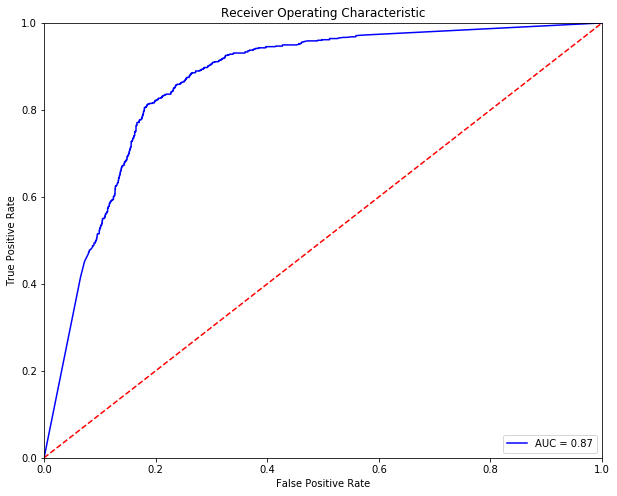

Optimal Threshold is 0.432067158644
Accuracy of Logistic Model on training data is: 0.813381700927


Predicted   0.0  1.0  __all__
Actual                       
0.0        1408  322     1730
1.0         141  610      751
__all__    1549  932     2481

In [179]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [180]:
table_70_70_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

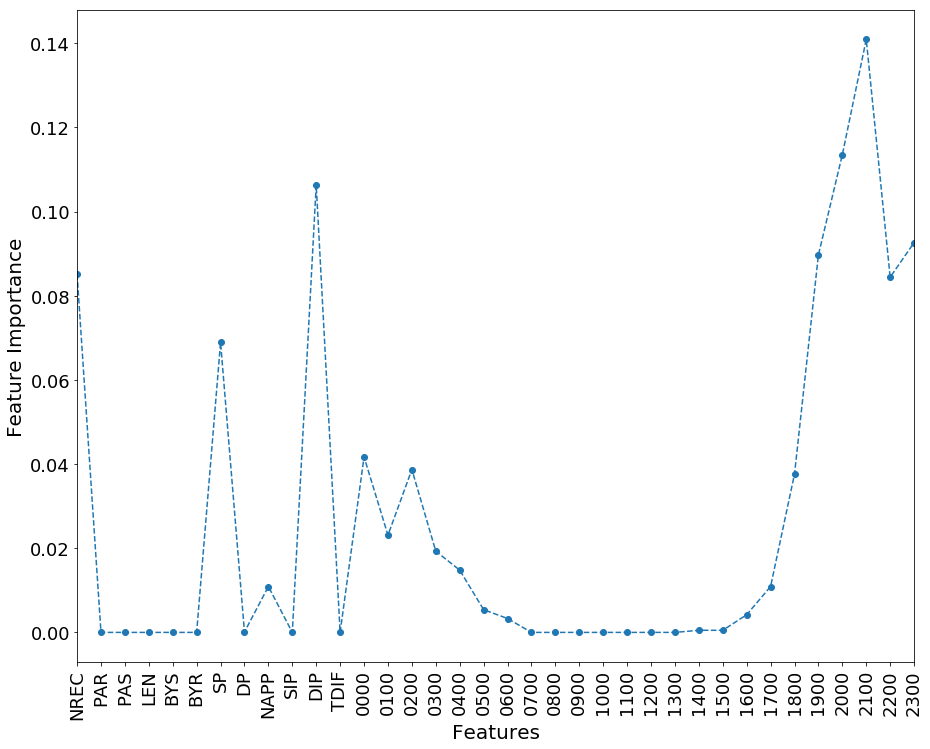

In [181]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [182]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0        SAMME.R            0.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.800138193125

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3419   640     4059
1           517  1213     1730
__all__    3936  1853     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.806529625151

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1445  285     1730
1           195  556      751
__all__    1640  841     2481

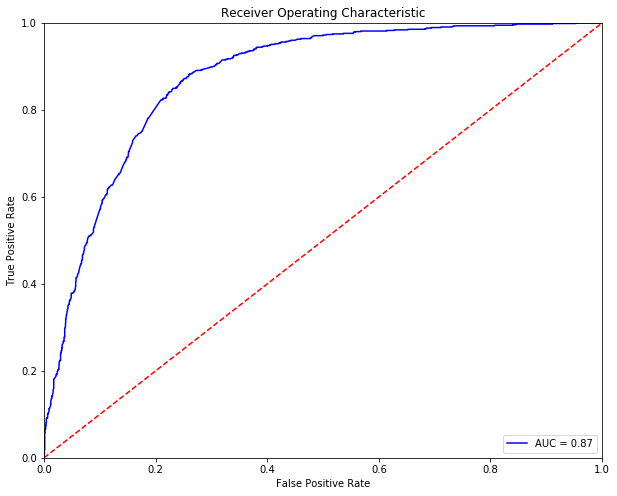

Optimal Threshold is 0.498353378469
Accuracy of Logistic Model on training data is: 0.803305118904


Predicted   0.0  1.0  __all__
Actual                       
0.0        1407  323     1730
1.0         165  586      751
__all__    1572  909     2481

In [183]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [184]:
table_70_70_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

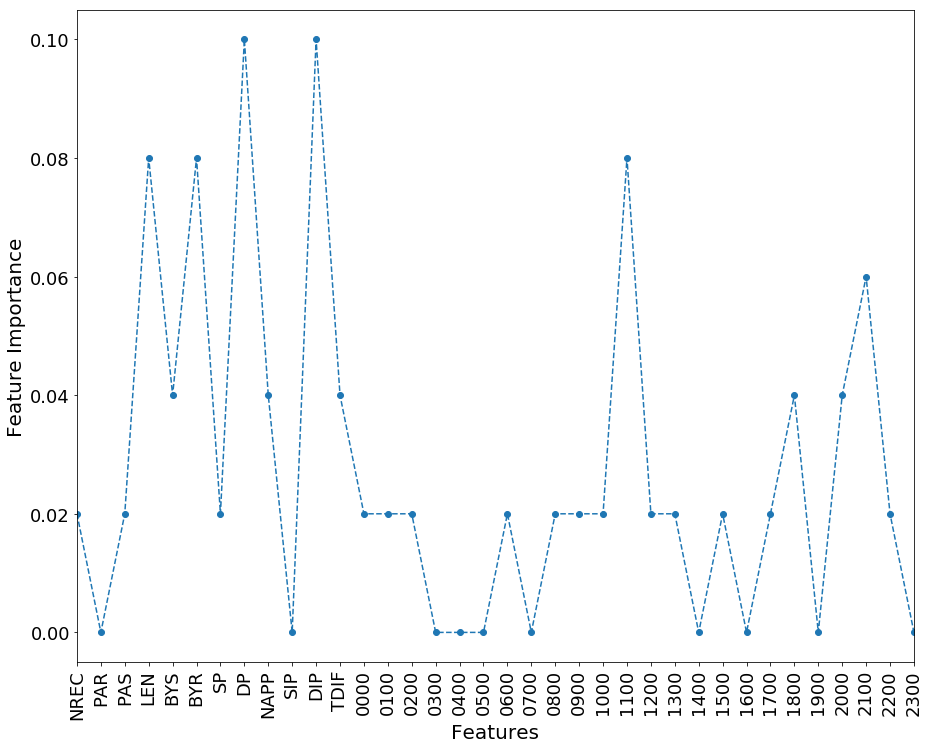

In [185]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [186]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.03  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.808429780618

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3486   573     4059
1           536  1194     1730
__all__    4022  1767     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.808544941556

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1465  265     1730
1           210  541      751
__all__    1675  806     2481

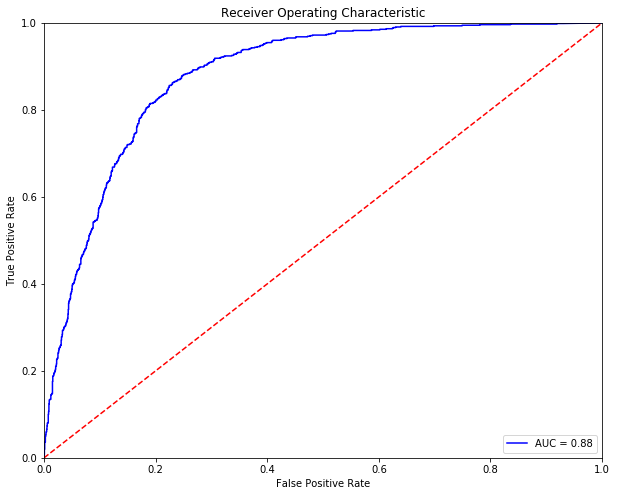

Optimal Threshold is 0.41157711123
Accuracy of Logistic Model on training data is: 0.811366384522


Predicted   0.0  1.0  __all__
Actual                       
0.0        1404  326     1730
1.0         142  609      751
__all__    1546  935     2481

In [187]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [188]:
table_70_70_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

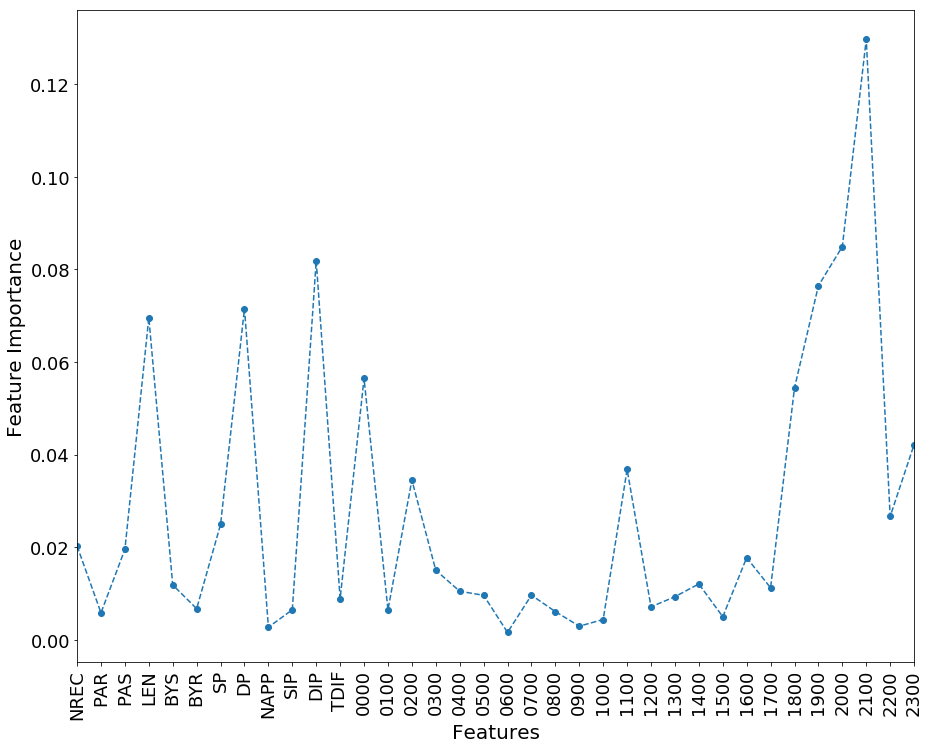

In [189]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [190]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.7994472275

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3446   613     4059
1           548  1182     1730
__all__    3994  1795     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.808141878275

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1457  273     1730
1           203  548      751
__all__    1660  821     2481

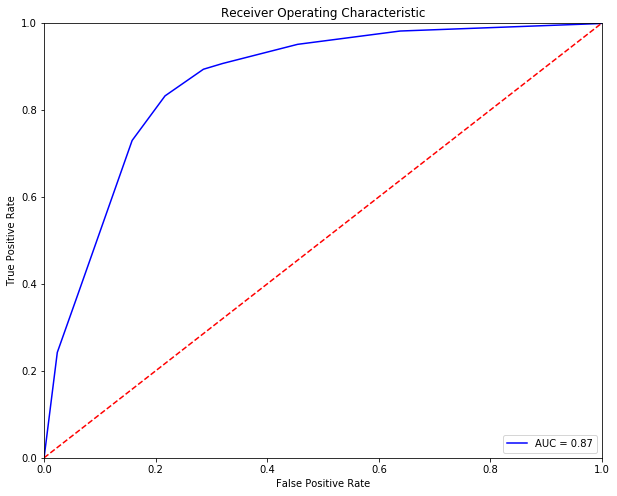

Optimal Threshold is 0.399193548387
Accuracy of Logistic Model on training data is: 0.808141878275


Predicted   0.0  1.0  __all__
Actual                       
0.0        1457  273     1730
1.0         203  548      751
__all__    1660  821     2481

In [191]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [192]:
table_70_70_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [193]:
%%capture
table_70_70_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

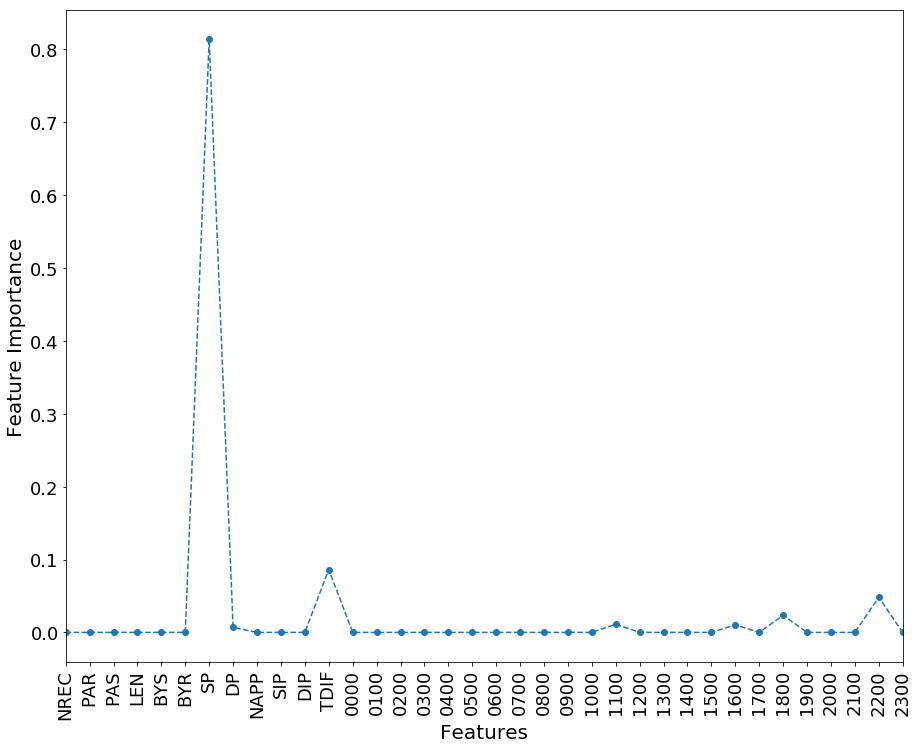

In [194]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [195]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.3          0.3           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.924684746934

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3925   134     4059
1           302  1428     1730
__all__    4227  1562     5789

Accuracy of the  Bagging  model for test data is: 0.81056025796

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1461  269     1730
1           201  550      751
__all__    1662  819     2481

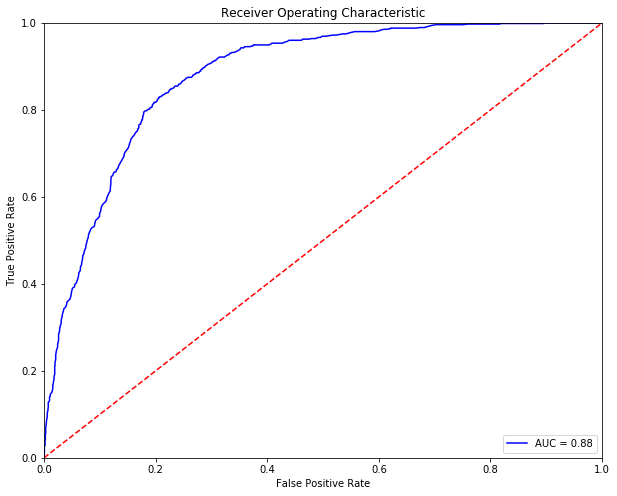

Optimal Threshold is 0.416
Accuracy of Logistic Model on training data is: 0.806932688432


Predicted   0.0  1.0  __all__
Actual                       
0.0        1397  333     1730
1.0         146  605      751
__all__    1543  938     2481

In [196]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [197]:
table_70_70_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [198]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.934358265676


Predicted     0     1  __all__
Actual                        
0          3975    84     4059
1           296  1434     1730
__all__    4271  1518     5789

The test accuracy is: 0.804111245466


Predicted     0    1  __all__
Actual                       
0          1495  235     1730
1           251  500      751
__all__    1746  735     2481

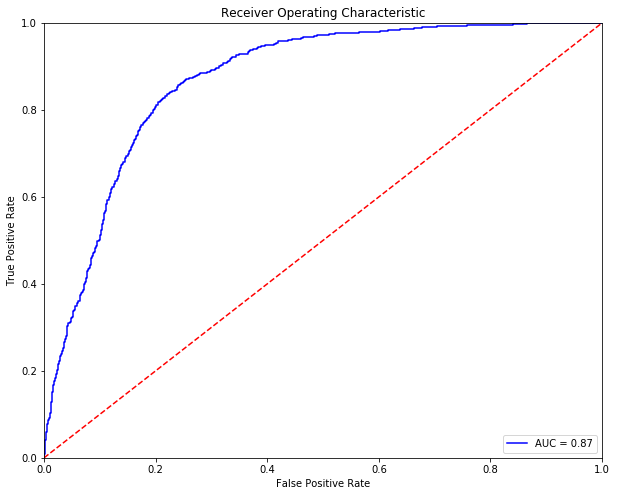

Optimal Threshold is 0.411307492915
Accuracy of Logistic Model on training data is: 0.802095929061


Predicted   0.0  1.0  __all__
Actual                       
0.0        1388  342     1730
1.0         149  602      751
__all__    1537  944     2481

In [199]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [200]:
table_70_70_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [201]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.929694247639


Predicted     0     1  __all__
Actual                        
0          3981    78     4059
1           329  1401     1730
__all__    4310  1479     5789

The accuracy of the model on test data is: 0.77146311971


Predicted     0    1  __all__
Actual                       
0          1505  225     1730
1           342  409      751
__all__    1847  634     2481

2464/2481 [============================>.] - ETA: 0s

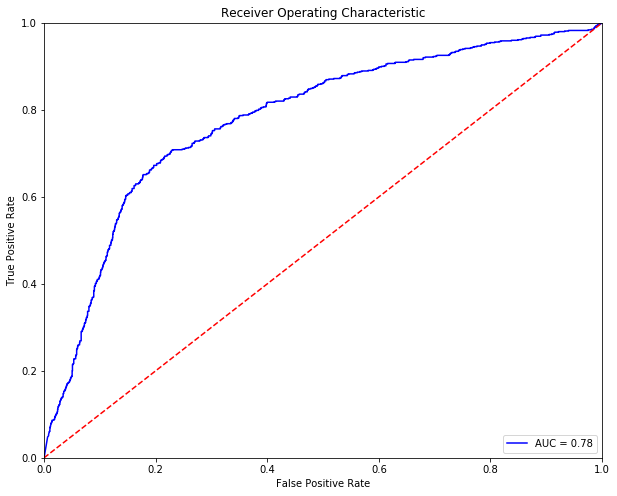

Optimal Threshold is 0.146168
Accuracy of Logistic Model on training data is: 0.728738411931


Predicted   0.0   1.0  __all__
Actual                        
0.0        1262   468     1730
1.0         205   546      751
__all__    1467  1014     2481

In [202]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [203]:
table_70_70_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [204]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.3min finished


The accuracy of the model on training data is: 0.809638970461


Predicted     0     1  __all__
Actual                        
0          3323   736     4059
1           366  1364     1730
__all__    3689  2100     5789

The accuracy of the model on test data is: 0.802902055623


Predicted     0    1  __all__
Actual                       
0          1396  334     1730
1           155  596      751
__all__    1551  930     2481

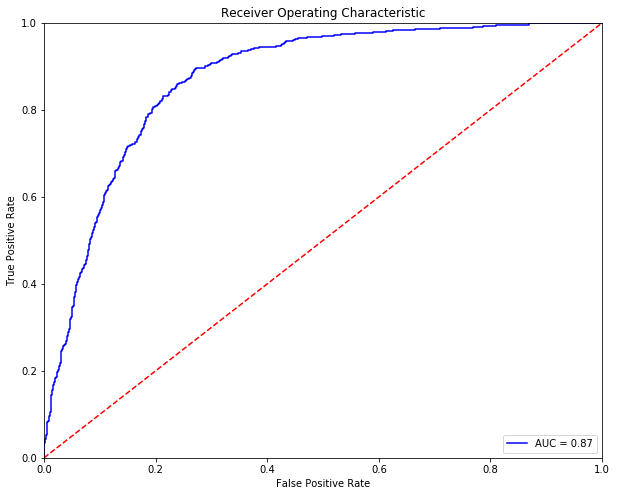

Optimal Threshold is 0.481194
Accuracy of Logistic Model on training data is: 0.804111245466


Predicted   0.0  1.0  __all__
Actual                       
0.0        1392  338     1730
1.0         148  603      751
__all__    1540  941     2481

In [205]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [206]:
table_70_70_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [207]:
table_70_70_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_10_test.set_index(['index'],drop=True,inplace=True)
table_70_70_10_train.set_index(['index'],drop=True,inplace=True)
table_70_70_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1730.0  4059.0    0.0    0.0  0.000000   
LogisticRegression          0.796511  1250.0  3361.0  698.0  480.0  0.171964   
RandomForestClassifier      0.796856  1285.0  3328.0  731.0  445.0  0.180094   
AdaBoostClassifier          0.800138  1213.0  3419.0  640.0  517.0  0.157674   
GradientBoostingClassifier  0.808430  1194.0  3486.0  573.0  536.0  0.141168   
ExtraTreeClassifier         0.799447  1182.0  3446.0  613.0  548.0  0.151022   
BaggingClassifier           0.924685  1428.0  3925.0  134.0  302.0  0.033013   
VotingClassifier            0.934358  1434.0  3975.0   84.0  296.0  0.020695   
Neural Network-1            0.929694  1401.0  3981.0   78.0  329.0  0.019217   
Neural-Network-2            0.809639  1364.0  3323.0  736.0  366.0  0.181325   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.277457  
RandomForestClassifier      0.257225  
AdaBoostClassifier          0.298844  
GradientBoostingClassifier  0.309827  
ExtraTreeClassifier         0.316763  
BaggingClassifier           0.174566  
VotingClassifier            0.171098  
Neural Network-1            0.190173  
Neural-Network-2            0.211561

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.795647  504.0  1470.0  260.0  247.0  0.150289   
LogisticRegression          0.806127  567.0  1433.0  297.0  184.0  0.171676   
RandomForestClassifier      0.811366  586.0  1427.0  303.0  165.0  0.175145   
AdaBoostClassifier          0.806530  556.0  1445.0  285.0  195.0  0.164740   
GradientBoostingClassifier  0.808545  541.0  1465.0  265.0  210.0  0.153179   
ExtraTreeClassifier         0.808142  548.0  1457.0  273.0  203.0  0.157803   
BaggingClassifier           0.810560  550.0  1461.0  269.0  201.0  0.155491   
VotingClassifier            0.804111  500.0  1495.0  235.0  251.0  0.135838   
Neural Network-1            0.771463  409.0  1505.0  225.0  342.0  0.130058   
Neural-Network-2            0.802902  596.0  1396.0  334.0  155.0  0.193064   

                                 FNR  
index                                 
KNeighborsClassifier        0.328895  
LogisticRegression          0.245007  
RandomForestClassifier      0.219707  
AdaBoostClassifier          0.259654  
GradientBoostingClassifier  0.279627  
ExtraTreeClassifier         0.270306  
BaggingClassifier           0.267643  
VotingClassifier            0.334221  
Neural Network-1            0.455393  
Neural-Network-2            0.206391

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.797259  598.0  1380.0  350.0  153.0  0.202312   
LogisticRegression          0.800887  601.0  1386.0  344.0  150.0  0.198844   
RandomForestClassifier      0.813382  610.0  1408.0  322.0  141.0  0.186127   
AdaBoostClassifier          0.803305  586.0  1407.0  323.0  165.0  0.186705   
GradientBoostingClassifier  0.811366  609.0  1404.0  326.0  142.0  0.188439   
ExtraTreeClassifier         0.808142  548.0  1457.0  273.0  203.0  0.157803   
BaggingClassifier           0.806933  605.0  1397.0  333.0  146.0  0.192486   
VotingClassifier            0.802096  602.0  1388.0  342.0  149.0  0.197688   
Neural Network-1            0.728738  546.0  1262.0  468.0  205.0  0.270520   
Neural-Network-2            0.804111  603.0  1392.0  338.0  148.0  0.195376   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.203728   0.392735  0.858114  
LogisticRegression          0.199734   0.467421  0.871331  
RandomForestClassifier      0.187750   0.432067  0.865630  
AdaBoostClassifier          0.219707   0.498353  0.874129  
GradientBoostingClassifier  0.189081   0.411577  0.880396  
ExtraTreeClassifier         0.270306   0.399194  0.865006  
BaggingClassifier           0.194407   0.416000  0.878988  
VotingClassifier            0.198402   0.411307  0.869107  
Neural Network-1            0.272969   0.146168  0.779556  
Neural-Network-2            0.197071   0.481194  0.872234

#### Random State 20

In [208]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())
## Create a feature set
X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

In [209]:
### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

In [210]:
### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [211]:
## Table to store training and test measures
table_70_70_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [212]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3        4
index  algorithm  leaf_size     metric  n_neighbors  weights
0           auto          2  manhattan           50  uniform

Accuracy of the  KNN  model for the training data is: 0.803765762653

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3568   471     4039
1           665  1085     1750
__all__    4233  1556     5789

Accuracy of the  KNN  model for test data is: 0.810963321241

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1566  184     1750
1           285  446      731
__all__    1851  630     2481

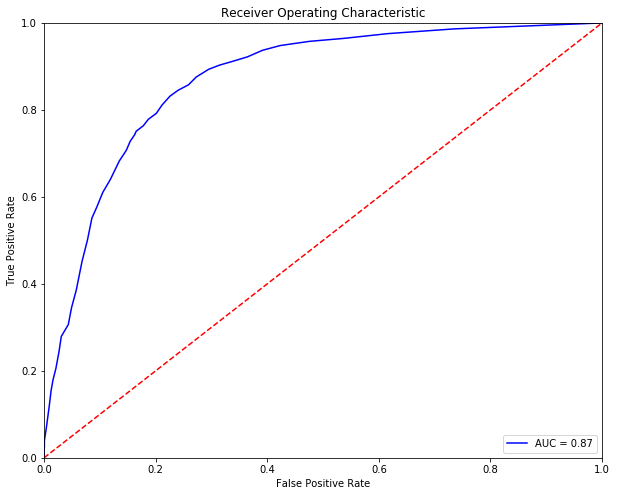

Optimal Threshold is 0.32
Accuracy of Logistic Model on training data is: 0.802902055623


Predicted   0.0  1.0  __all__
Actual                       
0.0        1423  327     1750
1.0         162  569      731
__all__    1585  896     2481

In [213]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [214]:
table_70_70_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [215]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False           True                0.7       100          ovr   

             6       7    8  
index  penalty  solver  tol  
0           l2     sag  0.1

Accuracy of the  Logistic  model for the training data is: 0.798238037658

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3360   679     4039
1           489  1261     1750
__all__    3849  1940     5789

Accuracy of the  Logistic  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1482  268     1750
1           215  516      731
__all__    1697  784     2481

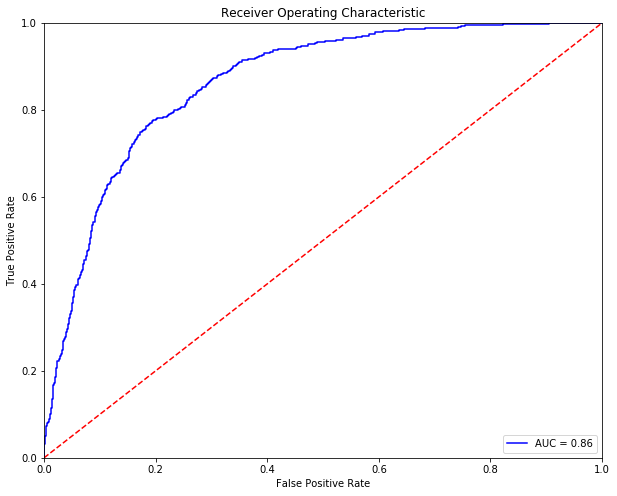

Optimal Threshold is 0.380964382067
Accuracy of Logistic Model on training data is: 0.785973397823


Predicted   0.0  1.0  __all__
Actual                       
0.0        1378  372     1750
1.0         159  572      731
__all__    1537  944     2481

In [216]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [217]:
table_70_70_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [218]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[10000],criterion=['gini','entropy'],max_depth=[10],min_samples_split=[10],
                  min_samples_leaf=[10],min_weight_fraction_leaf=[0.1], max_features=['auto'],
                  max_leaf_nodes=[10],min_impurity_decrease=[0.1],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


0          1             2               3   \
index  criterion  max_depth  max_features  max_leaf_nodes   
0           gini         10          auto              10   

                          4                 5                  6   \
index  min_impurity_decrease  min_samples_leaf  min_samples_split   
0                        0.1                10                 10   

                             7             8          9             10  \
index  min_weight_fraction_leaf  n_estimators  oob_score  random_state   
0                           0.1         10000      False             0   

            11  
index  verbose  
0            0

Accuracy of the  Random Forest Trees  model for the training data is: 0.799274486094

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3303   736     4039
1           426  1324     1750
__all__    3729  2060     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.808544941556

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1464  286     1750
1           189  542      731
__all__    1653  828     2481

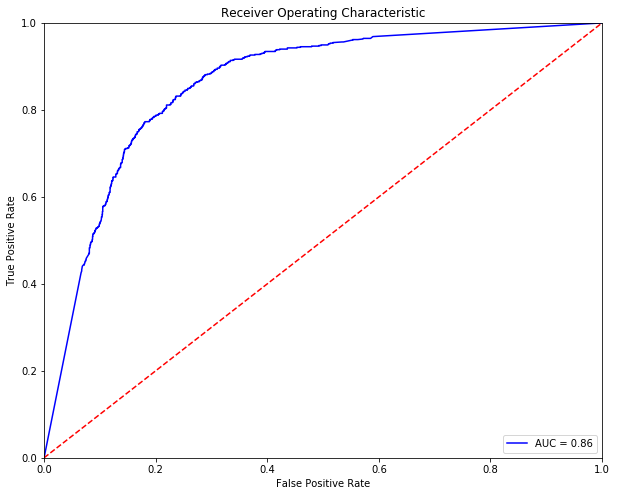

Optimal Threshold is 0.31643973588
Accuracy of Logistic Model on training data is: 0.792422410318


Predicted   0.0  1.0  __all__
Actual                       
0.0        1388  362     1750
1.0         153  578      731
__all__    1541  940     2481

In [219]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [220]:
table_70_70_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

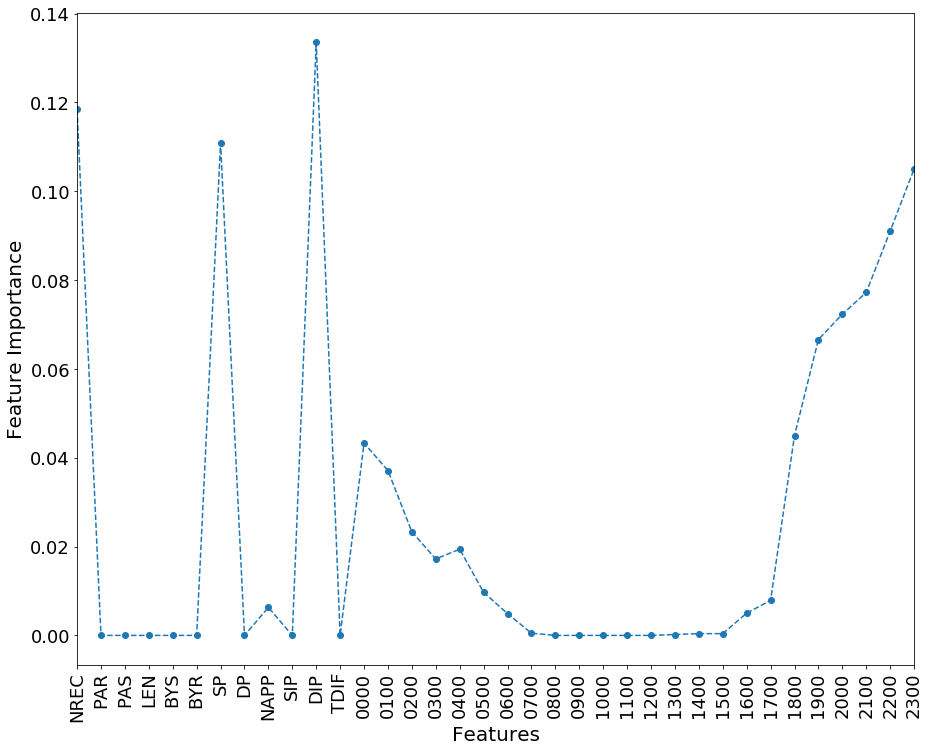

In [221]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [222]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.808775263431

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3416   623     4039
1           484  1266     1750
__all__    3900  1889     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1477  273     1750
1           208  523      731
__all__    1685  796     2481

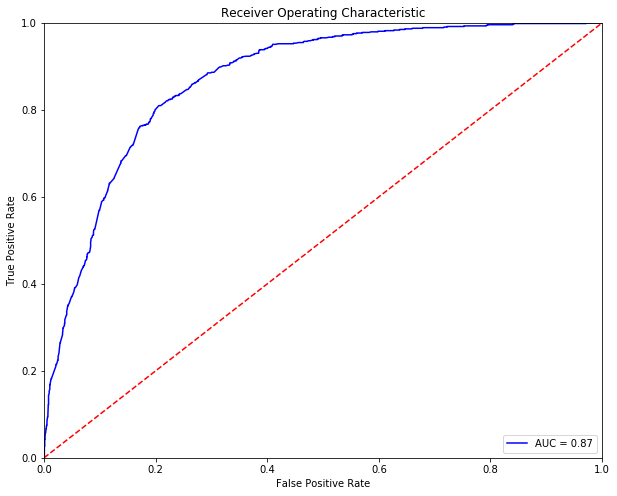

Optimal Threshold is 0.480411840654
Accuracy of Logistic Model on training data is: 0.800080612656


Predicted   0.0  1.0  __all__
Actual                       
0.0        1402  348     1750
1.0         148  583      731
__all__    1550  931     2481

In [223]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [224]:
table_70_70_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

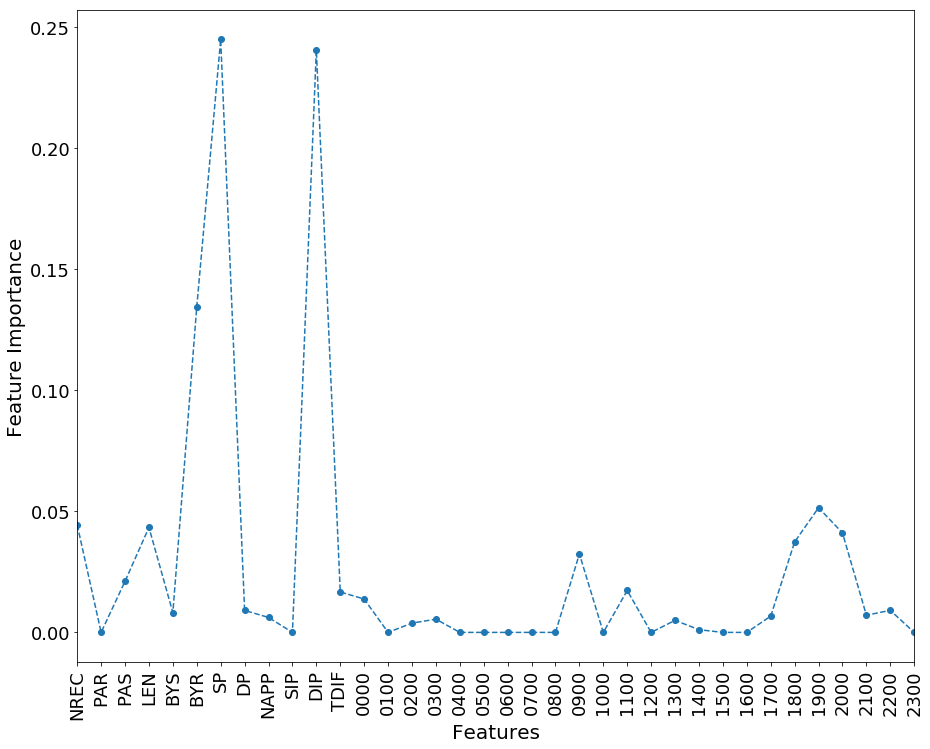

In [225]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [226]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                 5   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           150             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.821039903265

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3497   542     4039
1           494  1256     1750
__all__    3991  1798     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.811366384522

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1522  228     1750
1           240  491      731
__all__    1762  719     2481

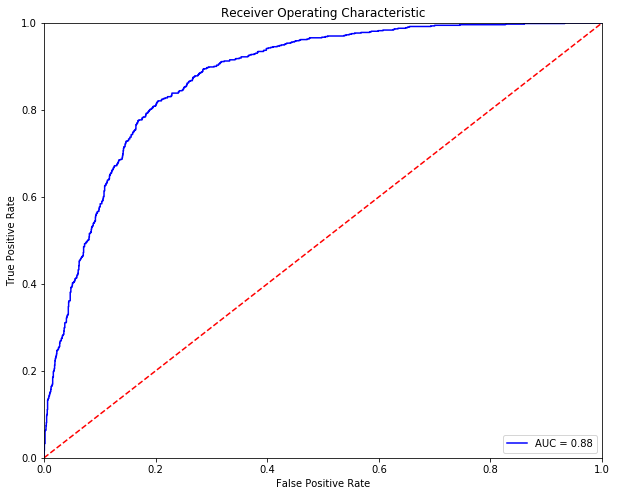

Optimal Threshold is 0.352002530689
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0        1410  340     1750
1.0         143  588      731
__all__    1553  928     2481

In [227]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [228]:
table_70_70_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

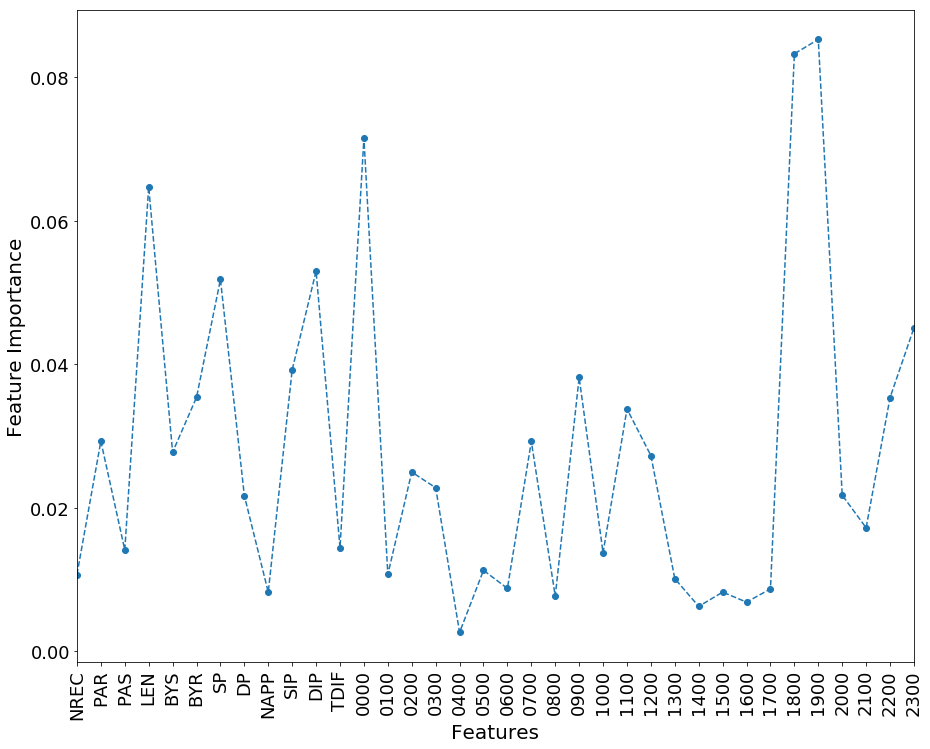

In [229]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [230]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  5             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.81948523061

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3610   429     4039
1           616  1134     1750
__all__    4226  1563     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.798468359532

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1540  210     1750
1           290  441      731
__all__    1830  651     2481

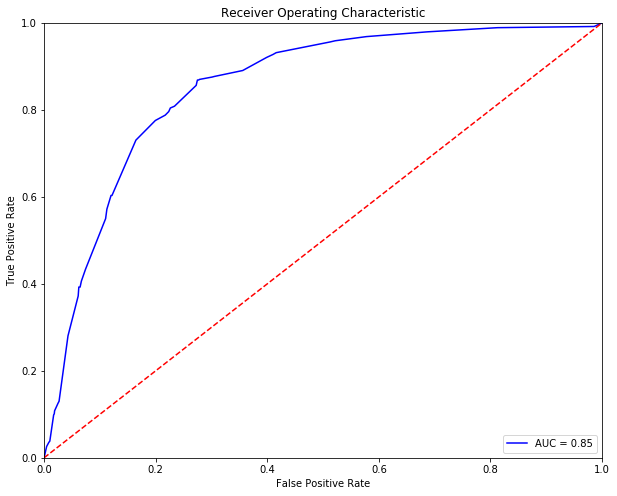

Optimal Threshold is 0.352272727273
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0        1401  349     1750
1.0         164  567      731
__all__    1565  916     2481

In [231]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [232]:
table_70_70_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [233]:
%%capture
table_70_70_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

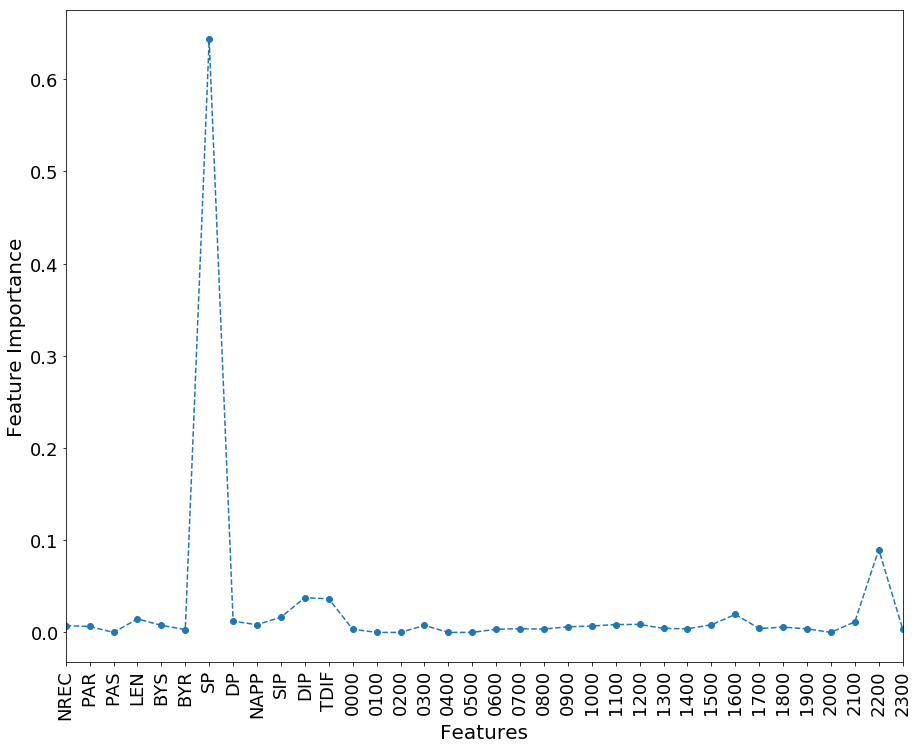

In [234]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 35])
plt.xticks(np.arange(36),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [235]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,1500,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.2          0.4          1500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.951459664882

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3980    59     4039
1           222  1528     1750
__all__    4202  1587     5789

Accuracy of the  Bagging  model for test data is: 0.817815397017

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1519  231     1750
1           221  510      731
__all__    1740  741     2481

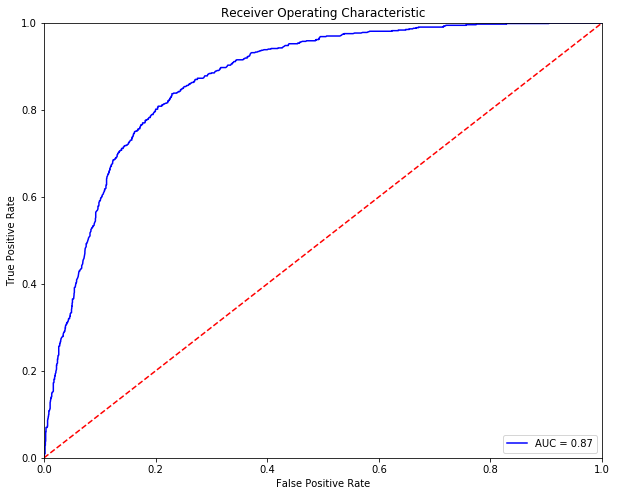

Optimal Threshold is 0.364
Accuracy of Logistic Model on training data is: 0.800080612656


Predicted   0.0  1.0  __all__
Actual                       
0.0        1401  349     1750
1.0         147  584      731
__all__    1548  933     2481

In [236]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [237]:
table_70_70_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [238]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.936949386768


Predicted     0     1  __all__
Actual                        
0          3959    80     4039
1           285  1465     1750
__all__    4244  1545     5789

The test accuracy is: 0.798065296252


Predicted     0    1  __all__
Actual                       
0          1517  233     1750
1           268  463      731
__all__    1785  696     2481

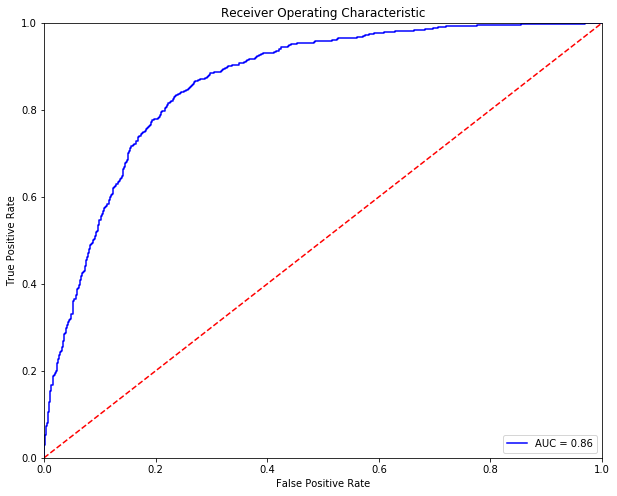

Optimal Threshold is 0.363544871772
Accuracy of Logistic Model on training data is: 0.790407093914


Predicted   0.0  1.0  __all__
Actual                       
0.0        1384  366     1750
1.0         154  577      731
__all__    1538  943     2481

In [239]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [240]:
table_70_70_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [241]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.926584902514


Predicted     0     1  __all__
Actual                        
0          3936   103     4039
1           322  1428     1750
__all__    4258  1531     5789

The accuracy of the model on test data is: 0.783151954857


Predicted     0    1  __all__
Actual                       
0          1527  223     1750
1           315  416      731
__all__    1842  639     2481

1952/2481 [======================>.......] - ETA: 0s

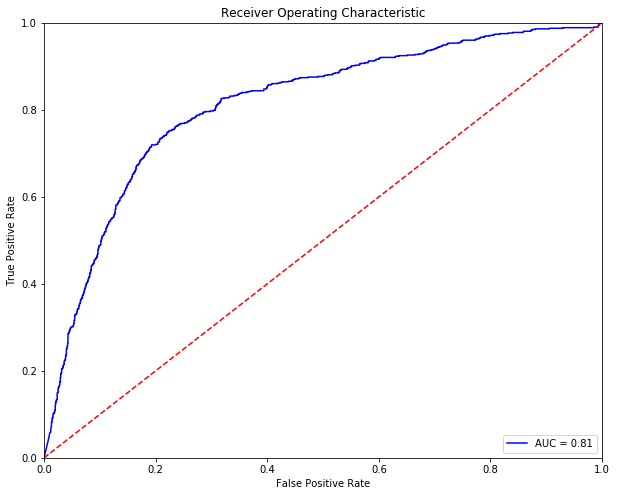

Optimal Threshold is 0.135261
Accuracy of Logistic Model on training data is: 0.762595727529


Predicted   0.0  1.0  __all__
Actual                       
0.0        1335  415     1750
1.0         174  557      731
__all__    1509  972     2481

In [242]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [243]:
table_70_70_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [244]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=36))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.8min finished


The accuracy of the model on training data is: 0.820003454828


Predicted     0     1  __all__
Actual                        
0          3528   511     4039
1           531  1219     1750
__all__    4059  1730     5789

The accuracy of the model on test data is: 0.808948004837


Predicted     0    1  __all__
Actual                       
0          1528  222     1750
1           252  479      731
__all__    1780  701     2481

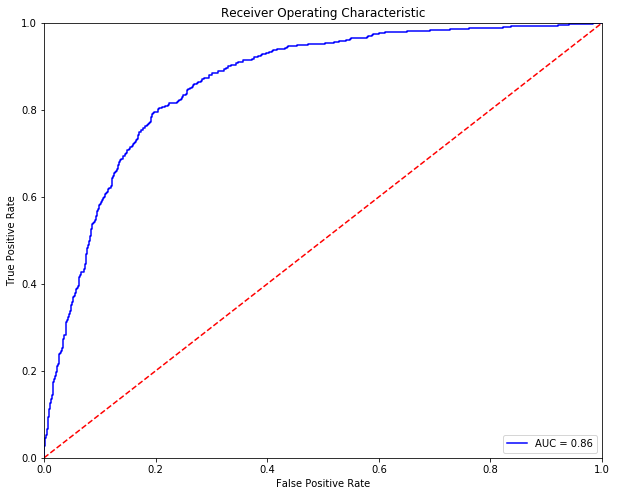

Optimal Threshold is 0.353081
Accuracy of Logistic Model on training data is: 0.796856106409


Predicted   0.0  1.0  __all__
Actual                       
0.0        1395  355     1750
1.0         149  582      731
__all__    1544  937     2481

In [245]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [246]:
table_70_70_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [247]:
table_70_70_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_20_test.set_index(['index'],drop=True,inplace=True)
table_70_70_20_train.set_index(['index'],drop=True,inplace=True)
table_70_70_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        0.803766  1085.0  3568.0  471.0  665.0  0.116613   
LogisticRegression          0.798238  1261.0  3360.0  679.0  489.0  0.168111   
RandomForestClassifier      0.799274  1324.0  3303.0  736.0  426.0  0.182223   
AdaBoostClassifier          0.808775  1266.0  3416.0  623.0  484.0  0.154246   
GradientBoostingClassifier  0.821040  1256.0  3497.0  542.0  494.0  0.134192   
ExtraTreeClassifier         0.819485  1134.0  3610.0  429.0  616.0  0.106214   
BaggingClassifier           0.951460  1528.0  3980.0   59.0  222.0  0.014608   
VotingClassifier            0.936949  1465.0  3959.0   80.0  285.0  0.019807   
Neural Network-1            0.926585  1428.0  3936.0  103.0  322.0  0.025501   
Neural-Network-2            0.820003  1219.0  3528.0  511.0  531.0  0.126516   

                                 FNR  
index                                 
KNeighborsClassifier        0.380000  
LogisticRegression          0.279429  
RandomForestClassifier      0.243429  
AdaBoostClassifier          0.276571  
GradientBoostingClassifier  0.282286  
ExtraTreeClassifier         0.352000  
BaggingClassifier           0.126857  
VotingClassifier            0.162857  
Neural Network-1            0.184000  
Neural-Network-2            0.303429

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.810963  446.0  1566.0  184.0  285.0  0.105143   
LogisticRegression          0.805320  516.0  1482.0  268.0  215.0  0.153143   
RandomForestClassifier      0.808545  542.0  1464.0  286.0  189.0  0.163429   
AdaBoostClassifier          0.806127  523.0  1477.0  273.0  208.0  0.156000   
GradientBoostingClassifier  0.811366  491.0  1522.0  228.0  240.0  0.130286   
ExtraTreeClassifier         0.798468  441.0  1540.0  210.0  290.0  0.120000   
BaggingClassifier           0.817815  510.0  1519.0  231.0  221.0  0.132000   
VotingClassifier            0.798065  463.0  1517.0  233.0  268.0  0.133143   
Neural Network-1            0.783152  416.0  1527.0  223.0  315.0  0.127429   
Neural-Network-2            0.808948  479.0  1528.0  222.0  252.0  0.126857   

                                 FNR  
index                                 
KNeighborsClassifier        0.389877  
LogisticRegression          0.294118  
RandomForestClassifier      0.258550  
AdaBoostClassifier          0.284542  
GradientBoostingClassifier  0.328317  
ExtraTreeClassifier         0.396717  
BaggingClassifier           0.302326  
VotingClassifier            0.366621  
Neural Network-1            0.430917  
Neural-Network-2            0.344733

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.802902  569.0  1423.0  327.0  162.0  0.186857   
LogisticRegression          0.785973  572.0  1378.0  372.0  159.0  0.212571   
RandomForestClassifier      0.792422  578.0  1388.0  362.0  153.0  0.206857   
AdaBoostClassifier          0.800081  583.0  1402.0  348.0  148.0  0.198857   
GradientBoostingClassifier  0.805320  588.0  1410.0  340.0  143.0  0.194286   
ExtraTreeClassifier         0.793229  567.0  1401.0  349.0  164.0  0.199429   
BaggingClassifier           0.800081  584.0  1401.0  349.0  147.0  0.199429   
VotingClassifier            0.790407  577.0  1384.0  366.0  154.0  0.209143   
Neural Network-1            0.762596  557.0  1335.0  415.0  174.0  0.237143   
Neural-Network-2            0.796856  582.0  1395.0  355.0  149.0  0.202857   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.221614   0.320000  0.870030  
LogisticRegression          0.217510   0.380964  0.863106  
RandomForestClassifier      0.209302   0.316440  0.859545  
AdaBoostClassifier          0.202462   0.480412  0.870902  
GradientBoostingClassifier  0.195622   0.352003  0.876434  
ExtraTreeClassifier         0.224350   0.352273  0.852794  
BaggingClassifier           0.201094   0.364000  0.872964  
VotingClassifier            0.210670   0.363545  0.863819  
Neural Network-1            0.238030   0.135261  0.811454  
Neural-Network-2            0.203830   0.353081  0.863992

In [248]:
table_70_70_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_70_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_70_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

In [249]:
table_70_70_train_avg['accuracy']=(table_70_70_train['accuracy']+table_70_70_10_train['accuracy']+table_70_70_20_train['accuracy'])/3.0
table_70_70_train_avg['FPR']=(table_70_70_train['FPR']+table_70_70_10_train['FPR']+table_70_70_20_train['FPR'])/3.0
table_70_70_train_avg['FNR']=(table_70_70_train['FNR']+table_70_70_10_train['FNR']+table_70_70_20_train['FNR'])/3.0

In [250]:
table_70_70_test_avg['accuracy']=(table_70_70_test['accuracy']+table_70_70_10_test['accuracy']+table_70_70_20_test['accuracy'])/3.0
table_70_70_test_avg['FPR']=(table_70_70_test['FPR']+table_70_70_10_test['FPR']+table_70_70_20_test['FPR'])/3.0
table_70_70_test_avg['FNR']=(table_70_70_test['FNR']+table_70_70_10_test['FNR']+table_70_70_20_test['FNR'])/3.0

In [251]:
table_70_70_test_roc_avg['accuracy']=(table_70_70_test_roc['accuracy']+table_70_70_10_test_roc['accuracy']+table_70_70_20_test_roc['accuracy'])/3.0
table_70_70_test_roc_avg['FPR']=(table_70_70_test_roc['FPR']+table_70_70_10_test_roc['FPR']+table_70_70_20_test_roc['FPR'])/3.0
table_70_70_test_roc_avg['FNR']=(table_70_70_test_roc['FNR']+table_70_70_10_test_roc['FNR']+table_70_70_20_test_roc['FNR'])/3.0
table_70_70_test_roc_avg['auc']=(table_70_70_test_roc['auc']+table_70_70_10_test_roc['auc']+table_70_70_20_test_roc['auc'])/3.0

In [252]:
print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_70_70_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_70_70_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_test_roc_avg)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        0.934589  0.038871  0.126667
LogisticRegression          0.799620  0.153656  0.310507
RandomForestClassifier      0.800599  0.178153  0.249293
AdaBoostClassifier          0.805896  0.148930  0.300319
GradientBoostingClassifier  0.817412  0.135354  0.293416
ExtraTreeClassifier         0.809697  0.131438  0.328123
BaggingClassifier           0.955778  0.015955  0.110215
VotingClassifier            0.935164  0.020694  0.168400
Neural Network-1            0.931652  0.023243  0.174013
Neural-Network-2            0.817009  0.149205  0.262059

Comparision Table for Test Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        0.801559  0.128004  0.361236
LogisticRegression          0.803843  0.145678  0.311310
RandomForestClassifier      0.810023  0.165653  0.245999
AdaBoostClassifier          0.807873  0.150358  0.287892
GradientBoostingClassifier  0.811904  0.137738  0.304380
ExtraTreeClassifier         0.803977  0.136240  0.334462
BaggingClassifier           0.813516  0.139470  0.294751
VotingClassifier            0.801962  0.130572  0.353527
Neural Network-1            0.775225  0.131416  0.440025
Neural-Network-2            0.807336  0.153591  0.283275

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy       FPR       FNR       auc
index                                                             
KNeighborsClassifier        0.798737  0.197520  0.210179  0.865824
LogisticRegression          0.794169  0.205130  0.207480  0.868302
RandomForestClassifier      0.800887  0.198791  0.199883  0.862524
AdaBoostClassifier          0.800618  0.195538  0.208256  0.872887
GradientBoostingClassifier  0.807470  0.192255  0.193170  0.879048
ExtraTreeClassifier         0.802230  0.162717  0.277007  0.857508
BaggingClassifier           0.801962  0.197461  0.199366  0.876307
VotingClassifier            0.795916  0.203602  0.205189  0.866729
Neural Network-1            0.735456  0.264097  0.265571  0.779568
Neural-Network-2            0.800215  0.199372  0.200733  0.869337

### <a id='1.B'  style="text-decoration : none; color : #000000;"> B. 70:30 Train Test Split</a>

#### Random State 0

### <a id='1.C' style="text-decoration : none; color : #000000;">C. 80:20 Train Test split with PCA</a>

#### Random State 0

In [3]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.922348229056
The train/test split ratio is 80:20


In [4]:
display(X_pca_13[0:1])

array([[ 0.51069587, -0.17479937, -0.18757661, -0.21230661, -0.83309263,
         0.55899882,  0.157608  , -0.1043382 ,  0.82023985, -0.32529949,
         0.30768313, -0.3310058 , -1.04421636]])

In [24]:
## Table to store training and test measures
table_80_70_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4643     0     4643
1             0  1973     1973
__all__    4643  1973     6616

Accuracy of the  KNN  model for test data is: 0.787182587666

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1029  117     1146
1           235  273      508
__all__    1264  390     1654

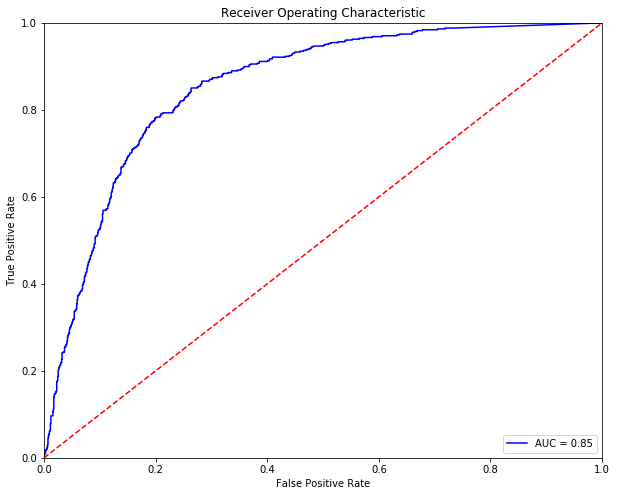

Optimal Threshold is 0.289455825289
Accuracy of Logistic Model on training data is: 0.790205562273


Predicted   0.0  1.0  __all__
Actual                       
0.0         906  240     1146
1.0         107  401      508
__all__    1013  641     1654

In [26]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [27]:
table_80_70_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [28]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  0.001

Accuracy of the  Logistic  model for the training data is: 0.800634824667

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3748   895     4643
1           424  1549     1973
__all__    4172  2444     6616

Accuracy of the  Logistic  model for test data is: 0.798669891173

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           926  220     1146
1           113  395      508
__all__    1039  615     1654

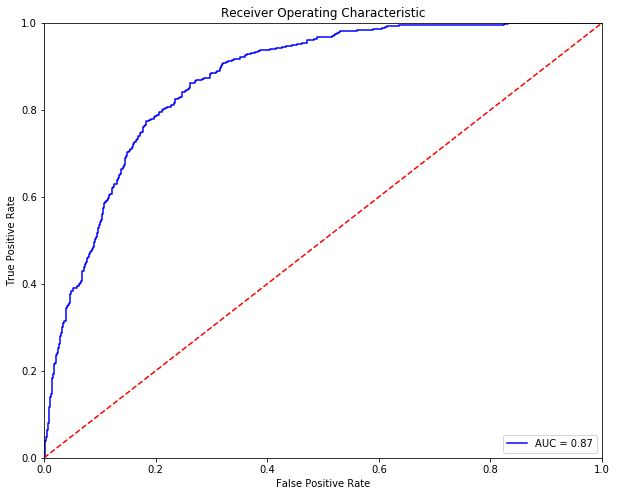

Optimal Threshold is 0.479333649407
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  237     1146
1.0         105  403      508
__all__    1014  640     1654

In [29]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [30]:
table_80_70_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [32]:
rf=RandomForestClassifier()
parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.988361547763

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4630    13     4643
1            64  1909     1973
__all__    4694  1922     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.778718258767

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1006  140     1146
1           226  282      508
__all__    1232  422     1654

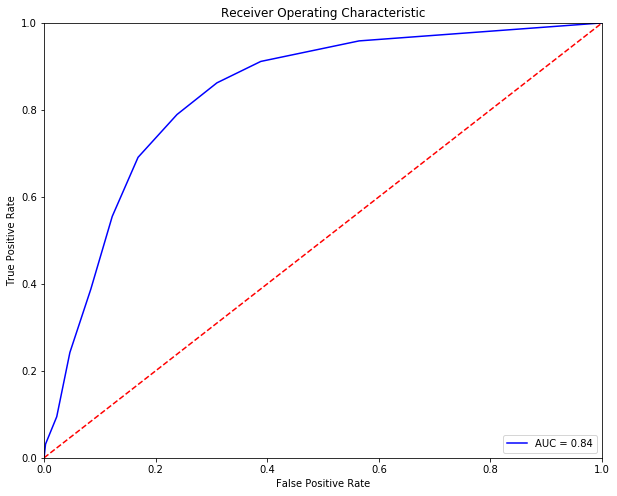

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.788391777509


Predicted   0.0  1.0  __all__
Actual                       
0.0         953  193     1146
1.0         157  351      508
__all__    1110  544     1654

In [33]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [34]:
%%capture
table_80_70_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

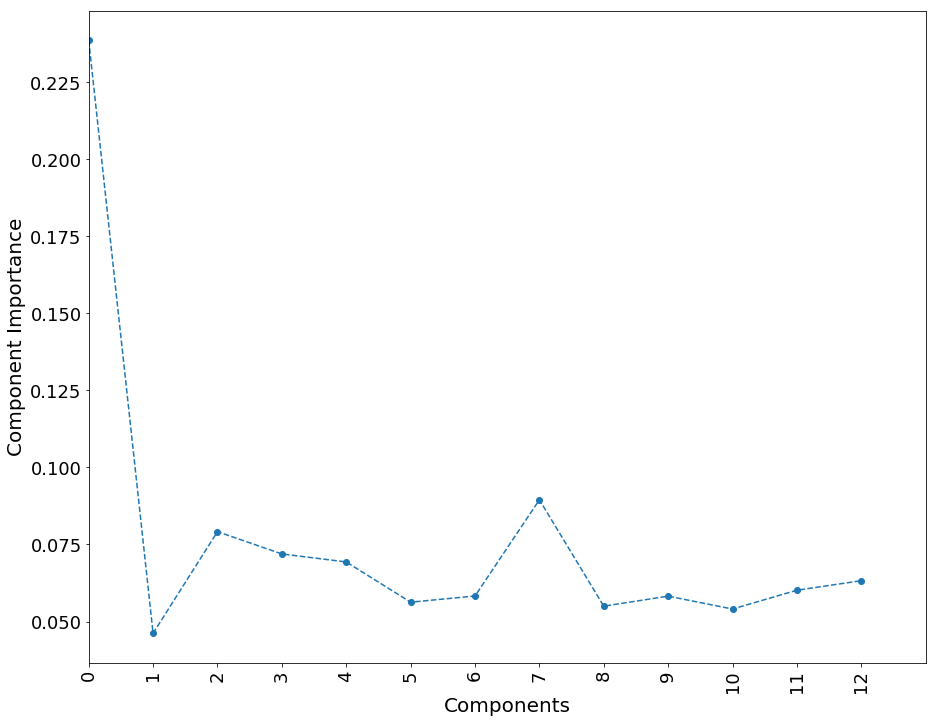

In [37]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [36]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809854897219

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3910   733     4643
1           525  1448     1973
__all__    4435  2181     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.798065296252

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           955  191     1146
1           143  365      508
__all__    1098  556     1654

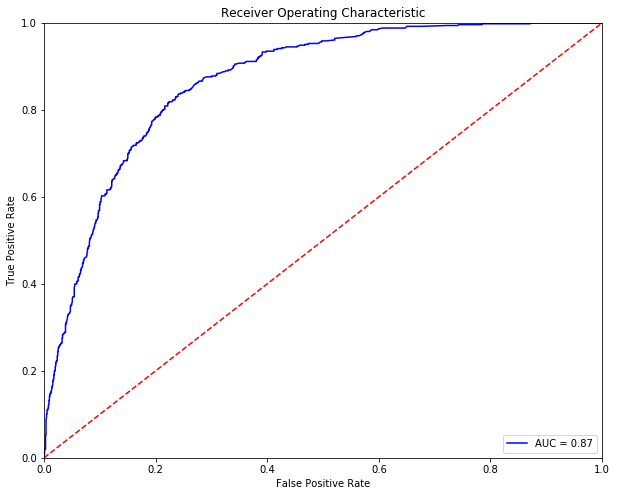

Optimal Threshold is 0.477024200298
Accuracy of Logistic Model on training data is: 0.791414752116


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  239     1146
1.0         106  402      508
__all__    1013  641     1654

In [38]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [39]:
table_80_70_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

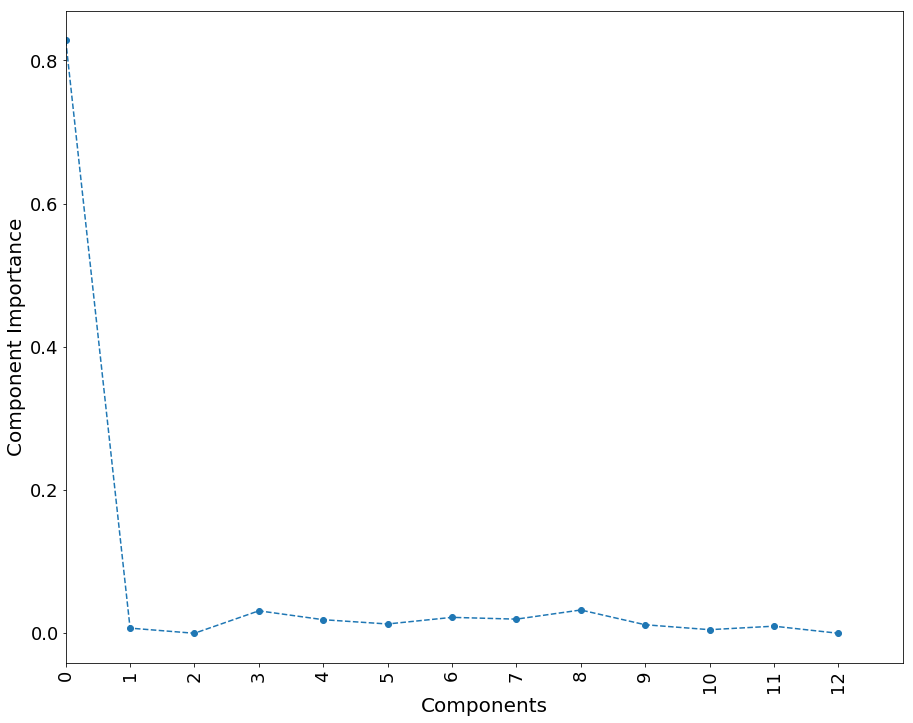

In [40]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [41]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.3           150             0          1

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.820133010883

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4027   616     4643
1           574  1399     1973
__all__    4601  2015     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.807134220073

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           984  162     1146
1           157  351      508
__all__    1141  513     1654

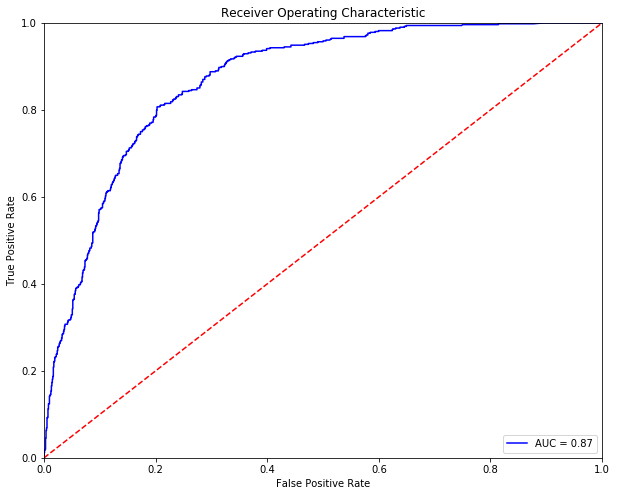

Optimal Threshold is 0.345321158759
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  231     1146
1.0         103  405      508
__all__    1018  636     1654

In [42]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [43]:
table_80_70_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

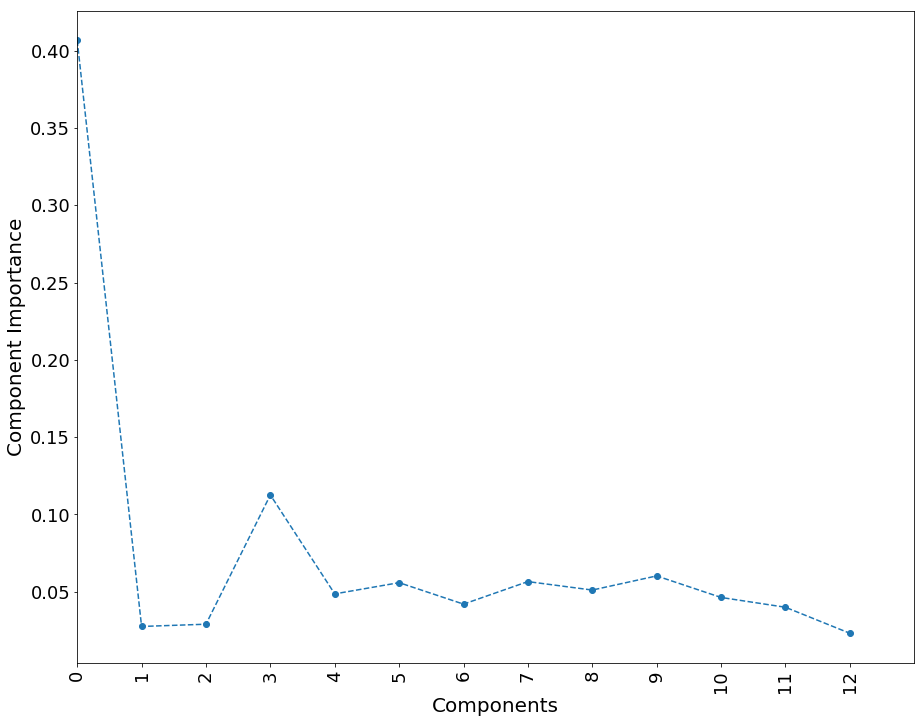

In [44]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [45]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.794588875453

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3913   730     4643
1           629  1344     1973
__all__    4542  2074     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.773276904474

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           956  190     1146
1           185  323      508
__all__    1141  513     1654

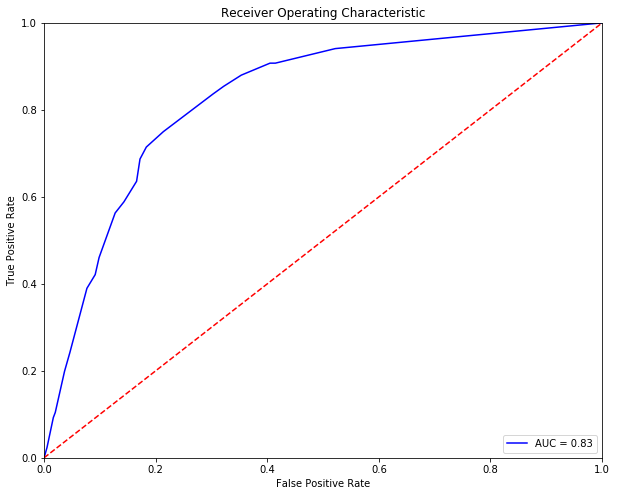

Optimal Threshold is 0.268907563025
Accuracy of Logistic Model on training data is: 0.785368802902


Predicted   0.0  1.0  __all__
Actual                       
0.0         936  210     1146
1.0         145  363      508
__all__    1081  573     1654

In [46]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [47]:
table_80_70_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [48]:
%%capture
table_80_70_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

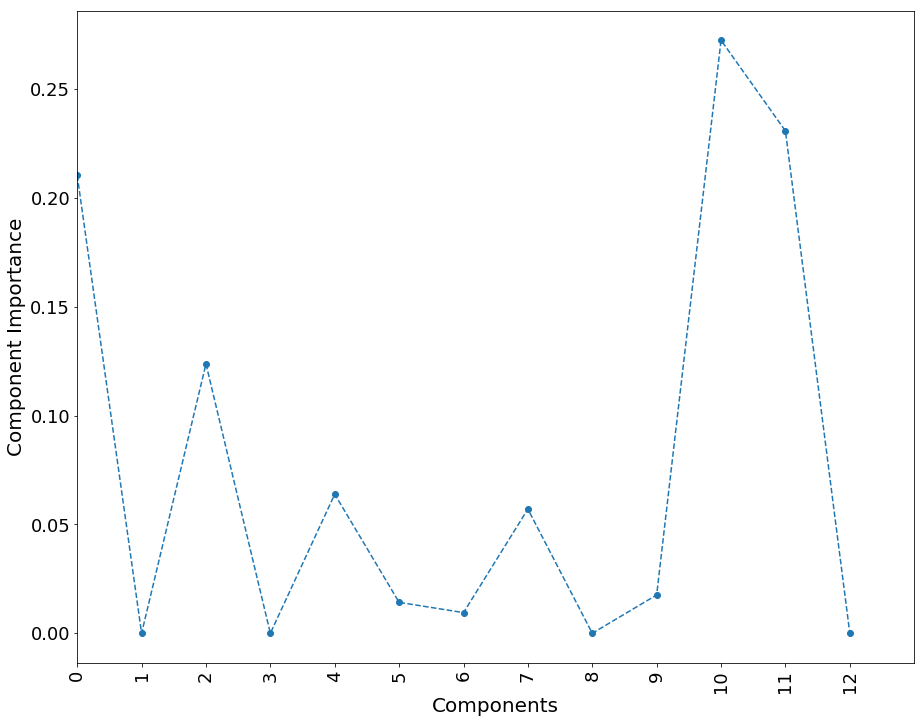

In [49]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [50]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.961457073761

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4606    37     4643
1           218  1755     1973
__all__    4824  1792     6616

Accuracy of the  Bagging  model for test data is: 0.792019347037

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           998  148     1146
1           196  312      508
__all__    1194  460     1654

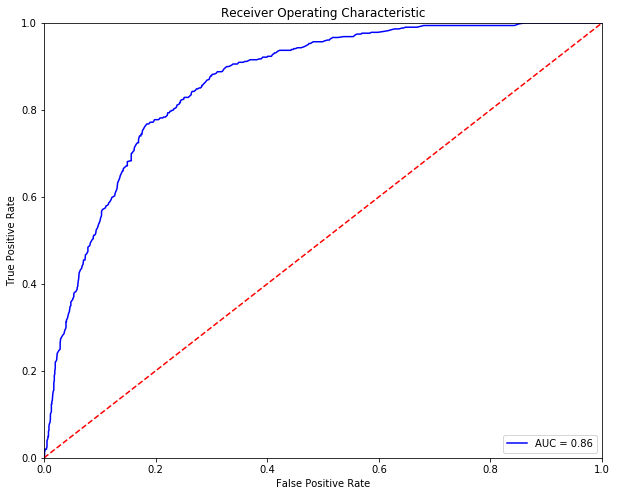

Optimal Threshold is 0.386
Accuracy of Logistic Model on training data is: 0.784159613059


Predicted   0.0  1.0  __all__
Actual                       
0.0         899  247     1146
1.0         110  398      508
__all__    1009  645     1654

In [51]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [52]:
table_80_70_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [53]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.971735187424


Predicted     0     1  __all__
Actual                        
0          4617    26     4643
1           161  1812     1973
__all__    4778  1838     6616

The test accuracy is: 0.79746070133


Predicted     0    1  __all__
Actual                       
0          1001  145     1146
1           190  318      508
__all__    1191  463     1654

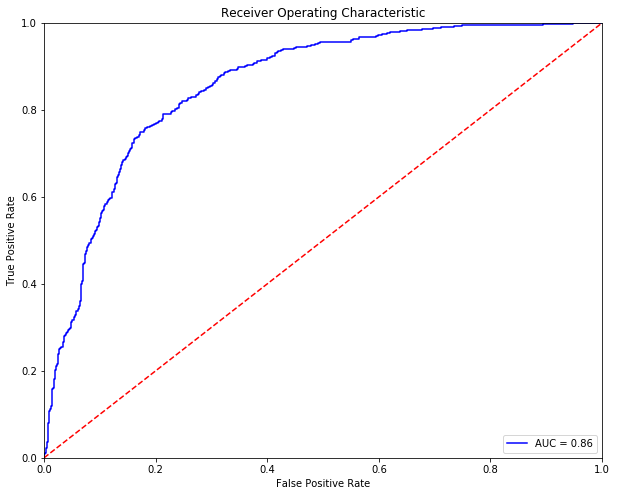

Optimal Threshold is 0.368345252182
Accuracy of Logistic Model on training data is: 0.787787182588


Predicted   0.0  1.0  __all__
Actual                       
0.0         902  244     1146
1.0         107  401      508
__all__    1009  645     1654

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [55]:
table_80_70_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [56]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.847490931004


Predicted     0     1  __all__
Actual                        
0          4051   592     4643
1           417  1556     1973
__all__    4468  2148     6616

The accuracy of the model on test data is: 0.795646916566


Predicted     0    1  __all__
Actual                       
0           952  194     1146
1           144  364      508
__all__    1096  558     1654

1408/1654 [========================>.....] - ETA: 0s

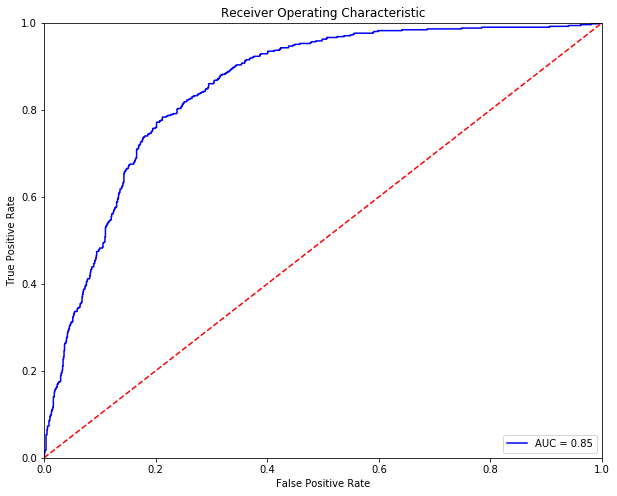

Optimal Threshold is 0.397426
Accuracy of Logistic Model on training data is: 0.782345828295


Predicted   0.0  1.0  __all__
Actual                       
0.0         896  250     1146
1.0         110  398      508
__all__    1006  648     1654

In [57]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [58]:
table_80_70_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [59]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.4min finished


The accuracy of the model on training data is: 0.812726723096


Predicted     0     1  __all__
Actual                        
0          3846   797     4643
1           442  1531     1973
__all__    4288  2328     6616

The accuracy of the model on test data is: 0.806529625151


Predicted     0    1  __all__
Actual                       
0           947  199     1146
1           121  387      508
__all__    1068  586     1654

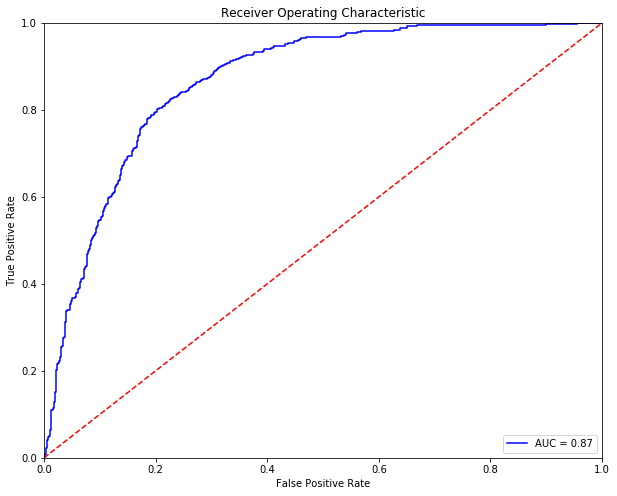

Optimal Threshold is 0.404824
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         915  231     1146
1.0         103  405      508
__all__    1018  636     1654

In [60]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [61]:
table_80_70_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [62]:
table_80_70_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1973.0  4643.0    0.0    0.0  0.000000   
LogisticRegression          0.800635  1549.0  3748.0  895.0  424.0  0.192763   
RandomForestClassifier      0.988362  1909.0  4630.0   13.0   64.0  0.002800   
AdaBoostClassifier          0.809855  1448.0  3910.0  733.0  525.0  0.157872   
GradientBoostingClassifier  0.820133  1399.0  4027.0  616.0  574.0  0.132673   
ExtraTreeClassifier         0.794589  1344.0  3913.0  730.0  629.0  0.157226   
BaggingClassifier           0.961457  1755.0  4606.0   37.0  218.0  0.007969   
VotingClassifier            0.971735  1812.0  4617.0   26.0  161.0  0.005600   
Neural Network-1            0.847491  1556.0  4051.0  592.0  417.0  0.127504   
Neural-Network-2            0.812727  1531.0  3846.0  797.0  442.0  0.171656   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.214901  
RandomForestClassifier      0.032438  
AdaBoostClassifier          0.266092  
GradientBoostingClassifier  0.290928  
ExtraTreeClassifier         0.318804  
BaggingClassifier           0.110492  
VotingClassifier            0.081602  
Neural Network-1            0.211353  
Neural-Network-2            0.224024

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.787183  273.0  1029.0  117.0  235.0  0.102094   
LogisticRegression          0.798670  395.0   926.0  220.0  113.0  0.191972   
RandomForestClassifier      0.778718  282.0  1006.0  140.0  226.0  0.122164   
AdaBoostClassifier          0.798065  365.0   955.0  191.0  143.0  0.166667   
GradientBoostingClassifier  0.807134  351.0   984.0  162.0  157.0  0.141361   
ExtraTreeClassifier         0.773277  323.0   956.0  190.0  185.0  0.165794   
BaggingClassifier           0.792019  312.0   998.0  148.0  196.0  0.129145   
VotingClassifier            0.797461  318.0  1001.0  145.0  190.0  0.126527   
Neural Network-1            0.795647  364.0   952.0  194.0  144.0  0.169284   
Neural-Network-2            0.806530  387.0   947.0  199.0  121.0  0.173647   

                                 FNR  
index                                 
KNeighborsClassifier        0.462598  
LogisticRegression          0.222441  
RandomForestClassifier      0.444882  
AdaBoostClassifier          0.281496  
GradientBoostingClassifier  0.309055  
ExtraTreeClassifier         0.364173  
BaggingClassifier           0.385827  
VotingClassifier            0.374016  
Neural Network-1            0.283465  
Neural-Network-2            0.238189

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.790206  401.0  906.0  240.0  107.0  0.209424   
LogisticRegression          0.793229  403.0  909.0  237.0  105.0  0.206806   
RandomForestClassifier      0.788392  351.0  953.0  193.0  157.0  0.168412   
AdaBoostClassifier          0.791415  402.0  907.0  239.0  106.0  0.208551   
GradientBoostingClassifier  0.798065  405.0  915.0  231.0  103.0  0.201571   
ExtraTreeClassifier         0.785369  363.0  936.0  210.0  145.0  0.183246   
BaggingClassifier           0.784160  398.0  899.0  247.0  110.0  0.215532   
VotingClassifier            0.787787  401.0  902.0  244.0  107.0  0.212914   
Neural Network-1            0.782346  398.0  896.0  250.0  110.0  0.218150   
Neural-Network-2            0.798065  405.0  915.0  231.0  103.0  0.201571   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.210630   0.289456  0.854071  
LogisticRegression          0.206693   0.479334  0.869649  
RandomForestClassifier      0.309055   0.400000  0.835648  
AdaBoostClassifier          0.208661   0.477024  0.867499  
GradientBoostingClassifier  0.202756   0.345321  0.868699  
ExtraTreeClassifier         0.285433   0.268908  0.828549  
BaggingClassifier           0.216535   0.386000  0.862925  
VotingClassifier            0.210630   0.368345  0.858154  
Neural Network-1            0.216535   0.397426  0.851858  
Neural-Network-2            0.202756   0.404824  0.866793

#### Random State 10

In [63]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.915617452326
The train/test split ratio is 80:20


In [64]:
display(X_pca_13[0:1])

array([[ 0.1092487 ,  0.09758928, -0.52784745,  0.50560657, -0.430521  ,
        -0.43954403,  0.08248622,  0.03391669, -0.09021769,  0.28432751,
         0.05267798, -0.86988474, -0.07038592]])

In [65]:
## Table to store training and test measures
table_80_70_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4647     0     4647
1             0  1969     1969
__all__    4647  1969     6616

Accuracy of the  KNN  model for test data is: 0.790205562273

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1006  136     1142
1           211  301      512
__all__    1217  437     1654

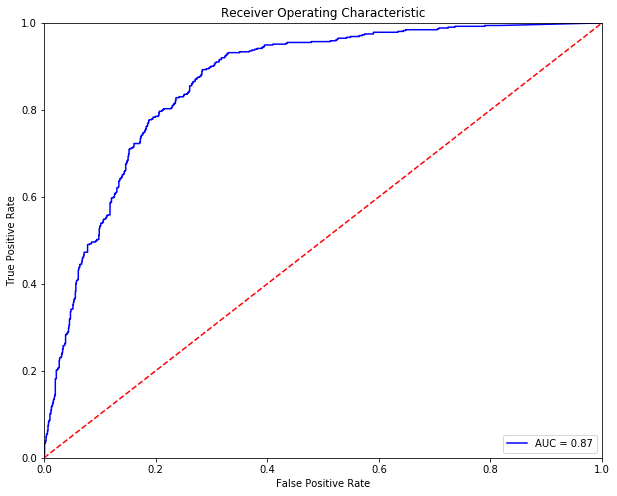

Optimal Threshold is 0.307780102703
Accuracy of Logistic Model on training data is: 0.793833131802


Predicted   0.0  1.0  __all__
Actual                       
0.0         907  235     1142
1.0         106  406      512
__all__    1013  641     1654

In [67]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [68]:
table_80_70_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [69]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.797158403869

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3780   867     4647
1           475  1494     1969
__all__    4255  2361     6616

Accuracy of the  Logistic  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           920  222     1142
1           106  406      512
__all__    1026  628     1654

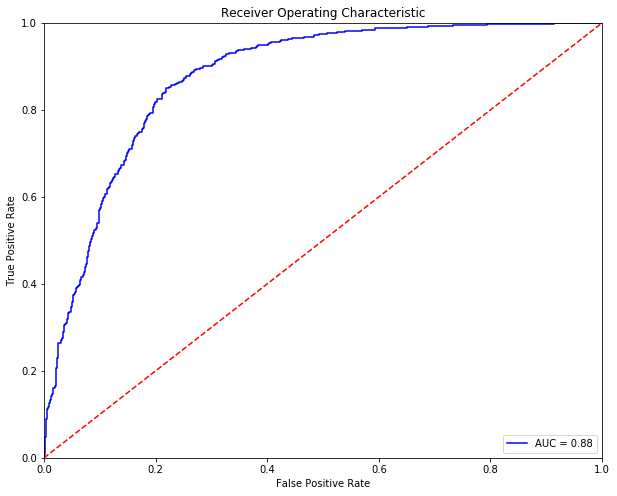

Optimal Threshold is 0.496067850355
Accuracy of Logistic Model on training data is: 0.804715840387


Predicted   0.0  1.0  __all__
Actual                       
0.0         919  223     1142
1.0         100  412      512
__all__    1019  635     1654

In [70]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [71]:
table_80_70_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [73]:
rf=RandomForestClassifier()

parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.990175332527

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4635    12     4647
1            53  1916     1969
__all__    4688  1928     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.769649334946

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           987  155     1142
1           226  286      512
__all__    1213  441     1654

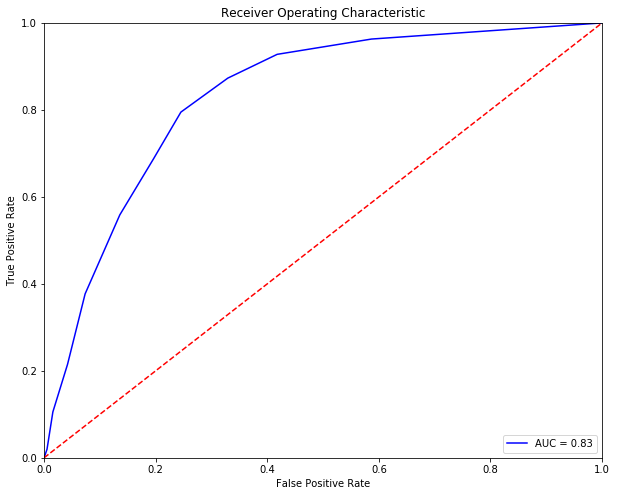

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.767835550181


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         160  352      512
__all__    1078  576     1654

In [74]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [77]:
%%capture
table_80_70_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

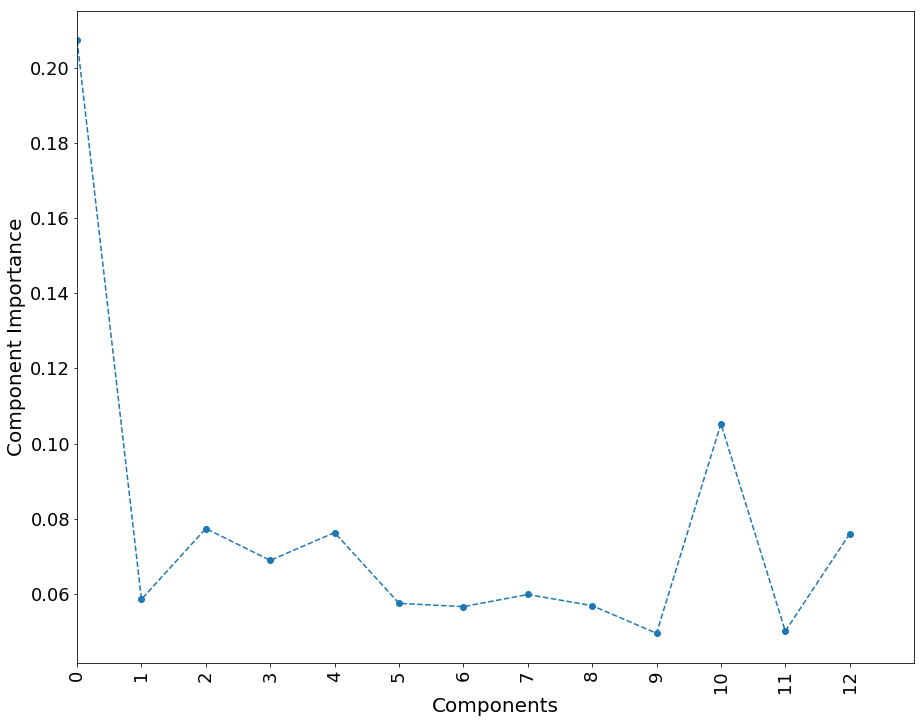

In [80]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [81]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           150             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.795495767836

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3817   830     4647
1           523  1446     1969
__all__    4340  2276     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.801088270859

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           930  212     1142
1           117  395      512
__all__    1047  607     1654

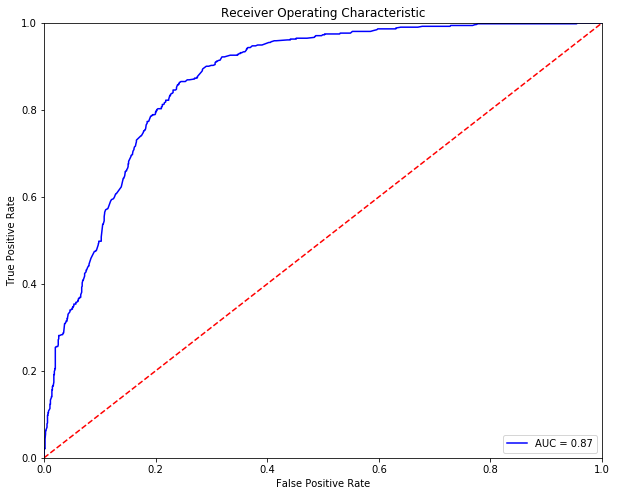

Optimal Threshold is 0.478783188272
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0         912  230     1142
1.0         104  408      512
__all__    1016  638     1654

In [82]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [83]:
table_80_70_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

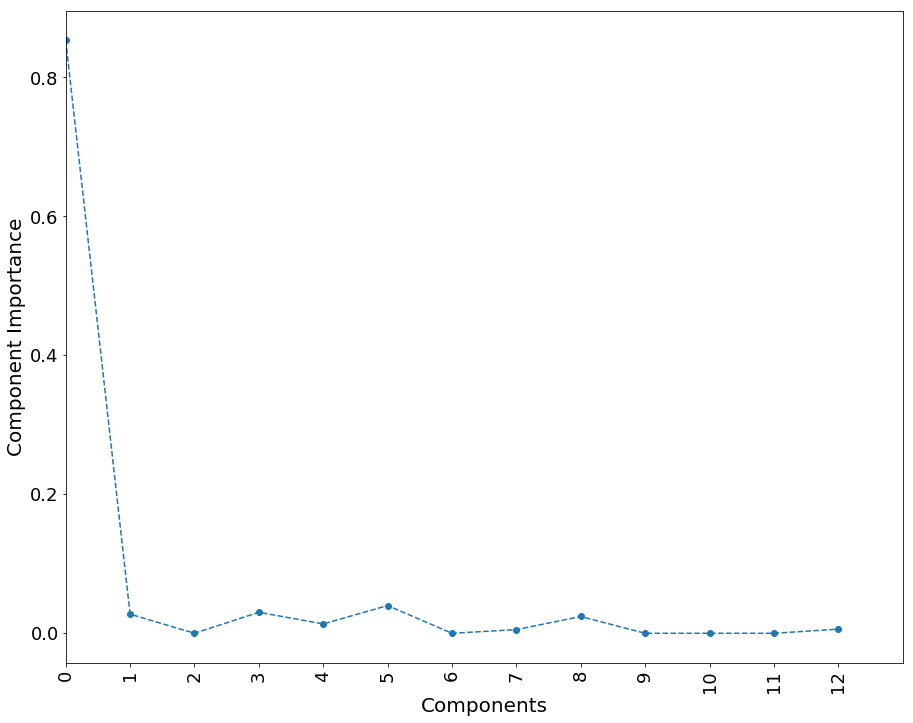

In [84]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [85]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                15   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           150             0        0.5

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.809099153567

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3995   652     4647
1           611  1358     1969
__all__    4606  2010     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.802297460701

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           965  177     1142
1           150  362      512
__all__    1115  539     1654

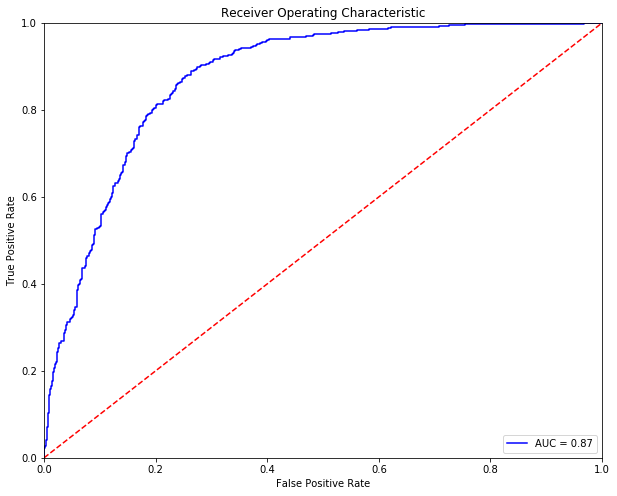

Optimal Threshold is 0.392783528232
Accuracy of Logistic Model on training data is: 0.803506650544


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  224     1142
1.0         101  411      512
__all__    1019  635     1654

In [86]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [87]:
table_80_70_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

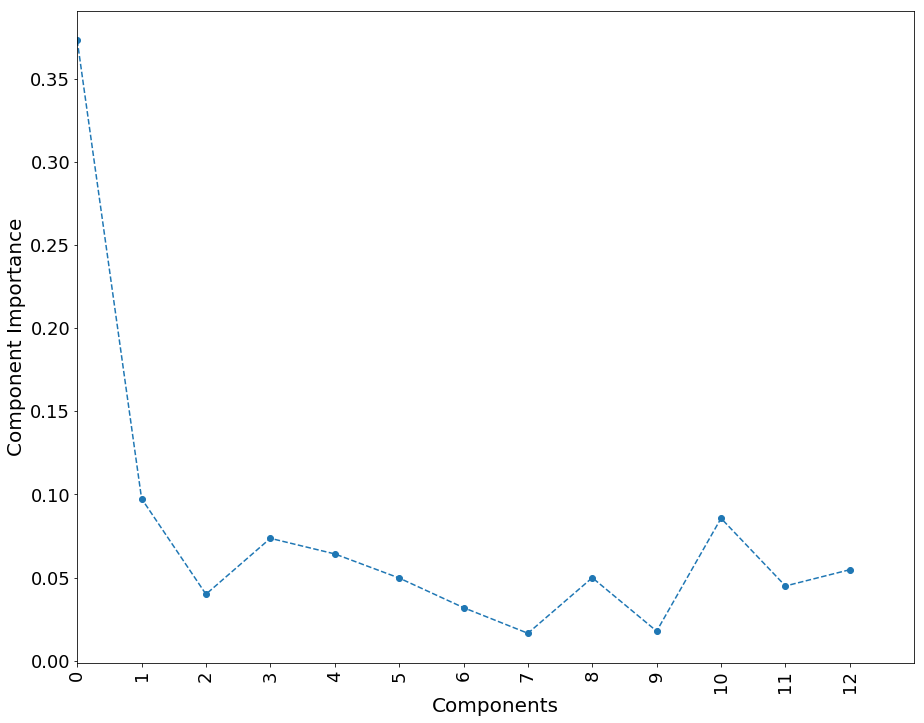

In [88]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [89]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     5                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.799123337364

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4000   647     4647
1           682  1287     1969
__all__    4682  1934     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.772067714631

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           957  185     1142
1           192  320      512
__all__    1149  505     1654

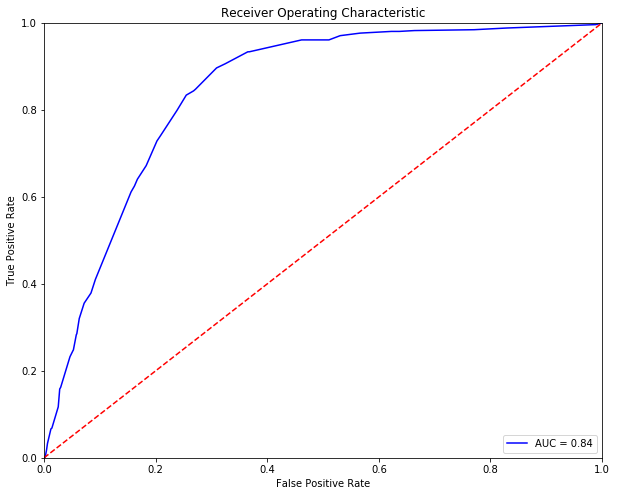

Optimal Threshold is 0.375415282392
Accuracy of Logistic Model on training data is: 0.77569528416


Predicted   0.0  1.0  __all__
Actual                       
0.0         904  238     1142
1.0         133  379      512
__all__    1037  617     1654

In [90]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [91]:
table_80_70_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [92]:
%%capture
table_80_70_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

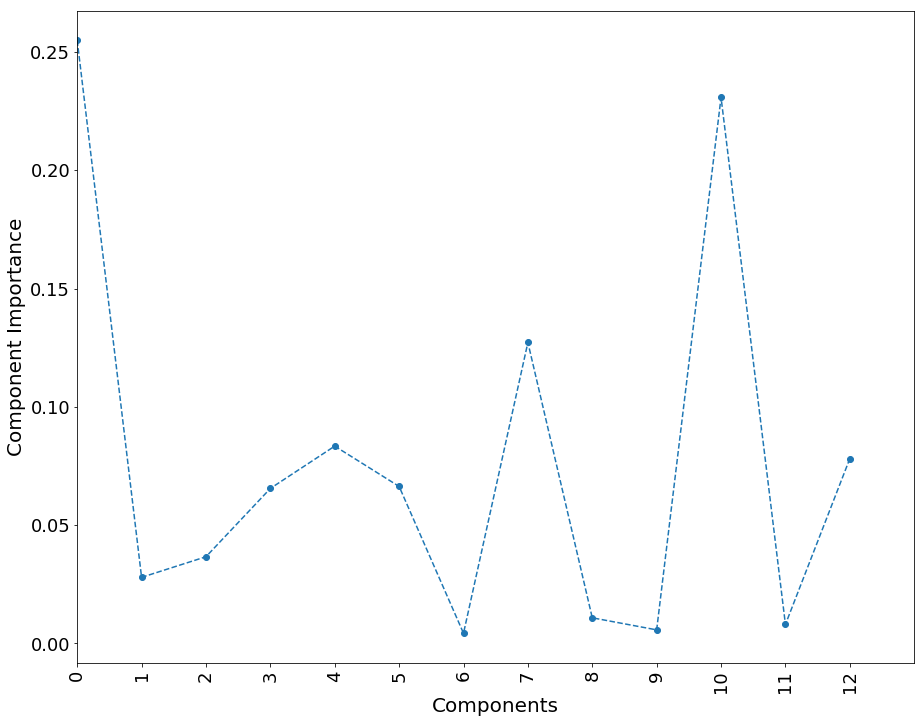

In [93]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [94]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.9611547763

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4610    37     4647
1           220  1749     1969
__all__    4830  1786     6616

Accuracy of the  Bagging  model for test data is: 0.787182587666

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           974  168     1142
1           184  328      512
__all__    1158  496     1654

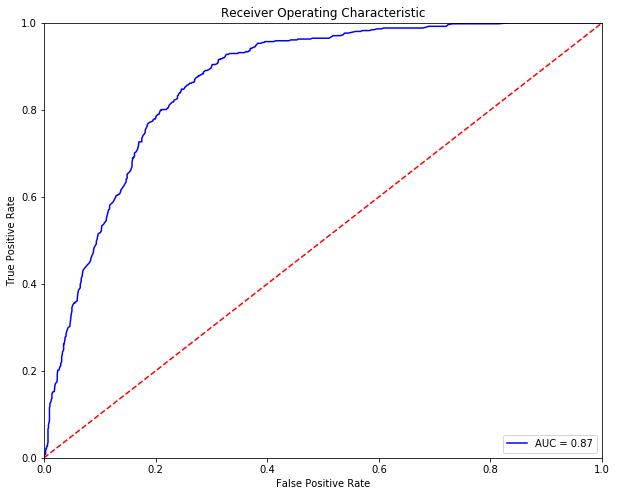

Optimal Threshold is 0.41
Accuracy of Logistic Model on training data is: 0.792623941959


Predicted   0.0  1.0  __all__
Actual                       
0.0         906  236     1142
1.0         107  405      512
__all__    1013  641     1654

In [95]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [96]:
table_80_70_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [97]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.971886336155


Predicted     0     1  __all__
Actual                        
0          4622    25     4647
1           161  1808     1969
__all__    4783  1833     6616

The test accuracy is: 0.791414752116


Predicted     0    1  __all__
Actual                       
0           980  162     1142
1           183  329      512
__all__    1163  491     1654

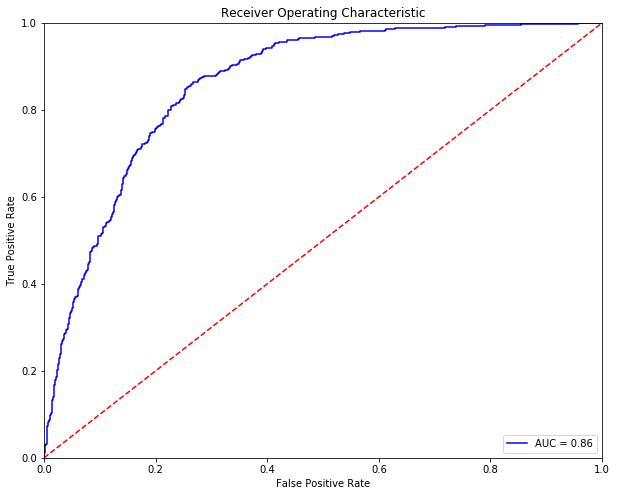

Optimal Threshold is 0.392542928925
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0         896  246     1142
1.0         112  400      512
__all__    1008  646     1654

In [98]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [99]:
table_80_70_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [100]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.846735187496


Predicted     0     1  __all__
Actual                        
0          4197   450     4647
1           564  1405     1969
__all__    4761  1855     6616

The accuracy of the model on test data is: 0.787787182588


Predicted     0    1  __all__
Actual                       
0           969  173     1142
1           178  334      512
__all__    1147  507     1654

  32/1654 [..............................] - ETA: 0s

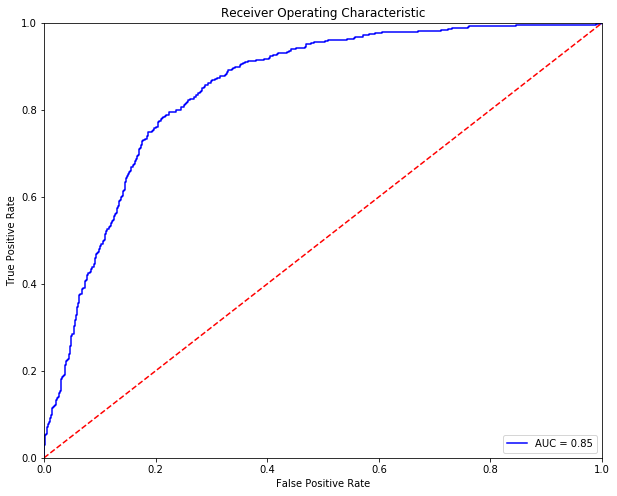

Optimal Threshold is 0.365872
Accuracy of Logistic Model on training data is: 0.784159613059


Predicted   0.0  1.0  __all__
Actual                       
0.0         896  246     1142
1.0         111  401      512
__all__    1007  647     1654

In [101]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [102]:
table_80_70_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [103]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.1min finished


The accuracy of the model on training data is: 0.813331318017


Predicted     0     1  __all__
Actual                        
0          3947   700     4647
1           535  1434     1969
__all__    4482  2134     6616

The accuracy of the model on test data is: 0.802902055623


Predicted     0    1  __all__
Actual                       
0           946  196     1142
1           130  382      512
__all__    1076  578     1654

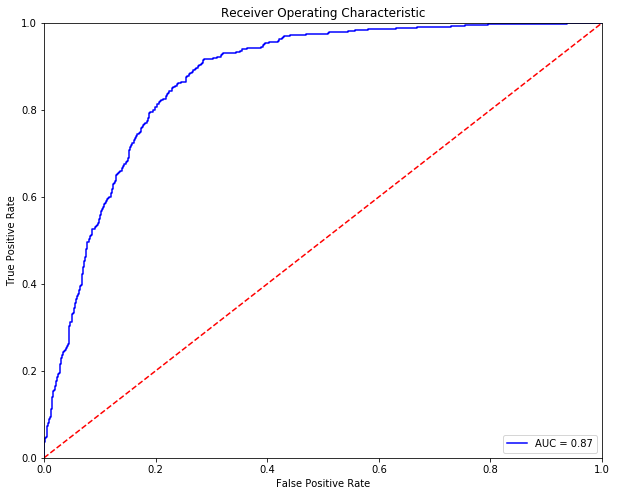

Optimal Threshold is 0.433277
Accuracy of Logistic Model on training data is: 0.80169286578


Predicted   0.0  1.0  __all__
Actual                       
0.0         916  226     1142
1.0         102  410      512
__all__    1018  636     1654

In [104]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [105]:
table_80_70_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [106]:
table_80_70_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1969.0  4647.0    0.0    0.0  0.000000   
LogisticRegression          0.797158  1494.0  3780.0  867.0  475.0  0.186572   
RandomForestClassifier      0.990175  1916.0  4635.0   12.0   53.0  0.002582   
AdaBoostClassifier          0.795496  1446.0  3817.0  830.0  523.0  0.178610   
GradientBoostingClassifier  0.809099  1358.0  3995.0  652.0  611.0  0.140306   
ExtraTreeClassifier         0.799123  1287.0  4000.0  647.0  682.0  0.139230   
BaggingClassifier           0.961155  1749.0  4610.0   37.0  220.0  0.007962   
VotingClassifier            0.971886  1808.0  4622.0   25.0  161.0  0.005380   
Neural Network-1            0.846735  1405.0  4197.0  450.0  564.0  0.096837   
Neural-Network-2            0.813331  1434.0  3947.0  700.0  535.0  0.150635   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.241239  
RandomForestClassifier      0.026917  
AdaBoostClassifier          0.265617  
GradientBoostingClassifier  0.310310  
ExtraTreeClassifier         0.346369  
BaggingClassifier           0.111732  
VotingClassifier            0.081767  
Neural Network-1            0.286440  
Neural-Network-2            0.271712

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.790206  301.0  1006.0  136.0  211.0  0.119089   
LogisticRegression          0.801693  406.0   920.0  222.0  106.0  0.194396   
RandomForestClassifier      0.769649  286.0   987.0  155.0  226.0  0.135727   
AdaBoostClassifier          0.801088  395.0   930.0  212.0  117.0  0.185639   
GradientBoostingClassifier  0.802297  362.0   965.0  177.0  150.0  0.154991   
ExtraTreeClassifier         0.772068  320.0   957.0  185.0  192.0  0.161996   
BaggingClassifier           0.787183  328.0   974.0  168.0  184.0  0.147110   
VotingClassifier            0.791415  329.0   980.0  162.0  183.0  0.141856   
Neural Network-1            0.787787  334.0   969.0  173.0  178.0  0.151489   
Neural-Network-2            0.802902  382.0   946.0  196.0  130.0  0.171629   

                                 FNR  
index                                 
KNeighborsClassifier        0.412109  
LogisticRegression          0.207031  
RandomForestClassifier      0.441406  
AdaBoostClassifier          0.228516  
GradientBoostingClassifier  0.292969  
ExtraTreeClassifier         0.375000  
BaggingClassifier           0.359375  
VotingClassifier            0.357422  
Neural Network-1            0.347656  
Neural-Network-2            0.253906

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.793833  406.0  907.0  235.0  106.0  0.205779   
LogisticRegression          0.804716  412.0  919.0  223.0  100.0  0.195271   
RandomForestClassifier      0.767836  352.0  918.0  224.0  160.0  0.196147   
AdaBoostClassifier          0.798065  408.0  912.0  230.0  104.0  0.201401   
GradientBoostingClassifier  0.803507  411.0  918.0  224.0  101.0  0.196147   
ExtraTreeClassifier         0.775695  379.0  904.0  238.0  133.0  0.208406   
BaggingClassifier           0.792624  405.0  906.0  236.0  107.0  0.206655   
VotingClassifier            0.783555  400.0  896.0  246.0  112.0  0.215412   
Neural Network-1            0.784160  401.0  896.0  246.0  111.0  0.215412   
Neural-Network-2            0.801693  410.0  916.0  226.0  102.0  0.197898   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.207031   0.307780  0.865204  
LogisticRegression          0.195312   0.496068  0.876360  
RandomForestClassifier      0.312500   0.400000  0.832456  
AdaBoostClassifier          0.203125   0.478783  0.870250  
GradientBoostingClassifier  0.197266   0.392784  0.874584  
ExtraTreeClassifier         0.259766   0.375415  0.843513  
BaggingClassifier           0.208984   0.410000  0.866588  
VotingClassifier            0.218750   0.392543  0.860772  
Neural Network-1            0.216797   0.365872  0.848012  
Neural-Network-2            0.199219   0.433277  0.873953

#### Random State 20

In [107]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.2)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920535156414
The train/test split ratio is 80:20


In [108]:
display(X_pca_13[0:1])

array([[-0.5327557 , -0.05293468,  0.17489689, -0.0108528 ,  0.30105805,
         0.0389905 ,  0.13583015, -0.32384755,  0.65499101, -0.0822117 ,
         0.18802012,  0.15884271,  0.03627151]])

In [109]:
## Table to store training and test measures
table_80_70_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [110]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4632     0     4632
1             0  1984     1984
__all__    4632  1984     6616

Accuracy of the  KNN  model for test data is: 0.799274486094

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1037  120     1157
1           212  285      497
__all__    1249  405     1654

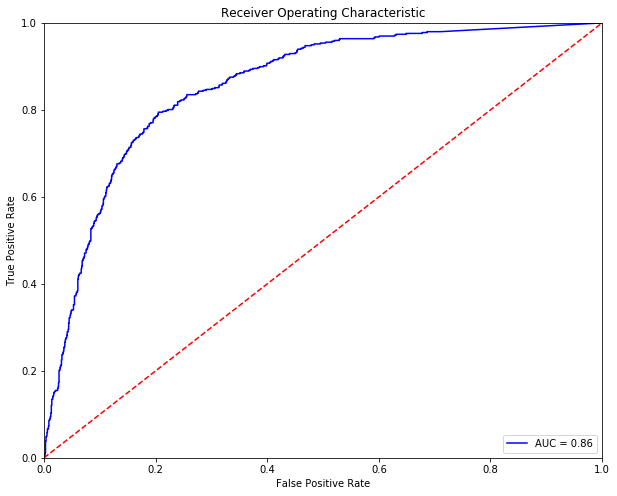

Optimal Threshold is 0.303673932814
Accuracy of Logistic Model on training data is: 0.794437726723


Predicted   0.0  1.0  __all__
Actual                       
0.0         920  237     1157
1.0         103  394      497
__all__    1023  631     1654

In [111]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [112]:
table_80_70_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [113]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.800483675937

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3798   834     4632
1           486  1498     1984
__all__    4284  2332     6616

Accuracy of the  Logistic  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           957  200     1157
1           114  383      497
__all__    1071  583     1654

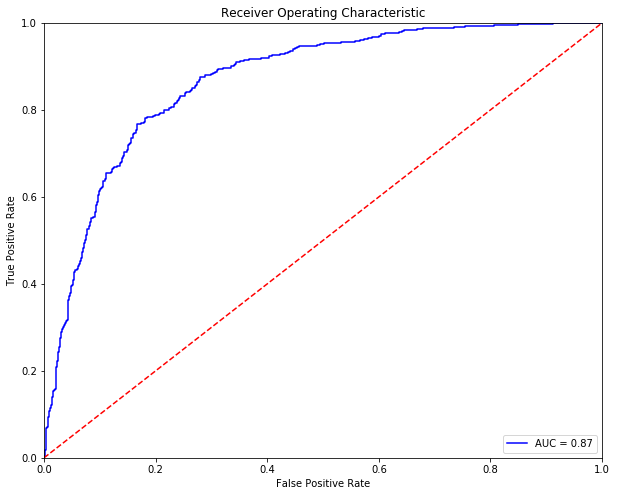

Optimal Threshold is 0.474446487422
Accuracy of Logistic Model on training data is: 0.792019347037


Predicted   0.0  1.0  __all__
Actual                       
0.0         917  240     1157
1.0         104  393      497
__all__    1021  633     1654

In [114]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [115]:
table_80_70_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [116]:
rf=RandomForestClassifier()

parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.98700120919

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4620    12     4632
1            74  1910     1984
__all__    4694  1922     6616

Accuracy of the  Random Forest Trees  model for test data is: 0.774486094317

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1020  137     1157
1           236  261      497
__all__    1256  398     1654

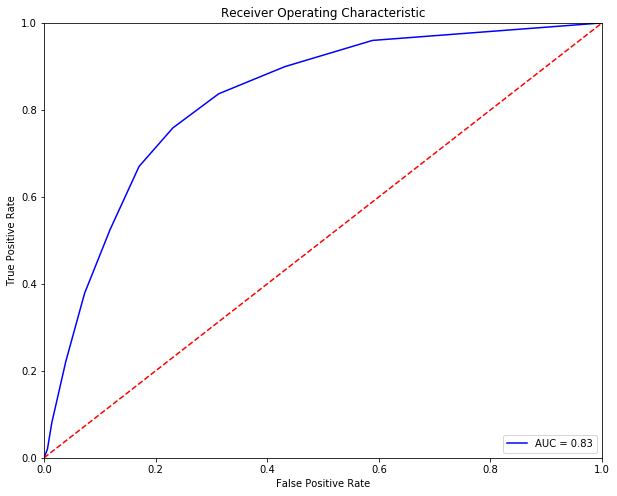

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.781741233374


Predicted   0.0  1.0  __all__
Actual                       
0.0         960  197     1157
1.0         164  333      497
__all__    1124  530     1654

In [117]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [118]:
%%capture
table_80_70_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

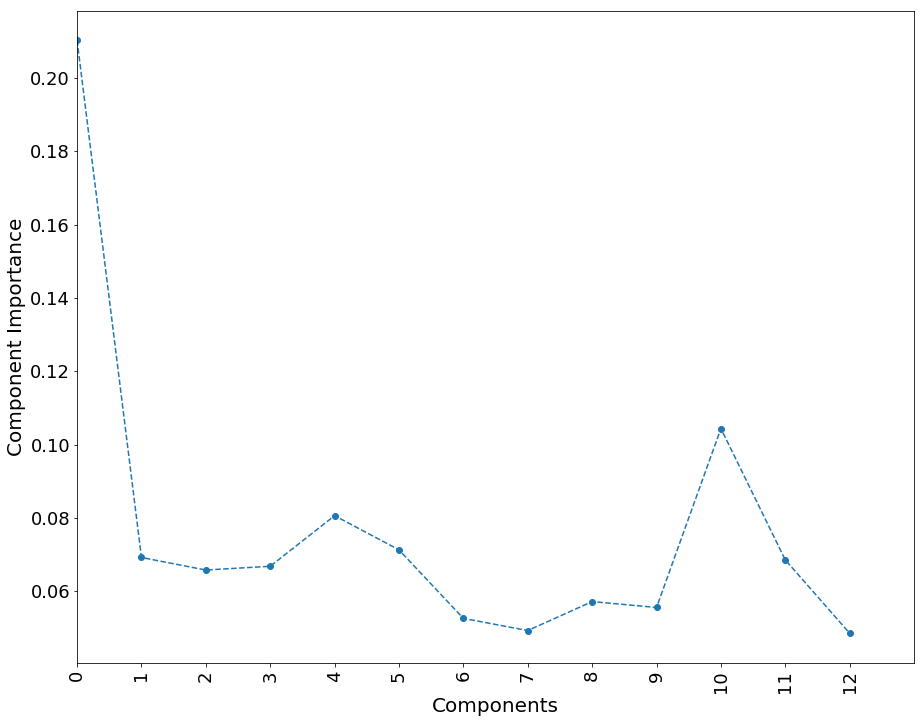

In [119]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [120]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            1.5            50             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809552599758

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4028   604     4632
1           656  1328     1984
__all__    4684  1932     6616

Accuracy of the  AdaBoostClassifier  model for test data is: 0.802902055623

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           996  161     1157
1           165  332      497
__all__    1161  493     1654

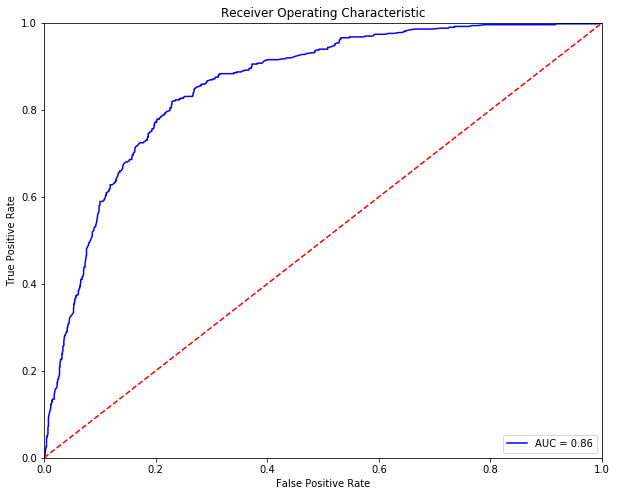

Optimal Threshold is 0.49014365763
Accuracy of Logistic Model on training data is: 0.787787182588


Predicted   0.0  1.0  __all__
Actual                       
0.0         912  245     1157
1.0         106  391      497
__all__    1018  636     1654

In [121]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [122]:
table_80_70_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

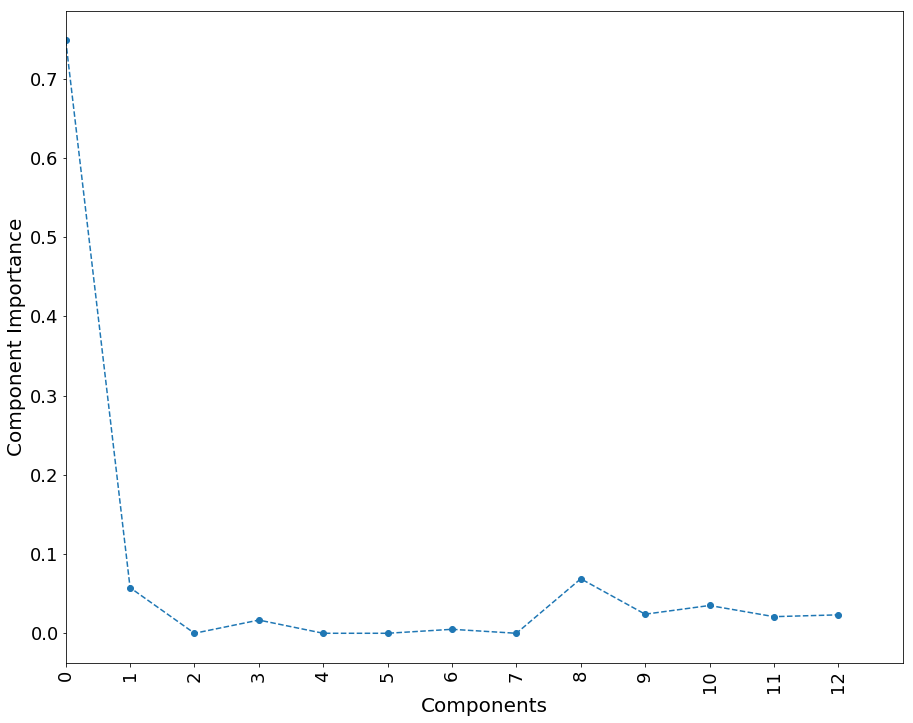

In [123]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [124]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.2           150             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.815145102781

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3993   639     4632
1           584  1400     1984
__all__    4577  2039     6616

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.814993954051

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           998  159     1157
1           147  350      497
__all__    1145  509     1654

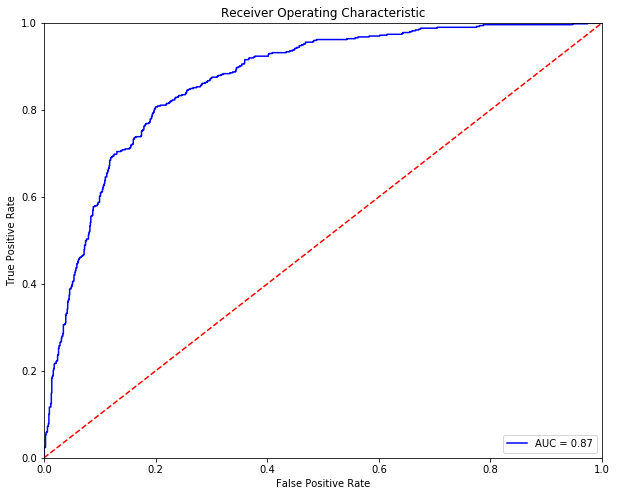

Optimal Threshold is 0.392399560601
Accuracy of Logistic Model on training data is: 0.80169286578


Predicted   0.0  1.0  __all__
Actual                       
0.0         928  229     1157
1.0          99  398      497
__all__    1027  627     1654

In [125]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [126]:
table_80_70_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

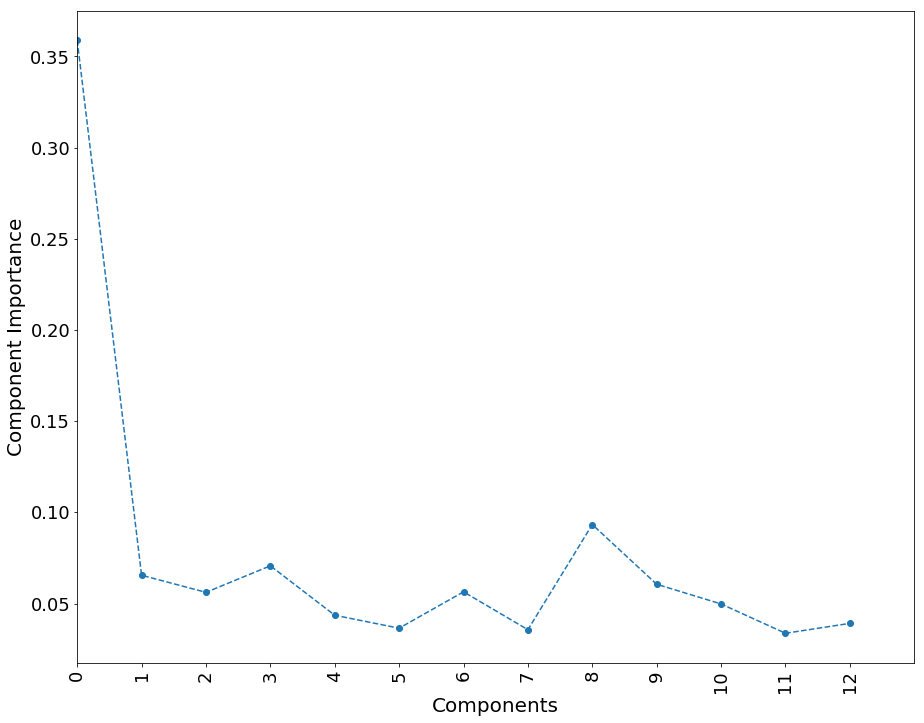

In [127]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [128]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.803960096735

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3880   752     4632
1           545  1439     1984
__all__    4425  2191     6616

Accuracy of the  Extra Decision Tree  model for test data is: 0.781741233374

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0           956  201     1157
1           160  337      497
__all__    1116  538     1654

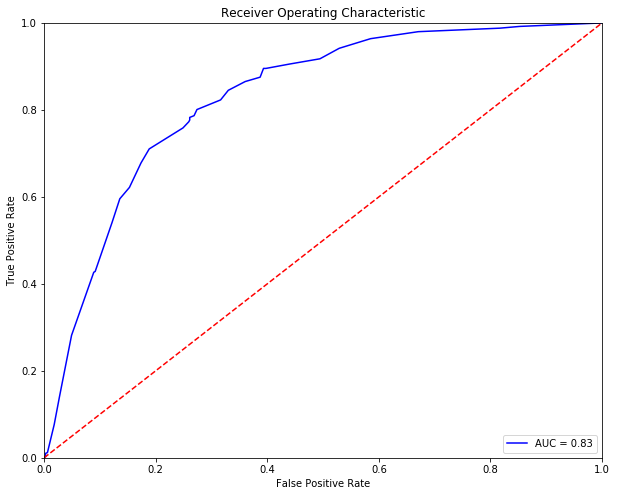

Optimal Threshold is 0.413173652695
Accuracy of Logistic Model on training data is: 0.781136638452


Predicted   0.0  1.0  __all__
Actual                       
0.0         939  218     1157
1.0         144  353      497
__all__    1083  571     1654

In [129]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [130]:
table_80_70_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [131]:
%%capture
table_80_70_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

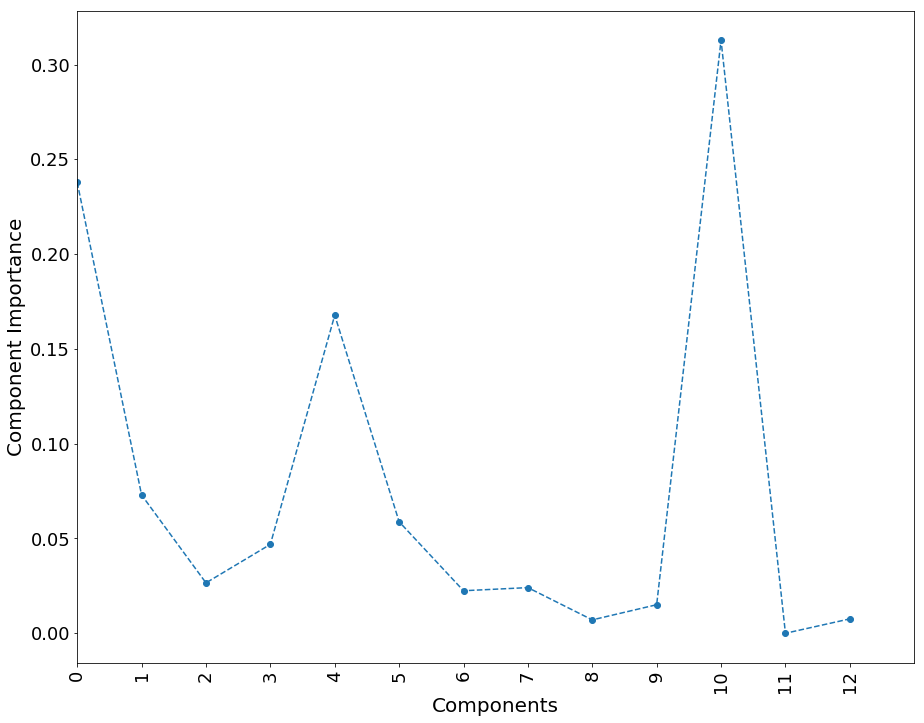

In [132]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [133]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[1000,200], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.3          1000   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.935912938331

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4527   105     4632
1           319  1665     1984
__all__    4846  1770     6616

Accuracy of the  Bagging  model for test data is: 0.804111245466

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1005  152     1157
1           172  325      497
__all__    1177  477     1654

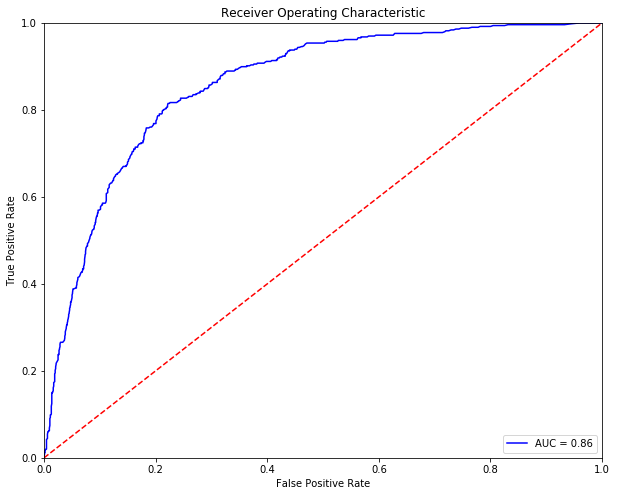

Optimal Threshold is 0.398
Accuracy of Logistic Model on training data is: 0.792623941959


Predicted   0.0  1.0  __all__
Actual                       
0.0         918  239     1157
1.0         104  393      497
__all__    1022  632     1654

In [134]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [135]:
table_80_70_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [136]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.971130592503


Predicted     0     1  __all__
Actual                        
0          4605    27     4632
1           164  1820     1984
__all__    4769  1847     6616

The test accuracy is: 0.809552599758


Predicted     0    1  __all__
Actual                       
0          1008  149     1157
1           166  331      497
__all__    1174  480     1654

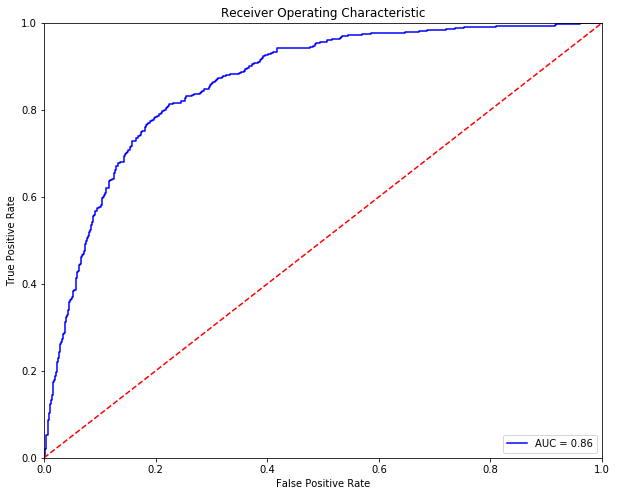

Optimal Threshold is 0.368281428703
Accuracy of Logistic Model on training data is: 0.791414752116


Predicted   0.0  1.0  __all__
Actual                       
0.0         916  241     1157
1.0         104  393      497
__all__    1020  634     1654

In [137]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [138]:
table_80_70_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [139]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.852176541717


Predicted     0     1  __all__
Actual                        
0          4244   388     4632
1           590  1394     1984
__all__    4834  1782     6616

The accuracy of the model on test data is: 0.798669891173


Predicted     0    1  __all__
Actual                       
0          1009  148     1157
1           185  312      497
__all__    1194  460     1654

 832/1654 [==============>...............] - ETA: 0s

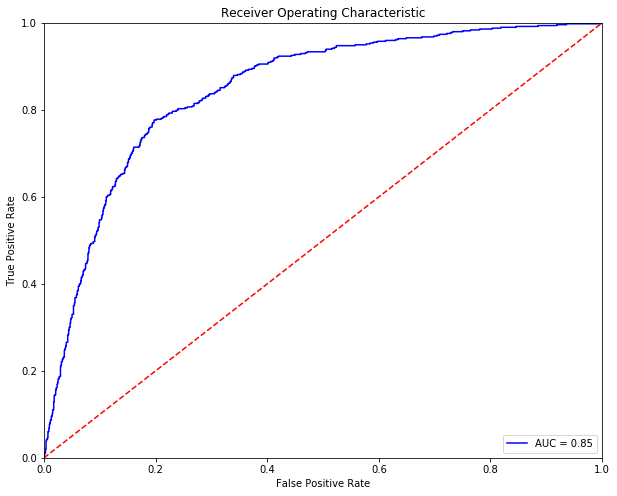

Optimal Threshold is 0.326952
Accuracy of Logistic Model on training data is: 0.784764207981


Predicted   0.0  1.0  __all__
Actual                       
0.0         909  248     1157
1.0         108  389      497
__all__    1017  637     1654

In [140]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [141]:
table_80_70_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [142]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished


The accuracy of the model on training data is: 0.811668681983


Predicted     0     1  __all__
Actual                        
0          3937   695     4632
1           551  1433     1984
__all__    4488  2128     6616

The accuracy of the model on test data is: 0.808948004837


Predicted     0    1  __all__
Actual                       
0           983  174     1157
1           142  355      497
__all__    1125  529     1654

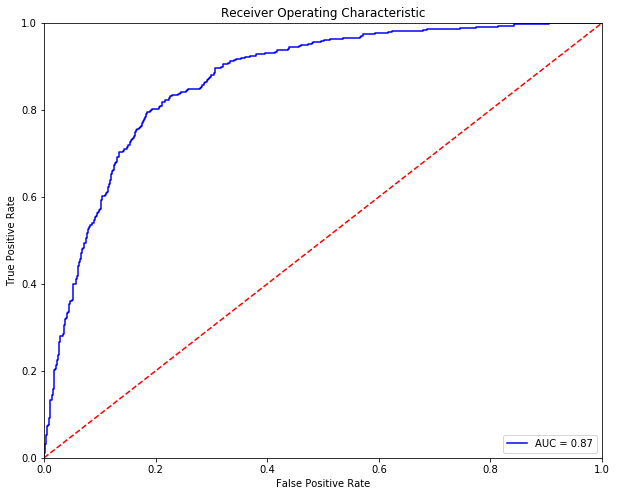

Optimal Threshold is 0.316886
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0         934  223     1157
1.0          99  398      497
__all__    1033  621     1654

In [143]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [144]:
table_80_70_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_70_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_70_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [145]:
table_80_70_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_70_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_70_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_80_70_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1984.0  4632.0    0.0    0.0  0.000000   
LogisticRegression          0.800484  1498.0  3798.0  834.0  486.0  0.180052   
RandomForestClassifier      0.987001  1910.0  4620.0   12.0   74.0  0.002591   
AdaBoostClassifier          0.809553  1328.0  4028.0  604.0  656.0  0.130397   
GradientBoostingClassifier  0.815145  1400.0  3993.0  639.0  584.0  0.137953   
ExtraTreeClassifier         0.803960  1439.0  3880.0  752.0  545.0  0.162349   
BaggingClassifier           0.935913  1665.0  4527.0  105.0  319.0  0.022668   
VotingClassifier            0.971131  1820.0  4605.0   27.0  164.0  0.005829   
Neural Network-1            0.852177  1394.0  4244.0  388.0  590.0  0.083765   
Neural-Network-2            0.811669  1433.0  3937.0  695.0  551.0  0.150043   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.244960  
RandomForestClassifier      0.037298  
AdaBoostClassifier          0.330645  
GradientBoostingClassifier  0.294355  
ExtraTreeClassifier         0.274698  
BaggingClassifier           0.160786  
VotingClassifier            0.082661  
Neural Network-1            0.297379  
Neural-Network-2            0.277722

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.799274  285.0  1037.0  120.0  212.0  0.103717   
LogisticRegression          0.810157  383.0   957.0  200.0  114.0  0.172861   
RandomForestClassifier      0.774486  261.0  1020.0  137.0  236.0  0.118410   
AdaBoostClassifier          0.802902  332.0   996.0  161.0  165.0  0.139153   
GradientBoostingClassifier  0.814994  350.0   998.0  159.0  147.0  0.137424   
ExtraTreeClassifier         0.781741  337.0   956.0  201.0  160.0  0.173725   
BaggingClassifier           0.804111  325.0  1005.0  152.0  172.0  0.131374   
VotingClassifier            0.809553  331.0  1008.0  149.0  166.0  0.128781   
Neural Network-1            0.798670  312.0  1009.0  148.0  185.0  0.127917   
Neural-Network-2            0.808948  355.0   983.0  174.0  142.0  0.150389   

                                 FNR  
index                                 
KNeighborsClassifier        0.426559  
LogisticRegression          0.229376  
RandomForestClassifier      0.474849  
AdaBoostClassifier          0.331992  
GradientBoostingClassifier  0.295775  
ExtraTreeClassifier         0.321932  
BaggingClassifier           0.346076  
VotingClassifier            0.334004  
Neural Network-1            0.372233  
Neural-Network-2            0.285714

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP     TN     FP     FN       FPR  \
index                                                                        
KNeighborsClassifier        0.794438  394.0  920.0  237.0  103.0  0.204840   
LogisticRegression          0.792019  393.0  917.0  240.0  104.0  0.207433   
RandomForestClassifier      0.781741  333.0  960.0  197.0  164.0  0.170268   
AdaBoostClassifier          0.787787  391.0  912.0  245.0  106.0  0.211755   
GradientBoostingClassifier  0.801693  398.0  928.0  229.0   99.0  0.197926   
ExtraTreeClassifier         0.781137  353.0  939.0  218.0  144.0  0.188418   
BaggingClassifier           0.792624  393.0  918.0  239.0  104.0  0.206569   
VotingClassifier            0.791415  393.0  916.0  241.0  104.0  0.208297   
Neural Network-1            0.784764  389.0  909.0  248.0  108.0  0.214347   
Neural-Network-2            0.805320  398.0  934.0  223.0   99.0  0.192740   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.207243   0.303674  0.856059  
LogisticRegression          0.209256   0.474446  0.868021  
RandomForestClassifier      0.329980   0.400000  0.826904  
AdaBoostClassifier          0.213280   0.490144  0.856976  
GradientBoostingClassifier  0.199195   0.392400  0.868843  
ExtraTreeClassifier         0.289738   0.413174  0.828931  
BaggingClassifier           0.209256   0.398000  0.859092  
VotingClassifier            0.209256   0.368281  0.862758  
Neural Network-1            0.217304   0.326952  0.846809  
Neural-Network-2            0.199195   0.316886  0.869565

In [146]:
table_80_70_PCA_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_70_PCA_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_80_70_PCA_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

In [147]:
table_80_70_PCA_train_avg['accuracy']=(table_80_70_PCA_0_train['accuracy']+table_80_70_PCA_10_train['accuracy']+table_80_70_PCA_20_train['accuracy'])/3.0
table_80_70_PCA_train_avg['FPR']=(table_80_70_PCA_0_train['FPR']+table_80_70_PCA_10_train['FPR']+table_80_70_PCA_20_train['FPR'])/3.0
table_80_70_PCA_train_avg['FNR']=(table_80_70_PCA_0_train['FNR']+table_80_70_PCA_10_train['FNR']+table_80_70_PCA_20_train['FNR'])/3.0

In [148]:
table_80_70_PCA_test_avg['accuracy']=(table_80_70_PCA_0_test['accuracy']+table_80_70_PCA_10_test['accuracy']+table_80_70_PCA_20_test['accuracy'])/3.0
table_80_70_PCA_test_avg['FPR']=(table_80_70_PCA_0_test['FPR']+table_80_70_PCA_10_test['FPR']+table_80_70_PCA_20_test['FPR'])/3.0
table_80_70_PCA_test_avg['FNR']=(table_80_70_PCA_0_test['FNR']+table_80_70_PCA_10_test['FNR']+table_80_70_PCA_20_test['FNR'])/3.0

In [149]:
table_80_70_PCA_test_roc_avg['accuracy']=(table_80_70_PCA_0_test_roc['accuracy']+table_80_70_PCA_10_test_roc['accuracy']+table_80_70_PCA_20_test_roc['accuracy'])/3.0
table_80_70_PCA_test_roc_avg['FPR']=(table_80_70_PCA_0_test_roc['FPR']+table_80_70_PCA_10_test_roc['FPR']+table_80_70_PCA_20_test_roc['FPR'])/3.0
table_80_70_PCA_test_roc_avg['FNR']=(table_80_70_PCA_0_test_roc['FNR']+table_80_70_PCA_10_test_roc['FNR']+table_80_70_PCA_20_test_roc['FNR'])/3.0
table_80_70_PCA_test_roc_avg['auc']=(table_80_70_PCA_0_test_roc['auc']+table_80_70_PCA_10_test_roc['auc']+table_80_70_PCA_20_test_roc['auc'])/3.0

In [150]:
print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_80_70_PCA_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_80_70_PCA_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_70_PCA_test_roc_avg)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        1.000000  0.000000  0.000000
LogisticRegression          0.799426  0.186462  0.233700
RandomForestClassifier      0.988513  0.002658  0.032218
AdaBoostClassifier          0.804968  0.155626  0.287451
GradientBoostingClassifier  0.814792  0.136977  0.298531
ExtraTreeClassifier         0.799224  0.152935  0.313290
BaggingClassifier           0.952842  0.012867  0.127670
VotingClassifier            0.971584  0.005603  0.082010
Neural Network-1            0.848801  0.102702  0.265057
Neural-Network-2            0.812576  0.157445  0.257819

Comparision Table for Test Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        0.792221  0.108300  0.433756
LogisticRegression          0.803507  0.186410  0.219616
RandomForestClassifier      0.774285  0.125434  0.453712
AdaBoostClassifier          0.800685  0.163820  0.280668
GradientBoostingClassifier  0.808142  0.144592  0.299266
ExtraTreeClassifier         0.775695  0.167172  0.353702
BaggingClassifier           0.794438  0.135876  0.363759
VotingClassifier            0.799476  0.132388  0.355147
Neural Network-1            0.794035  0.149563  0.334451
Neural-Network-2            0.806127  0.165222  0.259270

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy       FPR       FNR       auc
index                                                             
KNeighborsClassifier        0.792825  0.206681  0.208302  0.858445
LogisticRegression          0.796655  0.203170  0.203754  0.871343
RandomForestClassifier      0.779323  0.178276  0.317178  0.831669
AdaBoostClassifier          0.792422  0.207236  0.208355  0.864908
GradientBoostingClassifier  0.801088  0.198548  0.199739  0.870709
ExtraTreeClassifier         0.780734  0.193357  0.278312  0.833664
BaggingClassifier           0.789802  0.209585  0.211592  0.862869
VotingClassifier            0.787586  0.212208  0.212878  0.860562
Neural Network-1            0.783757  0.215970  0.216879  0.848893
Neural-Network-2            0.801693  0.197403  0.200390  0.870104

### <a id='1.D' style="text-decoration : none; color : #000000;">D. 70:30 Train Test split with PCA </a>

#### Random State 0

In [151]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_0.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC        PAR  \
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  4607  77.507923   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   169   5.840237   

                                                          PAS         LEN  \
Source_User                                                                 
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  40.245713  100.283265   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   5.597633  149.763314   

                                                            BYS           BYR  \
Source_User                                                                     
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  6930.568483  89947.788800   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...  1016.976331   3222.147929   

                                                        SP     DP  NAPP  SIP  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  3901.0  113.0    58   86   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...   168.0    4.0     9   11   

                                                     DIP          TDIF  0000  \
Source_User                                                                    
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...  1116   1646.597569   167   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    16  40005.674556     0   

                                                    0100  0200  0300  0400  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   295   328   198   223   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     0   

                                                    0500  0600  0700  0800  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   135   144   145   194   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0     8   

                                                    0900  1000  1100  1200  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   197   196   178   120   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     8     0     0    39   

                                                    1300  1400  1500  1600  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   145   118   224   172   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...    48    40    10     4   

                                                    1700  1800  1900  2000  \
Source_User                                                                  
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   241   246   151   165   
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     4     2     6     0   

                                                    2100  2200  2300  
Source_User                                                           
bb98d45a9bd0c40362a3ec37503c10b8238194752d35574...   177   134   314  
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e...     0     0     0

1 -> Infected
0 -> Uninfected


Source_User
bb98d45a9bd0c40362a3ec37503c10b8238194752d355742cd3ea35221dc98b1    1
36d9d88841607ef5b1614c98854aadf57ca7de84854e90e215137c4ad8c46fc5    0
56a003f863f8cc9342216fa01a3ab0aebf4a04ed0dd8d5b89a95f779cc707dd5    1
f894aec69ce612e29505d6d3cd9112bbe39d6a46e7da2682d14a1cbd9c4cd297    0
9aadb359b9763e3d68e62ad3c406245fcf0bc4919395dbf42532e49d8b5aa02d    1
dbea3804991397c518e0198f2b63ecab35cbf38083cb5e19bb9d4b4f4bacaa2d    1
f2327a8577d940bf7100353fce41bbde184c6e4ead193ab60986bb3ef2551718    1
d815eb7ef3af2a56e8260b0b3a6bb3c1bf70c625619caa930cff27beced41ea1    1
ae3fe786080d0c4a0d3520152bb59d60836d2ae6fdb4870a1879b98ea7ec02fc    1
45b5cf89d8e8ff70ce05570a97d5ff05783283281eade7d8b736c94a24cfb16c    1
Name: Target, dtype: int64

Variance explained using 13 components is: 0.922348229056
The train/test split ratio is 70:30


In [152]:
display(X_pca_13[0:1])

array([[ 0.51069587, -0.17479937, -0.18757661, -0.21230661, -0.83309263,
         0.55899882,  0.157608  , -0.1043382 ,  0.82023985, -0.32529949,
         0.30768313, -0.3310058 , -1.04421636]])

In [153]:
## Table to store training and test measures
table_70_70_PCA_0_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_0_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_0_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [154]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           30  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4078     0     4078
1             0  1711     1711
__all__    4078  1711     5789

Accuracy of the  KNN  model for test data is: 0.7843611447

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1537  174     1711
1           361  409      770
__all__    1898  583     2481

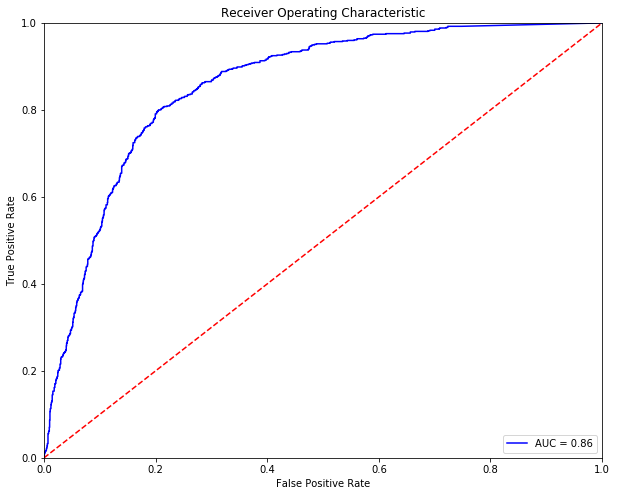

Optimal Threshold is 0.269483786617
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         157  613      770
__all__    1520  961     2481

In [155]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [156]:
table_70_70_PCA_0_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [157]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  0.001

Accuracy of the  Logistic  model for the training data is: 0.798756261876

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3291   787     4078
1           378  1333     1711
__all__    3669  2120     5789

Accuracy of the  Logistic  model for test data is: 0.803708182185

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1398  313     1711
1           174  596      770
__all__    1572  909     2481

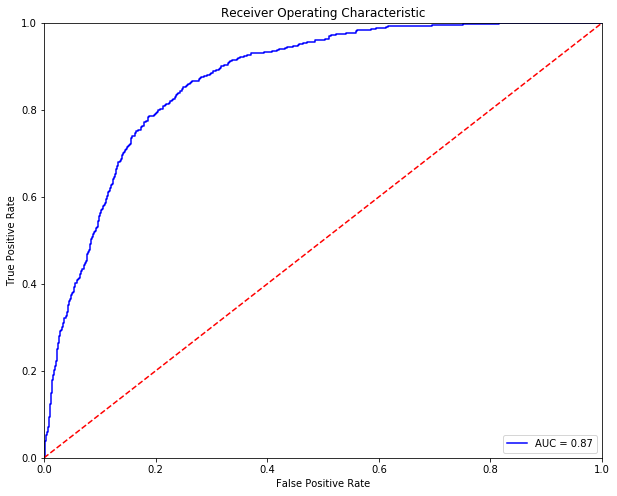

Optimal Threshold is 0.477591048374
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1363  348     1711
1.0         157  613      770
__all__    1520  961     2481

In [158]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [159]:
table_70_70_PCA_0_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [161]:
rf=RandomForestClassifier()

parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.985144239074

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4062    16     4078
1            70  1641     1711
__all__    4132  1657     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.771060056429

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1511  200     1711
1           368  402      770
__all__    1879  602     2481

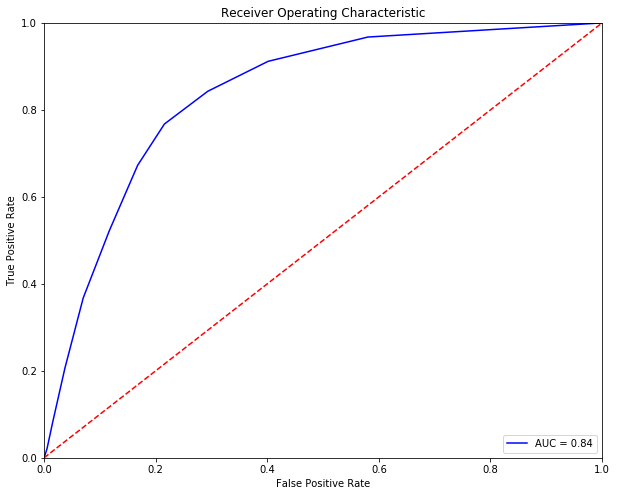

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.782748891576


Predicted   0.0  1.0  __all__
Actual                       
0.0        1424  287     1711
1.0         252  518      770
__all__    1676  805     2481

In [162]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [163]:
%%capture
table_70_70_PCA_0_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

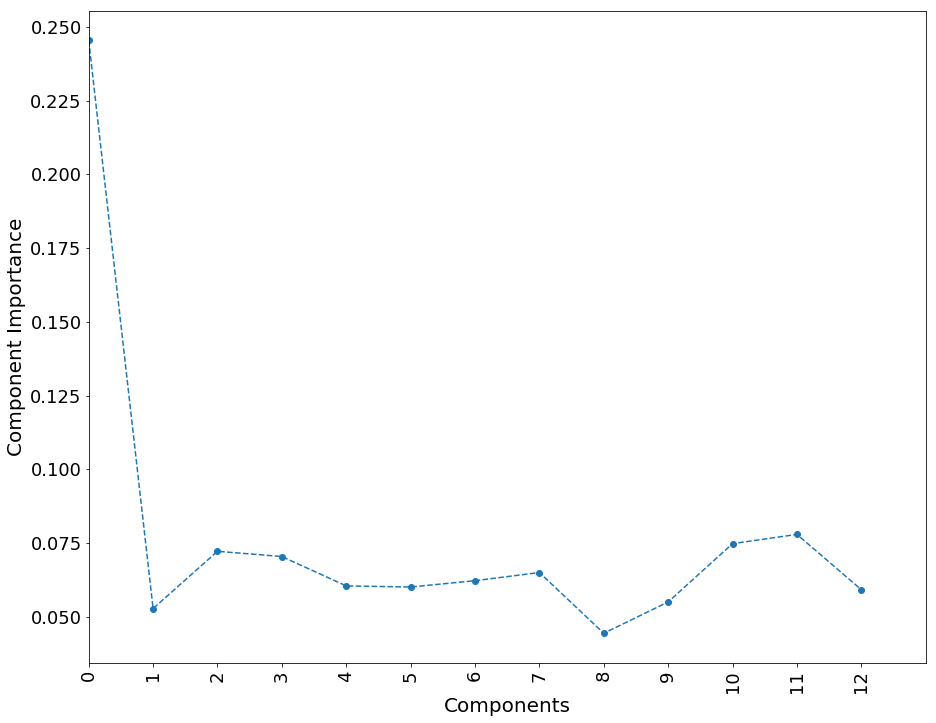

In [164]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [165]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.809120746243

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3448   630     4078
1           475  1236     1711
__all__    3923  1866     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.80612656187

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1450  261     1711
1           220  550      770
__all__    1670  811     2481

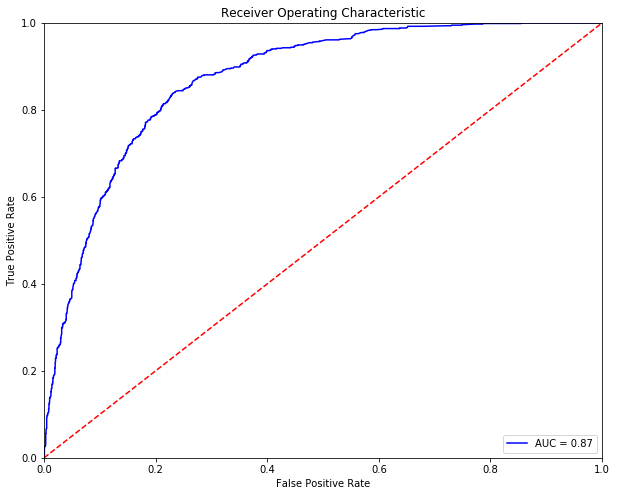

Optimal Threshold is 0.476123654157
Accuracy of Logistic Model on training data is: 0.795243853285


Predicted   0.0  1.0  __all__
Actual                       
0.0        1361  350     1711
1.0         158  612      770
__all__    1519  962     2481

In [166]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [167]:
table_70_70_PCA_0_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

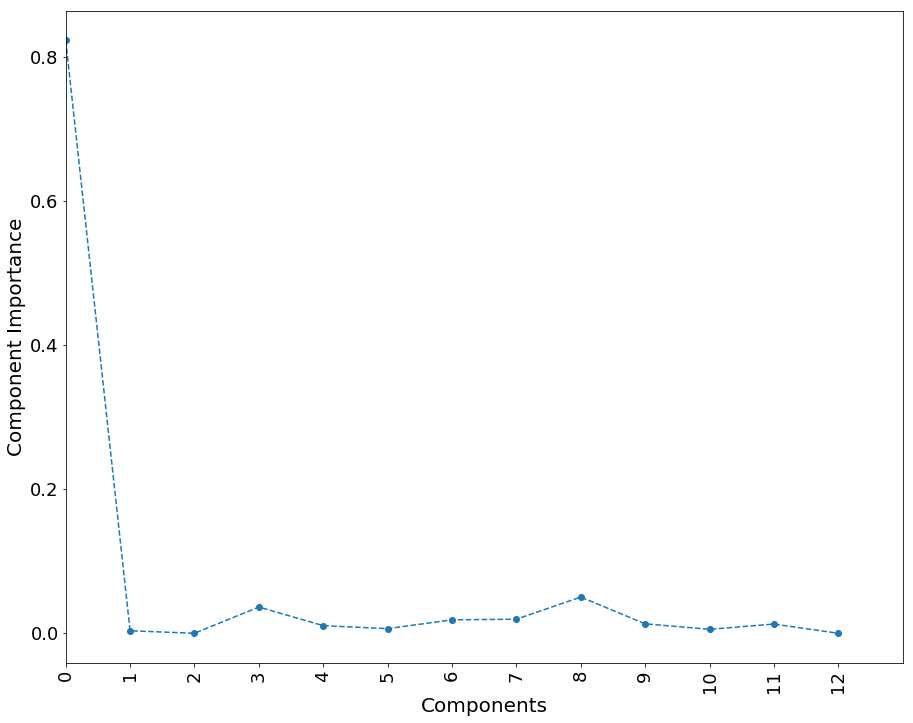

In [168]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [169]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.05  deviance                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1            50             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.811366384522

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3555   523     4078
1           569  1142     1711
__all__    4124  1665     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.808141878275

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1496  215     1711
1           261  509      770
__all__    1757  724     2481

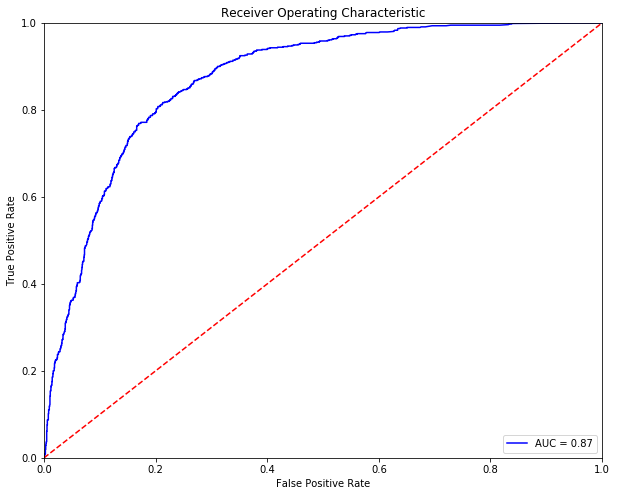

Optimal Threshold is 0.359216112197
Accuracy of Logistic Model on training data is: 0.798468359532


Predicted   0.0  1.0  __all__
Actual                       
0.0        1368  343     1711
1.0         157  613      770
__all__    1525  956     2481

In [170]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [171]:
table_70_70_PCA_0_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

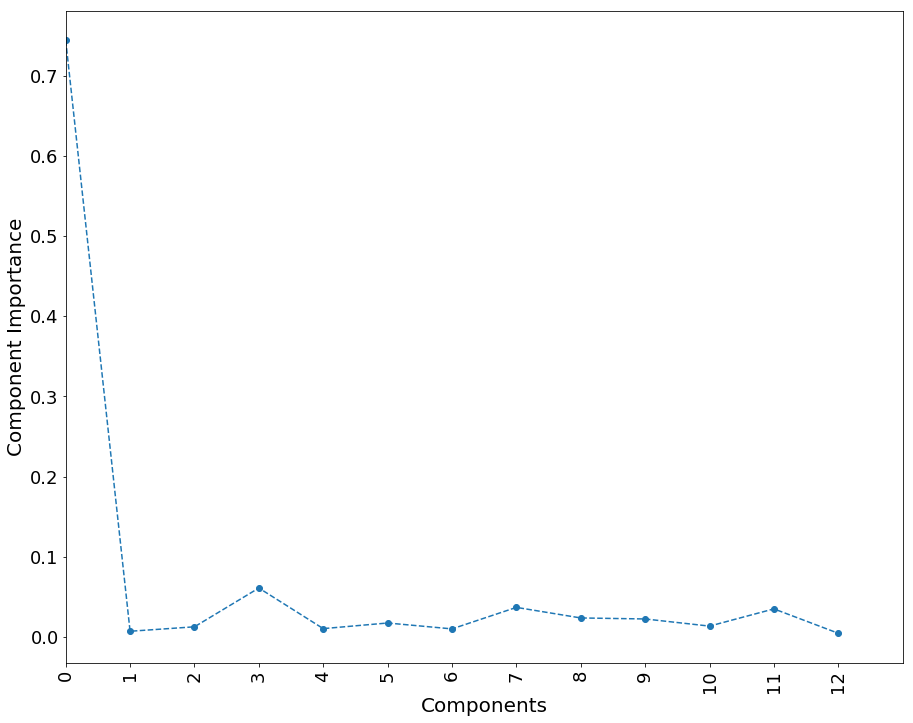

In [172]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [173]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         20          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.808948004837

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3470   608     4078
1           498  1213     1711
__all__    3968  1821     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.800886739218

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1462  249     1711
1           245  525      770
__all__    1707  774     2481

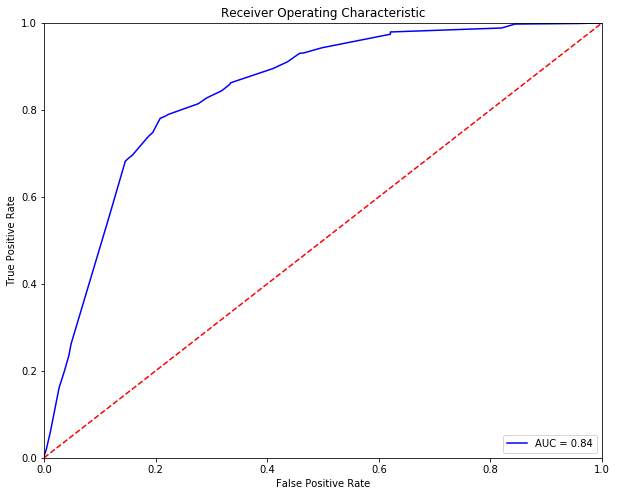

Optimal Threshold is 0.263157894737
Accuracy of Logistic Model on training data is: 0.788391777509


Predicted   0.0  1.0  __all__
Actual                       
0.0        1355  356     1711
1.0         169  601      770
__all__    1524  957     2481

In [174]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [175]:
table_70_70_PCA_0_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [176]:
%%capture
table_70_70_PCA_0_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

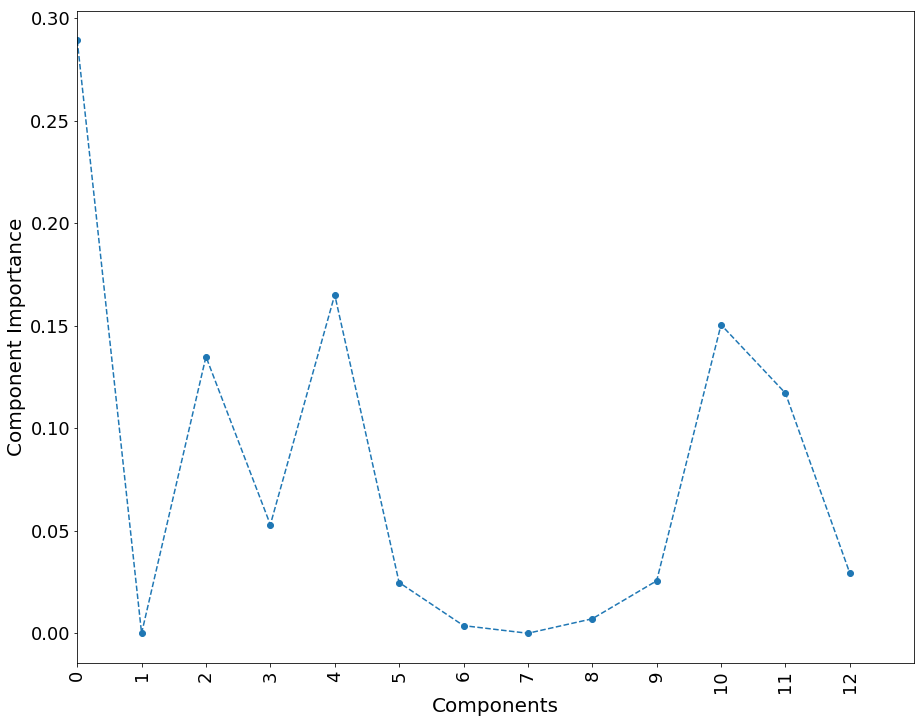

In [177]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [178]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           300   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.96130592503

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4048    30     4078
1           194  1517     1711
__all__    4242  1547     5789

Accuracy of the  Bagging  model for test data is: 0.792825473599

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1504  207     1711
1           307  463      770
__all__    1811  670     2481

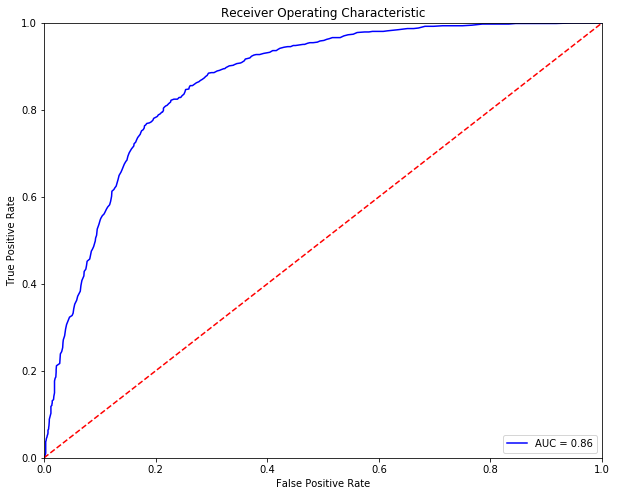

Optimal Threshold is 0.376666666667
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0        1361  350     1711
1.0         163  607      770
__all__    1524  957     2481

In [179]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [180]:
table_70_70_PCA_0_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [181]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.971843150803


Predicted     0     1  __all__
Actual                        
0          4056    22     4078
1           141  1570     1711
__all__    4197  1592     5789

The test accuracy is: 0.800483675937


Predicted     0    1  __all__
Actual                       
0          1498  213     1711
1           282  488      770
__all__    1780  701     2481

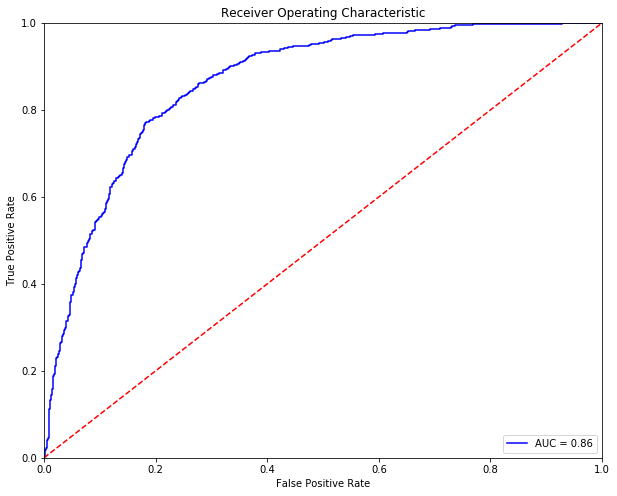

Optimal Threshold is 0.353454672731
Accuracy of Logistic Model on training data is: 0.78879484079


Predicted   0.0  1.0  __all__
Actual                       
0.0        1351  360     1711
1.0         164  606      770
__all__    1515  966     2481

In [182]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [183]:
table_70_70_PCA_0_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [184]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.867161858718


Predicted     0     1  __all__
Actual                        
0          3829   249     4078
1           520  1191     1711
__all__    4349  1440     5789

The accuracy of the model on test data is: 0.774687625957


Predicted     0    1  __all__
Actual                       
0          1494  217     1711
1           342  428      770
__all__    1836  645     2481

2080/2481 [========================>.....] - ETA: 0s

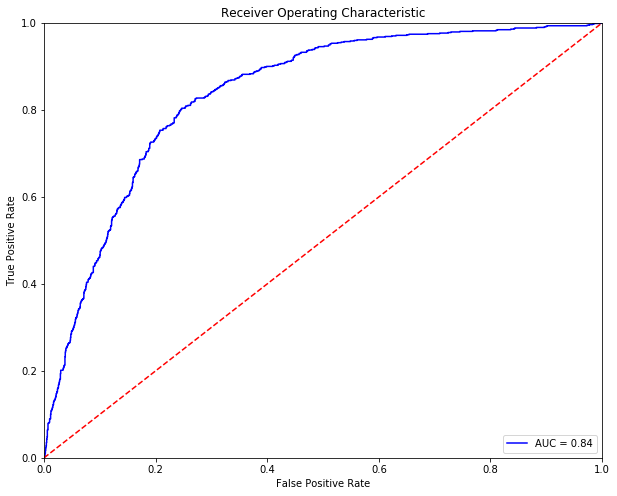

Optimal Threshold is 0.307238
Accuracy of Logistic Model on training data is: 0.769447803305


Predicted   0.0  1.0  __all__
Actual                       
0.0        1317  394     1711
1.0         178  592      770
__all__    1495  986     2481

In [185]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [186]:
table_70_70_PCA_0_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [187]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.9min finished


The accuracy of the model on training data is: 0.817066850924


Predicted     0     1  __all__
Actual                        
0          3500   578     4078
1           481  1230     1711
__all__    3981  1808     5789

The accuracy of the model on test data is: 0.812978637646


Predicted     0    1  __all__
Actual                       
0          1477  234     1711
1           230  540      770
__all__    1707  774     2481

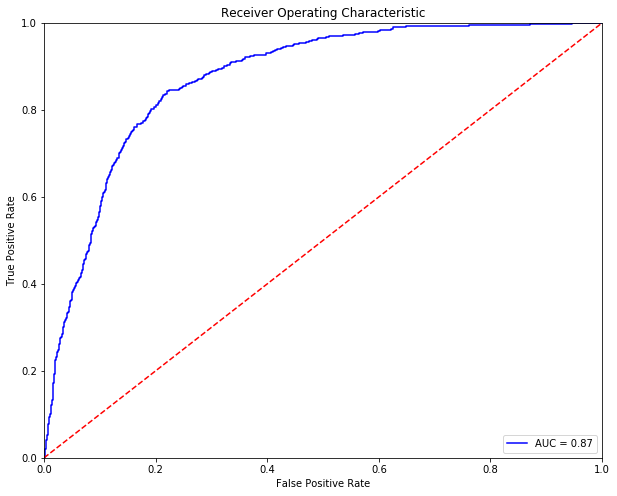

Optimal Threshold is 0.348974
Accuracy of Logistic Model on training data is: 0.803305118904


Predicted   0.0  1.0  __all__
Actual                       
0.0        1375  336     1711
1.0         152  618      770
__all__    1527  954     2481

In [188]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [189]:
table_70_70_PCA_0_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_0_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_0_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [190]:
table_70_70_PCA_0_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_0_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_0_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_0_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_0_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_0_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_0_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_0_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_0_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1711.0  4078.0    0.0    0.0  0.000000   
LogisticRegression          0.798756  1333.0  3291.0  787.0  378.0  0.192987   
RandomForestClassifier      0.985144  1641.0  4062.0   16.0   70.0  0.003923   
AdaBoostClassifier          0.809121  1236.0  3448.0  630.0  475.0  0.154487   
GradientBoostingClassifier  0.811366  1142.0  3555.0  523.0  569.0  0.128249   
ExtraTreeClassifier         0.808948  1213.0  3470.0  608.0  498.0  0.149093   
BaggingClassifier           0.961306  1517.0  4048.0   30.0  194.0  0.007357   
VotingClassifier            0.971843  1570.0  4056.0   22.0  141.0  0.005395   
Neural Network-1            0.867162  1191.0  3829.0  249.0  520.0  0.061059   
Neural-Network-2            0.817067  1230.0  3500.0  578.0  481.0  0.141736   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.220923  
RandomForestClassifier      0.040912  
AdaBoostClassifier          0.277615  
GradientBoostingClassifier  0.332554  
ExtraTreeClassifier         0.291058  
BaggingClassifier           0.113384  
VotingClassifier            0.082408  
Neural Network-1            0.303916  
Neural-Network-2            0.281122

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.784361  409.0  1537.0  174.0  361.0  0.101695   
LogisticRegression          0.803708  596.0  1398.0  313.0  174.0  0.182934   
RandomForestClassifier      0.771060  402.0  1511.0  200.0  368.0  0.116891   
AdaBoostClassifier          0.806127  550.0  1450.0  261.0  220.0  0.152542   
GradientBoostingClassifier  0.808142  509.0  1496.0  215.0  261.0  0.125658   
ExtraTreeClassifier         0.800887  525.0  1462.0  249.0  245.0  0.145529   
BaggingClassifier           0.792825  463.0  1504.0  207.0  307.0  0.120982   
VotingClassifier            0.800484  488.0  1498.0  213.0  282.0  0.124489   
Neural Network-1            0.774688  428.0  1494.0  217.0  342.0  0.126826   
Neural-Network-2            0.812979  540.0  1477.0  234.0  230.0  0.136762   

                                 FNR  
index                                 
KNeighborsClassifier        0.468831  
LogisticRegression          0.225974  
RandomForestClassifier      0.477922  
AdaBoostClassifier          0.285714  
GradientBoostingClassifier  0.338961  
ExtraTreeClassifier         0.318182  
BaggingClassifier           0.398701  
VotingClassifier            0.366234  
Neural Network-1            0.444156  
Neural-Network-2            0.298701

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.796453  613.0  1363.0  348.0  157.0  0.203390   
LogisticRegression          0.796453  613.0  1363.0  348.0  157.0  0.203390   
RandomForestClassifier      0.782749  518.0  1424.0  287.0  252.0  0.167738   
AdaBoostClassifier          0.795244  612.0  1361.0  350.0  158.0  0.204559   
GradientBoostingClassifier  0.798468  613.0  1368.0  343.0  157.0  0.200468   
ExtraTreeClassifier         0.788392  601.0  1355.0  356.0  169.0  0.208065   
BaggingClassifier           0.793229  607.0  1361.0  350.0  163.0  0.204559   
VotingClassifier            0.788795  606.0  1351.0  360.0  164.0  0.210403   
Neural Network-1            0.769448  592.0  1317.0  394.0  178.0  0.230275   
Neural-Network-2            0.803305  618.0  1375.0  336.0  152.0  0.196376   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.203896   0.269484  0.856967  
LogisticRegression          0.203896   0.477591  0.871741  
RandomForestClassifier      0.327273   0.400000  0.837137  
AdaBoostClassifier          0.205195   0.476124  0.871484  
GradientBoostingClassifier  0.203896   0.359216  0.871997  
ExtraTreeClassifier         0.219481   0.263158  0.841437  
BaggingClassifier           0.211688   0.376667  0.864134  
VotingClassifier            0.212987   0.353455  0.864641  
Neural Network-1            0.231169   0.307238  0.836564  
Neural-Network-2            0.197403   0.348974  0.872657

#### Random State 10

In [191]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_10.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  3030  230.950495   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   599  158.008347   

                                                          PAS        LEN  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  80.524092  84.155116   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  57.856427  82.028381   

                                                            BYS  \
Source_User                                                       
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  9686.861716   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  6161.512521   

                                                              BYR      SP  \
Source_User                                                                 
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  287727.528383  2741.0   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  198461.532554   587.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...  11.0    40   63  820   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12.0    30   70  210   

                                                            TDIF  0000  0100  \
Source_User                                                                    
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   2395.224422   195   256   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...  12098.198664     0     3   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   110    55    63    53   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     3     2     4     2   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    56    31    79    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     0    34    70    92   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...    39    75    98    81   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...   117    30    10    14   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   159   264   181   142   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     7     5    25    37   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   177   135   120   184   
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...    61    27    27    25   

                                                    2200  2300  
Source_User                                                     
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3...   240   156  
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce85...     1     3

1 -> Infected
0 -> Uninfected


Source_User
644acf067fe760509d55b90a2ab91e9c5e78d260c7214a3449af4e82e30f9f87    0
a434cc3ad58dedb0ed629a1bf82cb810fdad9a7ab47ce851fca5724939971862    1
06fe39332e5261ed8a5f1bb9d62559deb0de1620963ebbded14eecf78b8a0a20    0
5455eddbb8ee814c41a27e8676a6cc34faa6fc295c6e92588fc75dbe7f61369b    0
47a99c45d555e42658dbf94be7417ec6c327ecfc05ed5c57eaac1de3bd43bb86    1
60ff3ff13bb2e6a16dc866bc314964cc6d60b1e9891d805e7d9e99b1864ae896    1
a4244338cc086f69de152063f5b11482be2d007a5da089331dc2fe778e459e26    1
70de2ff22d8dd1433aa38947470f94f455bcbdabb1789e81332ba5c390408acc    1
6c49763f6a507ebf7aff12e40a61cfe3624fca5d5ac9dc1b86ac38c68ca4b1ba    0
ab60d8ea5924263ddfde9661ee4a4081f95679c77492da4479cd0350f56c7de3    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.915617452326
The train/test split ratio is 70:30


In [192]:
display(X_pca_13[0:1])

array([[ 0.1092487 ,  0.09758928, -0.52784745,  0.50560657, -0.430521  ,
        -0.43954403,  0.08248622,  0.03391669, -0.09021769,  0.28432751,
         0.05267798, -0.86988474, -0.07038592]])

In [193]:
## Table to store training and test measures
table_70_70_PCA_10_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_10_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_10_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [194]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  manhattan           50  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4059     0     4059
1             0  1730     1730
__all__    4059  1730     5789

Accuracy of the  KNN  model for test data is: 0.792019347037

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1539  191     1730
1           325  426      751
__all__    1864  617     2481

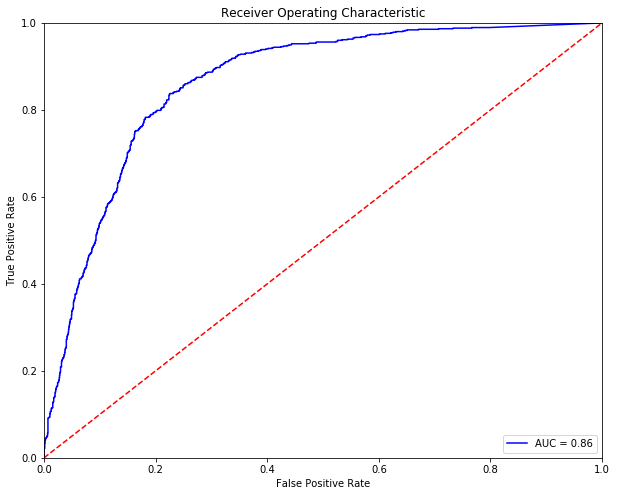

Optimal Threshold is 0.297667461809
Accuracy of Logistic Model on training data is: 0.798065296252


Predicted   0.0  1.0  __all__
Actual                       
0.0        1381  349     1730
1.0         152  599      751
__all__    1533  948     2481

In [195]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [196]:
table_70_70_PCA_10_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [197]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50          ovr   

             6       7      8  
index  penalty  solver    tol  
0           l2     sag  1e-05

Accuracy of the  Logistic  model for the training data is: 0.795128692348

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3296   763     4059
1           423  1307     1730
__all__    3719  2070     5789

Accuracy of the  Logistic  model for test data is: 0.807738814994

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1411  319     1730
1           158  593      751
__all__    1569  912     2481

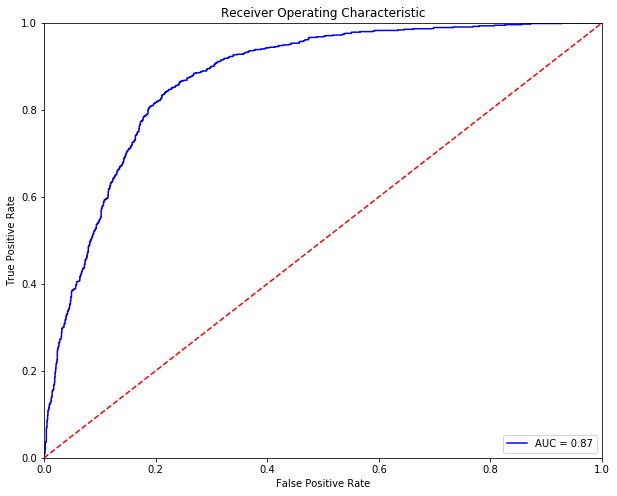

Optimal Threshold is 0.47498360736
Accuracy of Logistic Model on training data is: 0.808544941556


Predicted   0.0  1.0  __all__
Actual                       
0.0        1399  331     1730
1.0         144  607      751
__all__    1543  938     2481

In [198]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [199]:
table_70_70_PCA_10_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [200]:
rf=RandomForestClassifier()

parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.98756261876

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4052     7     4059
1            65  1665     1730
__all__    4117  1672     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.786376461104

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1510  220     1730
1           310  441      751
__all__    1820  661     2481

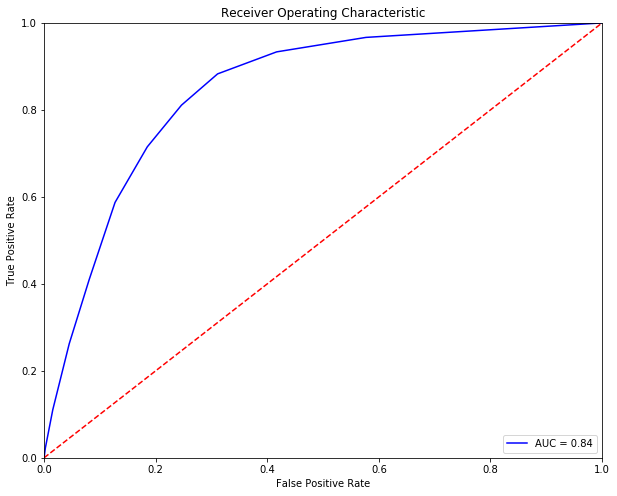

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.784764207981


Predicted   0.0  1.0  __all__
Actual                       
0.0        1410  320     1730
1.0         214  537      751
__all__    1624  857     2481

In [201]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [202]:
table_70_70_PCA_10_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

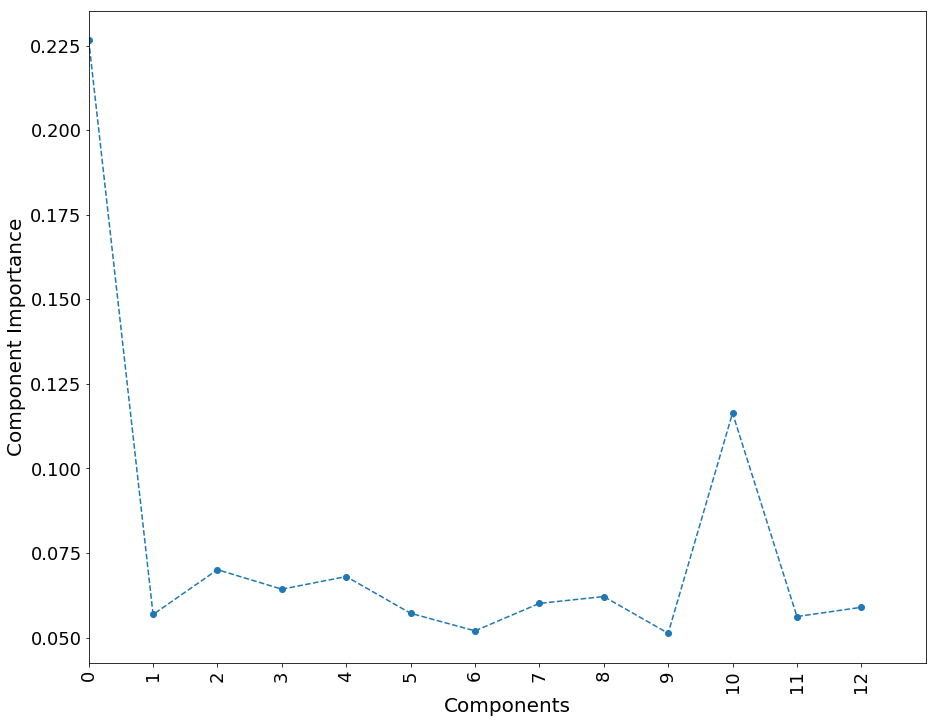

In [203]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [204]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME            0.5           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.802038348592

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3393   666     4059
1           480  1250     1730
__all__    3873  1916     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.807335751713

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1431  299     1730
1           179  572      751
__all__    1610  871     2481

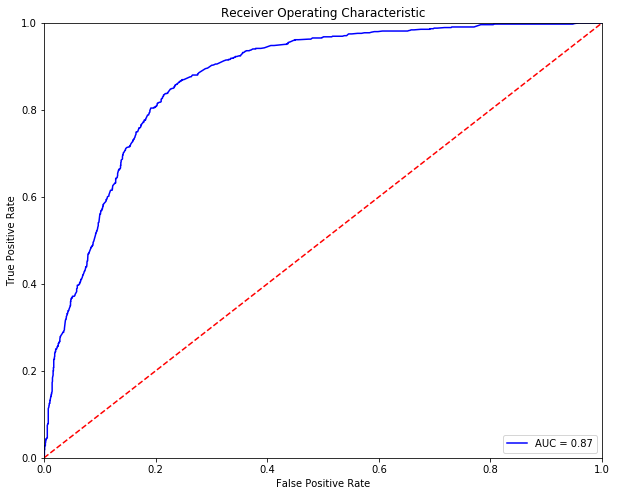

Optimal Threshold is 0.499508662882
Accuracy of Logistic Model on training data is: 0.805723498589


Predicted   0.0  1.0  __all__
Actual                       
0.0        1395  335     1730
1.0         147  604      751
__all__    1542  939     2481

In [205]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [206]:
table_70_70_PCA_10_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

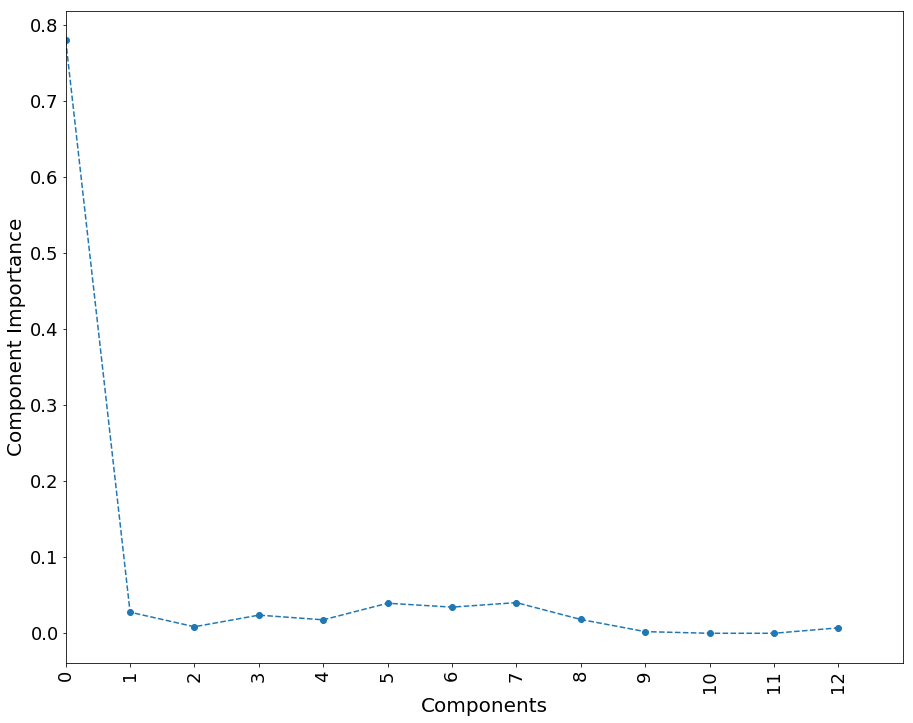

In [207]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [208]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1         2                 3  \
index  criterion  learning_rate      loss  min_samples_leaf   
0            mse           0.03  deviance                20   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           150             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.810502677492

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3490   569     4059
1           528  1202     1730
__all__    4018  1771     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.804514308746

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1463  267     1730
1           218  533      751
__all__    1681  800     2481

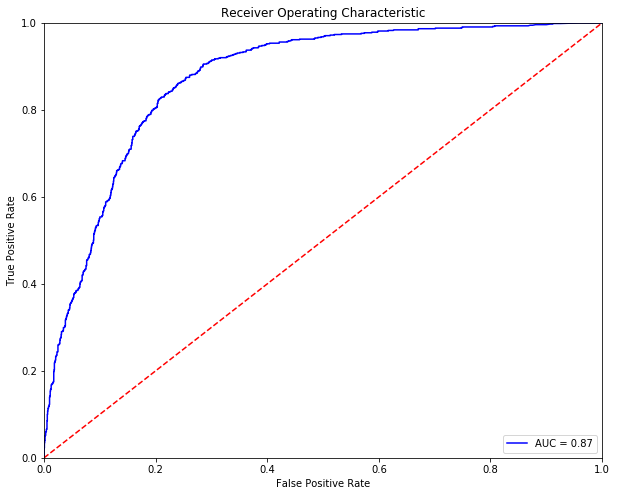

Optimal Threshold is 0.39133258436
Accuracy of Logistic Model on training data is: 0.802498992342


Predicted   0.0  1.0  __all__
Actual                       
0.0        1389  341     1730
1.0         149  602      751
__all__    1538  943     2481

In [209]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [210]:
table_70_70_PCA_10_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

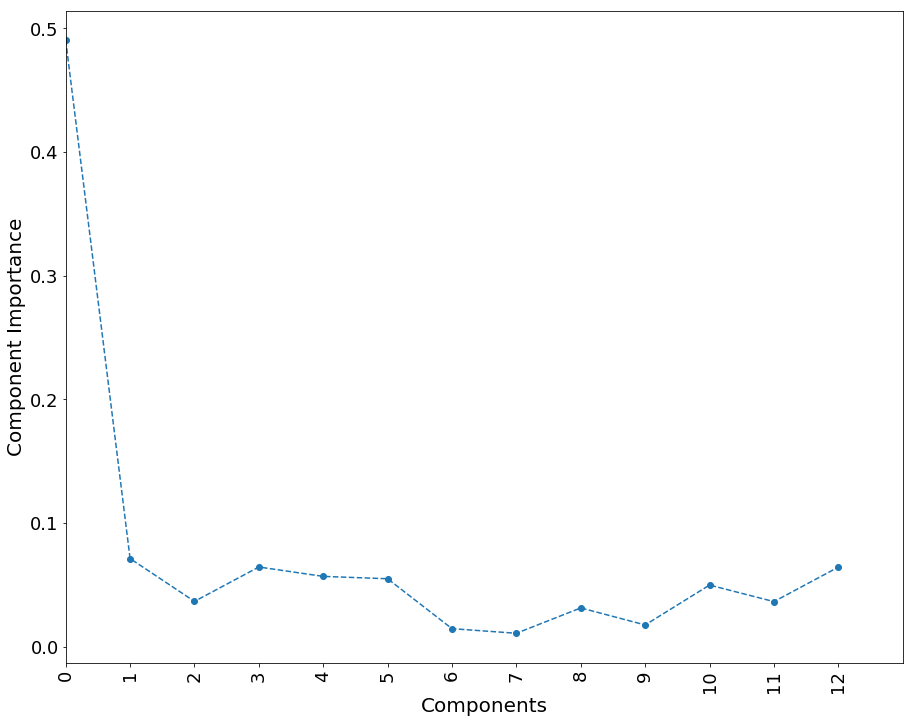

In [211]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [212]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0        entropy         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     3                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.807393332182

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3411   648     4059
1           467  1263     1730
__all__    3878  1911     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.791213220476

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1435  295     1730
1           223  528      751
__all__    1658  823     2481

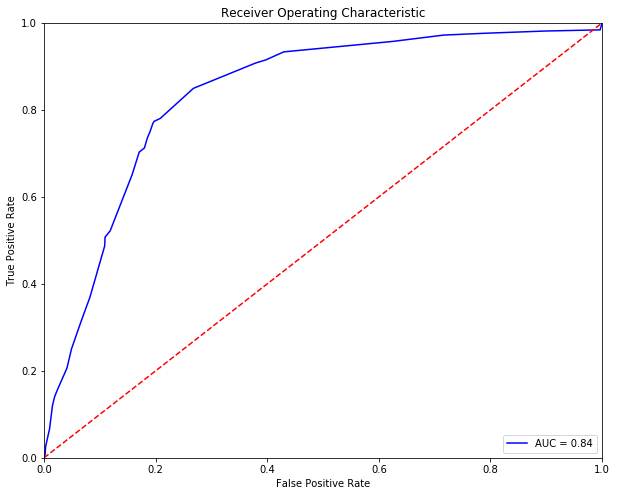

Optimal Threshold is 0.355555555556
Accuracy of Logistic Model on training data is: 0.794034663442


Predicted   0.0  1.0  __all__
Actual                       
0.0        1389  341     1730
1.0         170  581      751
__all__    1559  922     2481

In [213]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [214]:
table_70_70_PCA_10_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [215]:
%%capture
table_70_70_PCA_10_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

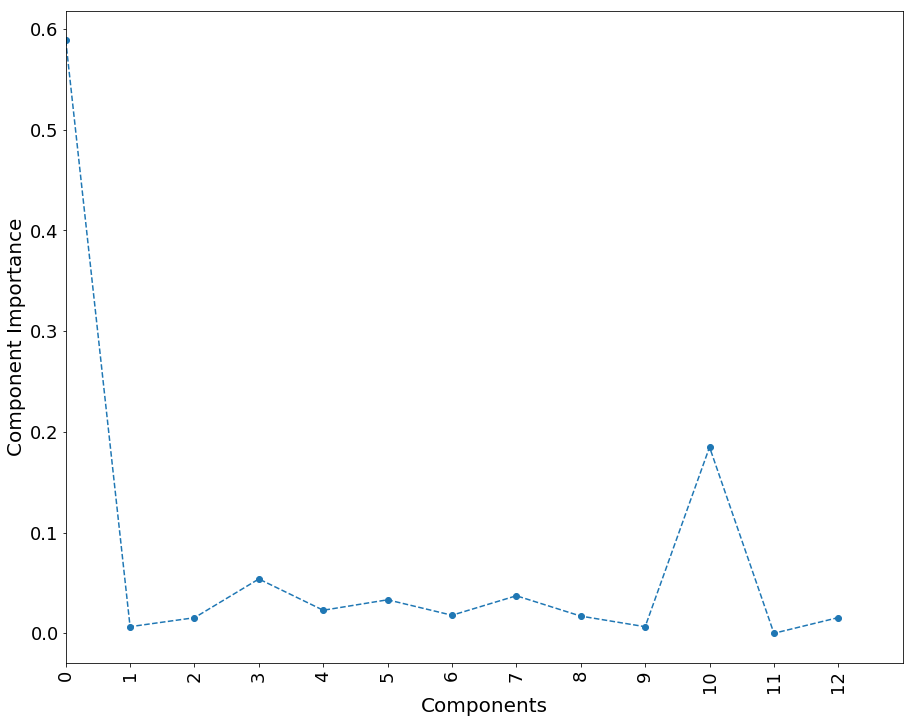

In [216]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [217]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.4           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.961651407842

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4027    32     4059
1           190  1540     1730
__all__    4217  1572     5789

Accuracy of the  Bagging  model for test data is: 0.799677549375

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1506  224     1730
1           273  478      751
__all__    1779  702     2481

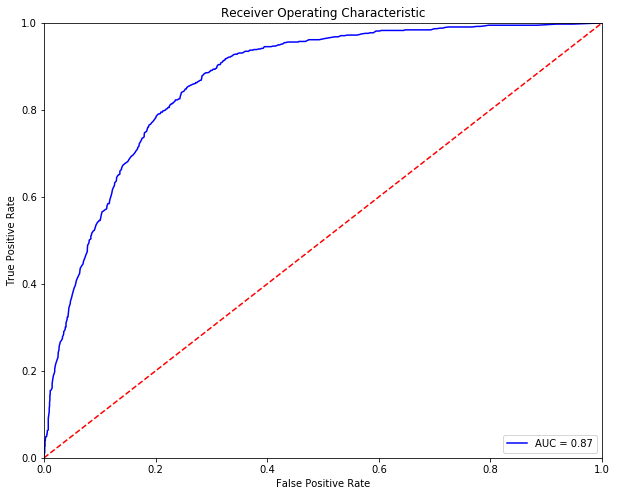

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.792019347037


Predicted   0.0  1.0  __all__
Actual                       
0.0        1371  359     1730
1.0         157  594      751
__all__    1528  953     2481

In [218]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [219]:
table_70_70_PCA_10_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [220]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.973052340646


Predicted     0     1  __all__
Actual                        
0          4038    21     4059
1           135  1595     1730
__all__    4173  1616     5789

The test accuracy is: 0.792422410318


Predicted     0    1  __all__
Actual                       
0          1489  241     1730
1           274  477      751
__all__    1763  718     2481

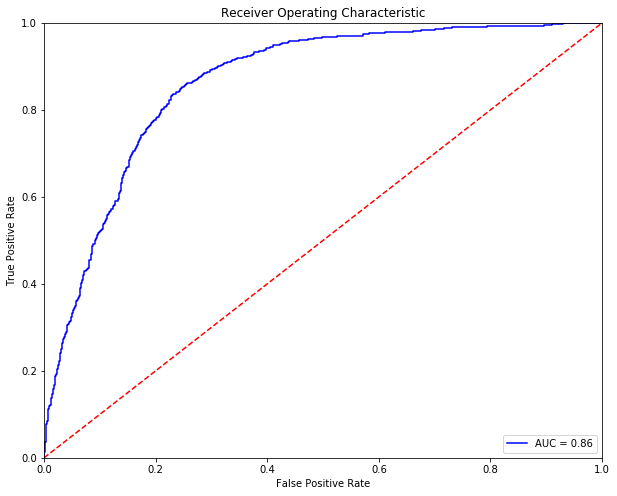

Optimal Threshold is 0.383524137215
Accuracy of Logistic Model on training data is: 0.792422410318


Predicted   0.0  1.0  __all__
Actual                       
0.0        1371  359     1730
1.0         156  595      751
__all__    1527  954     2481

In [221]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [222]:
table_70_70_PCA_10_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [223]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.86474347894


Predicted     0     1  __all__
Actual                        
0          3801   258     4059
1           525  1205     1730
__all__    4326  1463     5789

The accuracy of the model on test data is: 0.779927448609


Predicted     0    1  __all__
Actual                       
0          1505  225     1730
1           321  430      751
__all__    1826  655     2481

2481/2481 [==============================] - 0s     


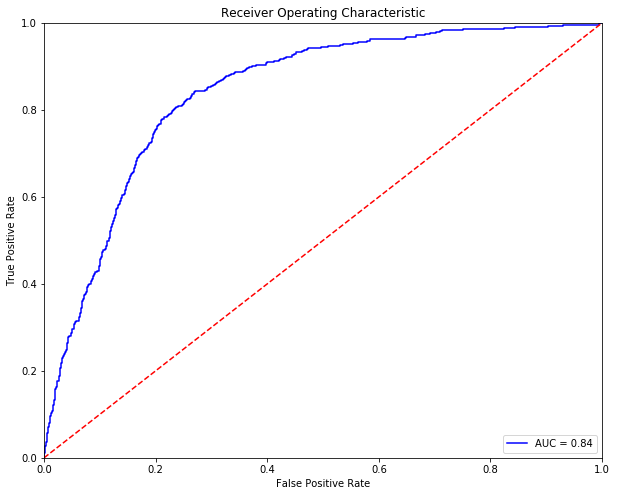

Optimal Threshold is 0.290771
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0        1356  374     1730
1.0         163  588      751
__all__    1519  962     2481

In [224]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [225]:
table_70_70_PCA_10_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [226]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.3min finished


The accuracy of the model on training data is: 0.806184142339


Predicted     0     1  __all__
Actual                        
0          3416   643     4059
1           479  1251     1730
__all__    3895  1894     5789

The accuracy of the model on test data is: 0.808544941556


Predicted     0    1  __all__
Actual                       
0          1434  296     1730
1           179  572      751
__all__    1613  868     2481

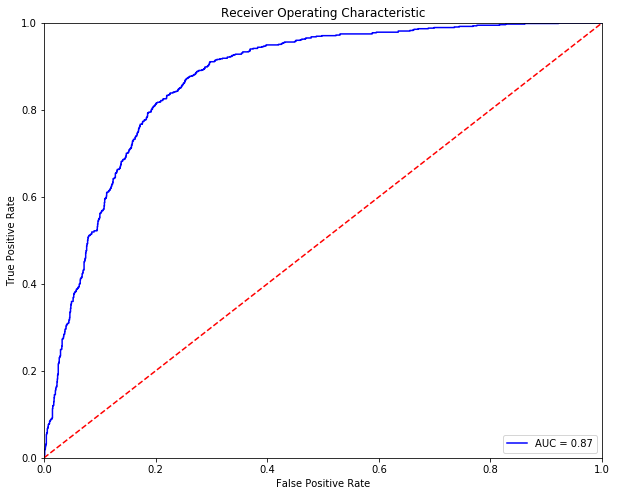

Optimal Threshold is 0.427788
Accuracy of Logistic Model on training data is: 0.805320435308


Predicted   0.0  1.0  __all__
Actual                       
0.0        1394  336     1730
1.0         147  604      751
__all__    1541  940     2481

In [227]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [228]:
table_70_70_PCA_10_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_10_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_10_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [229]:
table_70_70_PCA_10_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_10_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_10_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_10_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_10_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_10_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_10_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_10_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_10_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1730.0  4059.0    0.0    0.0  0.000000   
LogisticRegression          0.795129  1307.0  3296.0  763.0  423.0  0.187977   
RandomForestClassifier      0.987563  1665.0  4052.0    7.0   65.0  0.001725   
AdaBoostClassifier          0.802038  1250.0  3393.0  666.0  480.0  0.164080   
GradientBoostingClassifier  0.810503  1202.0  3490.0  569.0  528.0  0.140182   
ExtraTreeClassifier         0.807393  1263.0  3411.0  648.0  467.0  0.159645   
BaggingClassifier           0.961651  1540.0  4027.0   32.0  190.0  0.007884   
VotingClassifier            0.973052  1595.0  4038.0   21.0  135.0  0.005174   
Neural Network-1            0.864743  1205.0  3801.0  258.0  525.0  0.063562   
Neural-Network-2            0.806184  1251.0  3416.0  643.0  479.0  0.158413   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.244509  
RandomForestClassifier      0.037572  
AdaBoostClassifier          0.277457  
GradientBoostingClassifier  0.305202  
ExtraTreeClassifier         0.269942  
BaggingClassifier           0.109827  
VotingClassifier            0.078035  
Neural Network-1            0.303468  
Neural-Network-2            0.276879

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.792019  426.0  1539.0  191.0  325.0  0.110405   
LogisticRegression          0.807739  593.0  1411.0  319.0  158.0  0.184393   
RandomForestClassifier      0.786376  441.0  1510.0  220.0  310.0  0.127168   
AdaBoostClassifier          0.807336  572.0  1431.0  299.0  179.0  0.172832   
GradientBoostingClassifier  0.804514  533.0  1463.0  267.0  218.0  0.154335   
ExtraTreeClassifier         0.791213  528.0  1435.0  295.0  223.0  0.170520   
BaggingClassifier           0.799678  478.0  1506.0  224.0  273.0  0.129480   
VotingClassifier            0.792422  477.0  1489.0  241.0  274.0  0.139306   
Neural Network-1            0.779927  430.0  1505.0  225.0  321.0  0.130058   
Neural-Network-2            0.808545  572.0  1434.0  296.0  179.0  0.171098   

                                 FNR  
index                                 
KNeighborsClassifier        0.432756  
LogisticRegression          0.210386  
RandomForestClassifier      0.412783  
AdaBoostClassifier          0.238349  
GradientBoostingClassifier  0.290280  
ExtraTreeClassifier         0.296937  
BaggingClassifier           0.363515  
VotingClassifier            0.364847  
Neural Network-1            0.427430  
Neural-Network-2            0.238349

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.798065  599.0  1381.0  349.0  152.0  0.201734   
LogisticRegression          0.808545  607.0  1399.0  331.0  144.0  0.191329   
RandomForestClassifier      0.784764  537.0  1410.0  320.0  214.0  0.184971   
AdaBoostClassifier          0.805723  604.0  1395.0  335.0  147.0  0.193642   
GradientBoostingClassifier  0.802499  602.0  1389.0  341.0  149.0  0.197110   
ExtraTreeClassifier         0.794035  581.0  1389.0  341.0  170.0  0.197110   
BaggingClassifier           0.792019  594.0  1371.0  359.0  157.0  0.207514   
VotingClassifier            0.792422  595.0  1371.0  359.0  156.0  0.207514   
Neural Network-1            0.783555  588.0  1356.0  374.0  163.0  0.216185   
Neural-Network-2            0.805320  604.0  1394.0  336.0  147.0  0.194220   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.202397   0.297667  0.863766  
LogisticRegression          0.191744   0.474984  0.873712  
RandomForestClassifier      0.284953   0.400000  0.844990  
AdaBoostClassifier          0.195739   0.499509  0.872838  
GradientBoostingClassifier  0.198402   0.391333  0.873297  
ExtraTreeClassifier         0.226365   0.355556  0.836858  
BaggingClassifier           0.209055   0.400000  0.867948  
VotingClassifier            0.207723   0.383524  0.863018  
Neural Network-1            0.217044   0.290771  0.840684  
Neural-Network-2            0.195739   0.427788  0.871952

#### Random State 20

In [230]:
## Read the csv file which contains the data aggregated on user level 
z=pd.read_csv('../Collecting logs and Building Feature Set/Feature_Vector_70_30_2_15_random_state_20.csv',index_col='Source_User')

z.columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','Target','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]


columns=['NREC','PAR','PAS','LEN','BYS','BYR','SP','DP','NAPP','SIP','DIP','TDIF',
    '0000','0100','0200','0300','0400','0500','0600','0700','0800','0900','1000','1100','1200',
    '1300','1400','1500','1600','1700','1800','1900','2000','2100','2200','2300'
]

print("The feature vector for infected users and sample of uninfected users")
print('Infected/Unifected Users')
display(z.Target.value_counts())

X=z.iloc[:,z.columns!='Target']
display(X.head(2))
X=X.values

### Build our target variable
print("1 -> Infected\n0 -> Uninfected")
Y=z.Target
Y=Y.apply(lambda x: 1 if x=='infected' else 0)
display(Y.head(10))
Y=Y.values

### Scale feature set  using Standard Scaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

pca=PCA(n_components=13,whiten=True,random_state=0)
X_pca_13=pca.fit_transform(scaled_X)
print("Variance explained using 13 components is:",sum(pca.explained_variance_ratio_))

print("The train/test split ratio is 70:30")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_13,Y,random_state=0,test_size=0.3)

The feature vector for infected users and sample of uninfected users
Infected/Unifected Users


uninfected    5789
infected      2481
Name: Target, dtype: int64

NREC         PAR  \
Source_User                                                            
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   651   35.807988   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  4059  321.478197   

                                                           PAS         LEN  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   35.328725  108.442396   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  131.395910   73.695245   

                                                             BYS  \
Source_User                                                        
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   3976.233487   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  31586.025868   

                                                              BYR      SP  \
Source_User                                                                 
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   37072.858679   639.0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  413326.700419  3627.0   

                                                      DP  NAPP  SIP  DIP  \
Source_User                                                                
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...   8.0    21   23  158   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...  18.0    40   31  974   

                                                            TDIF  0000  0100  \
Source_User                                                                    
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...  11131.820276     6     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   1803.300813   196   310   

                                                    0200  0300  0400  0500  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     2     0     0     0   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   532   308   202   101   

                                                    0600  0700  0800  0900  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     0    13     8    34   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    45   281    95    38   

                                                    1000  1100  1200  1300  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    95    39    76    71   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...    93    95   206   102   

                                                    1400  1500  1600  1700  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    74    66   114    27   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   104    84   194   144   

                                                    1800  1900  2000  2100  \
Source_User                                                                  
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...    14     0     0     7   
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   116   161   158   138   

                                                    2200  2300  
Source_User                                                     
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d64...     3     2  
307c636564c5ec9897e5062605e2982daf781f0f82b0234...   159   197

1 -> Infected
0 -> Uninfected


Source_User
b8517ecc923cf25374ba60a6da4f97be55f9f01896a2d641329bc603046dfcc4    0
307c636564c5ec9897e5062605e2982daf781f0f82b0234f2cbc55919f8d04e2    0
11e8b7b973c885d9d2560baeec4673bc6b13aab08d9e49bc9c519727595e4d3e    1
41851f48304067368da8f12794e2f539330cc7ef6732c1440ed4c5eb06b9cc5d    0
08402d90e55ea64677880c21fc3850422ad2e08f730282d271027f0fea60b4b6    1
952aed50327c6ac4e19a033bb585959b33ea2ca897f985dc33a1bb6a1f3d7cc7    0
6b42f8e7f92d2fccc0fae12167ef5e929f394e87e9c70bb36ac160bf6d6cb0f4    0
c9140a85217daf0d18148d489fa6d3293cbe499584b12e28be0e381a20eeb737    1
647e8a6690cd21f7bae287782ec6a621cae3a5ba6f37b779d99f28a7851b1bfc    0
42d06643547a80b9343fa1a09ca32b0c3bb84caa31bfb45c629b6835072e364b    0
Name: Target, dtype: int64

Variance explained using 13 components is: 0.920535156414
The train/test split ratio is 70:30


In [231]:
display(X_pca_13[0:1])

array([[-0.5327557 , -0.05293468,  0.17489689, -0.0108528 ,  0.30105805,
         0.0389905 ,  0.13583015, -0.32384755,  0.65499101, -0.0822117 ,
         0.18802012,  0.15884271,  0.03627151]])

In [232]:
## Table to store training and test measures
table_70_70_PCA_20_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_20_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_70_70_PCA_20_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

#### KNN

In [233]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


0          1          2            3         4
index  algorithm  leaf_size     metric  n_neighbors   weights
0           auto          2  euclidean           20  distance

Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4039     0     4039
1             0  1750     1750
__all__    4039  1750     5789

Accuracy of the  KNN  model for test data is: 0.796453043128

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1576  174     1750
1           331  400      731
__all__    1907  574     2481

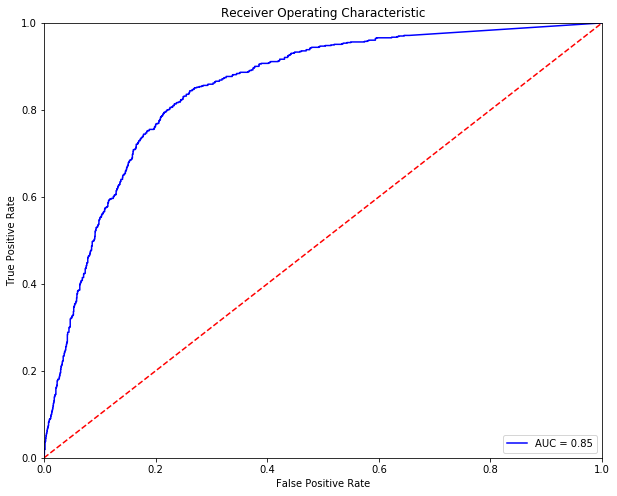

Optimal Threshold is 0.294521452973
Accuracy of Logistic Model on training data is: 0.787585650947


Predicted   0.0  1.0  __all__
Actual                       
0.0        1379  371     1750
1.0         156  575      731
__all__    1535  946     2481

In [234]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [235]:
table_70_70_PCA_20_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Logistic

In [236]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[50,100],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


0      1              2                  3         4            5  \
index    C   dual  fit_intercept  intercept_scaling  max_iter  multi_class   
0      0.5  False          False                0.5        50  multinomial   

             6          7      8  
index  penalty     solver    tol  
0           l2  newton-cg  1e-05

Accuracy of the  Logistic  model for the training data is: 0.79858352047

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3287   752     4039
1           414  1336     1750
__all__    3701  2088     5789

Accuracy of the  Logistic  model for test data is: 0.81015719468

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1460  290     1750
1           181  550      731
__all__    1641  840     2481

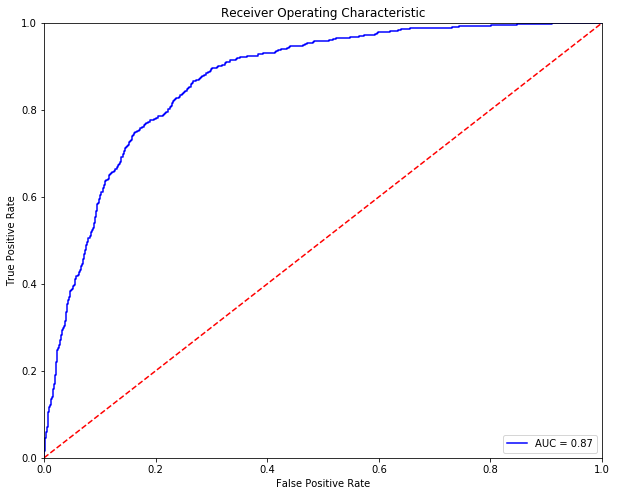

Optimal Threshold is 0.464737710426
Accuracy of Logistic Model on training data is: 0.786779524385


Predicted   0.0  1.0  __all__
Actual                       
0.0        1377  373     1750
1.0         156  575      731
__all__    1533  948     2481

In [237]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [238]:
table_70_70_PCA_20_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Random Forest Trees

In [239]:
rf=RandomForestClassifier()

parameters = dict()
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


Empty DataFrame
Columns: []
Index: [index]

Accuracy of the  Random Forest Trees  model for the training data is: 0.985835204699

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4030     9     4039
1            73  1677     1750
__all__    4103  1686     5789

Accuracy of the  Random Forest Trees  model for test data is: 0.780733575171

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1539  211     1750
1           333  398      731
__all__    1872  609     2481

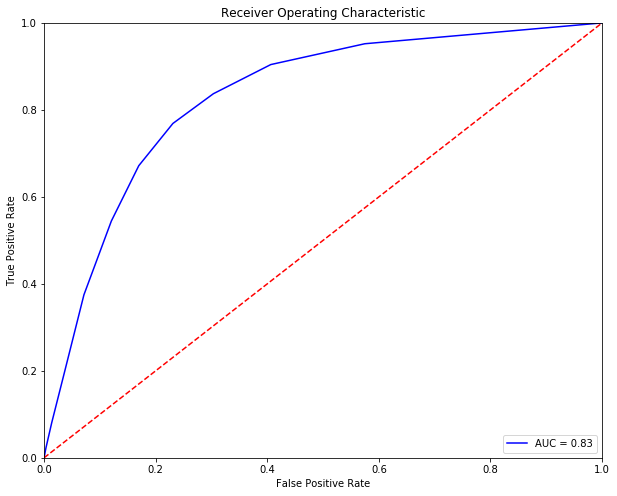

Optimal Threshold is 0.4
Accuracy of Logistic Model on training data is: 0.783555018138


Predicted   0.0  1.0  __all__
Actual                       
0.0        1453  297     1750
1.0         240  491      731
__all__    1693  788     2481

In [240]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [241]:
%%capture
table_70_70_PCA_20_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

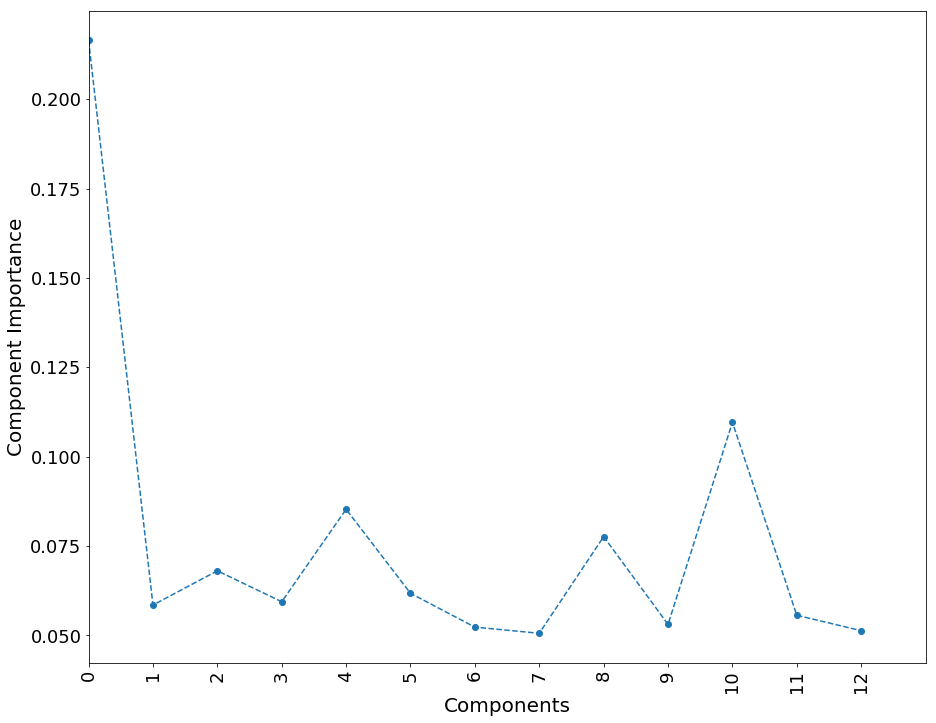

In [242]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### AdaBoostClassifier

In [243]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


0              1             2             3
index  algorithm  learning_rate  n_estimators  random_state
0          SAMME              1           400             0

Accuracy of the  AdaBoostClassifier  model for the training data is: 0.806875107963

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3438   601     4039
1           517  1233     1750
__all__    3955  1834     5789

Accuracy of the  AdaBoostClassifier  model for test data is: 0.805320435308

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1506  244     1750
1           239  492      731
__all__    1745  736     2481

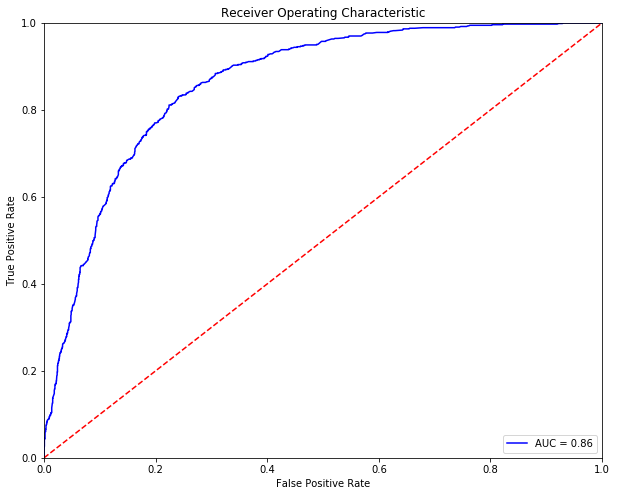

Optimal Threshold is 0.476656597972
Accuracy of Logistic Model on training data is: 0.785570334543


Predicted   0.0  1.0  __all__
Actual                       
0.0        1375  375     1750
1.0         157  574      731
__all__    1532  949     2481

In [244]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [245]:
table_70_70_PCA_20_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

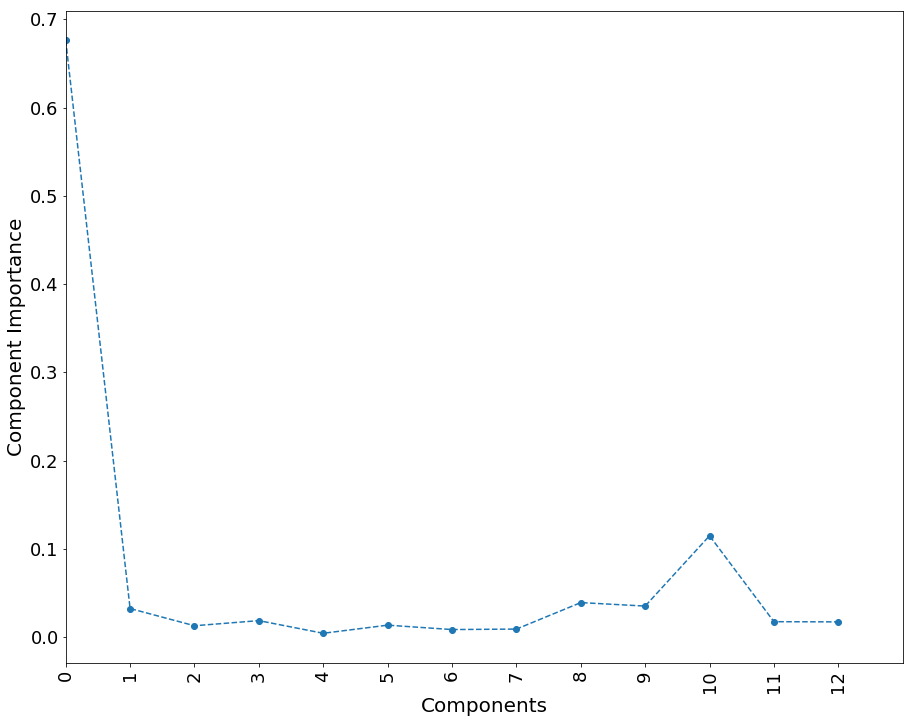

In [246]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### GradientBoostingClassifier

In [247]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


0              1            2                 3  \
index  criterion  learning_rate         loss  min_samples_leaf   
0            mse           0.05  exponential                10   

                       4             5             6          7  
index  min_samples_split  n_estimators  random_state  subsample  
0                    0.1           100             0        0.7

Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.81326653999

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3456   583     4039
1           498  1252     1750
__all__    3954  1835     5789

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.815397017332

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1517  233     1750
1           225  506      731
__all__    1742  739     2481

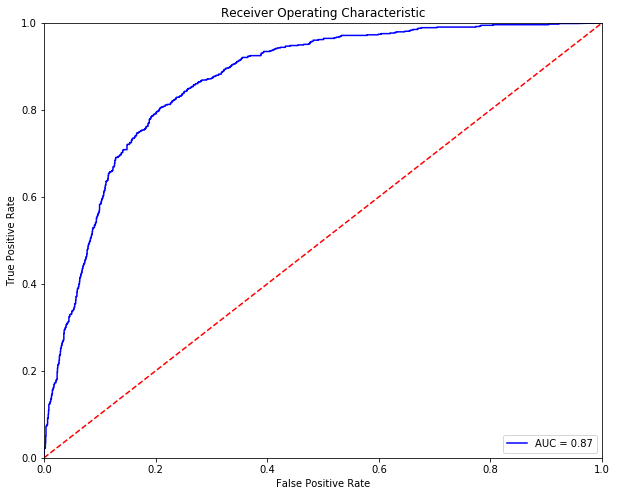

Optimal Threshold is 0.350113520458
Accuracy of Logistic Model on training data is: 0.796453043128


Predicted   0.0  1.0  __all__
Actual                       
0.0        1394  356     1750
1.0         149  582      731
__all__    1543  938     2481

In [248]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [249]:
table_70_70_PCA_20_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

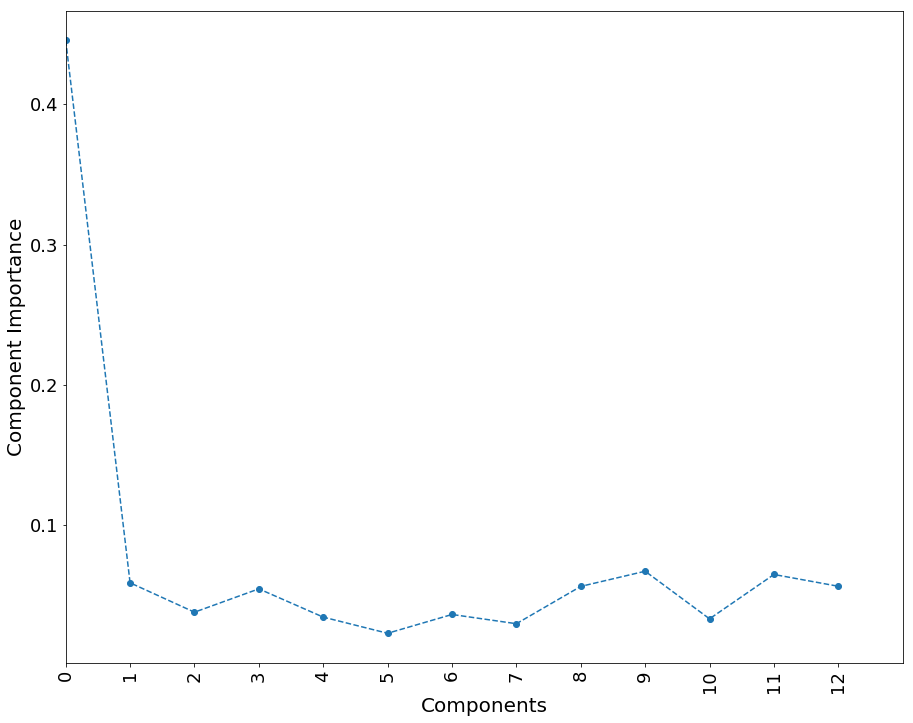

In [250]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### ExtraTreeClassifier

In [251]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


0          1             2                      3  \
index  criterion  max_depth  max_features  min_impurity_decrease   
0           gini         10          auto                  0.001   

                      4                  5             6         7  
index  min_samples_leaf  min_samples_split  random_state  splitter  
0                     2                  2             0      best

Accuracy of the  Extra Decision Tree  model for the training data is: 0.796510623596

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          3255   784     4039
1           394  1356     1750
__all__    3649  2140     5789

Accuracy of the  Extra Decision Tree  model for test data is: 0.797662232971

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1432  318     1750
1           184  547      731
__all__    1616  865     2481

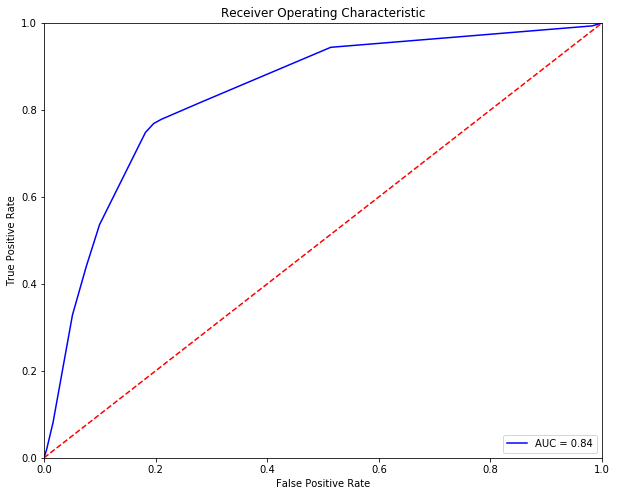

Optimal Threshold is 0.276923076923
Accuracy of Logistic Model on training data is: 0.79322853688


Predicted   0.0  1.0  __all__
Actual                       
0.0        1406  344     1750
1.0         169  562      731
__all__    1575  906     2481

In [252]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [253]:
table_70_70_PCA_20_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])

In [254]:
%%capture
table_70_70_PCA_20_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

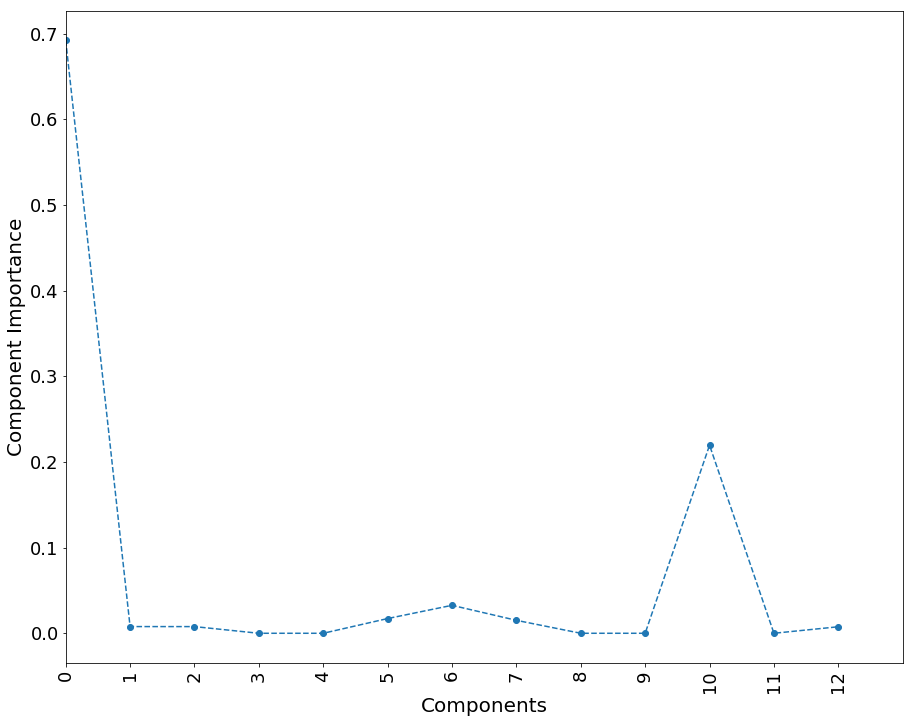

In [255]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Component Importance', fontsize=20)
plt.xlabel('Components', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 13])
plt.xticks(np.arange(13),rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

#### Bagging Classifier

In [256]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


0                   1             2            3             4  \
index  bootstrap  bootstrap_features  max_features  max_samples  n_estimators   
0           True                True           0.6          0.6           500   

               5             6  
index  oob_score  random_state  
0           True             0

Accuracy of the  Bagging  model for the training data is: 0.991881153913

Confusion Matrix for Training data is:


Predicted     0     1  __all__
Actual                        
0          4039     0     4039
1            47  1703     1750
__all__    4086  1703     5789

Accuracy of the  Bagging  model for test data is: 0.80169286578

Confusion Matrix for test data is:


Predicted     0    1  __all__
Actual                       
0          1535  215     1750
1           277  454      731
__all__    1812  669     2481

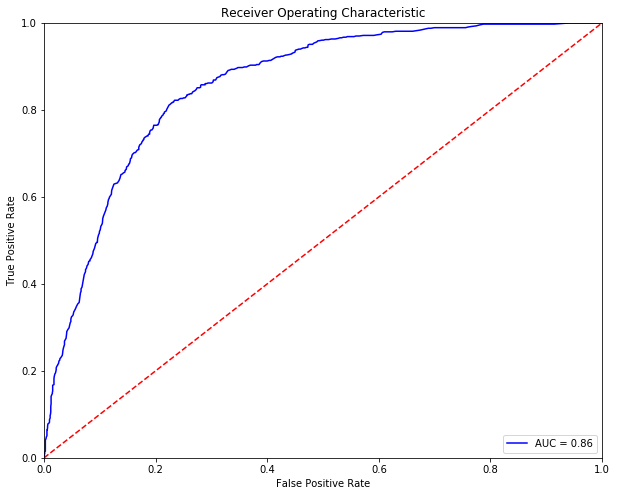

Optimal Threshold is 0.37
Accuracy of Logistic Model on training data is: 0.787988714228


Predicted   0.0  1.0  __all__
Actual                       
0.0        1380  370     1750
1.0         156  575      731
__all__    1536  945     2481

In [257]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [258]:
table_70_70_PCA_20_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### VotingClassifier

In [259]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

The training accuracy is : 0.974607013301


Predicted     0     1  __all__
Actual                        
0          4020    19     4039
1           128  1622     1750
__all__    4148  1641     5789

The test accuracy is: 0.797662232971


Predicted     0    1  __all__
Actual                       
0          1522  228     1750
1           274  457      731
__all__    1796  685     2481

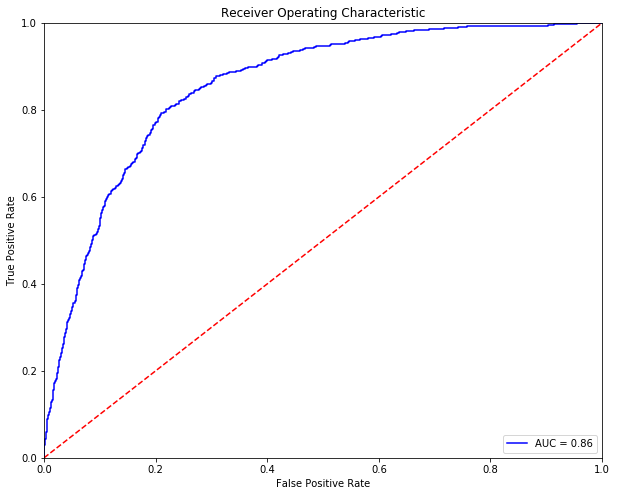

Optimal Threshold is 0.37469879642
Accuracy of Logistic Model on training data is: 0.790407093914


Predicted   0.0  1.0  __all__
Actual                       
0.0        1384  366     1750
1.0         154  577      731
__all__    1538  943     2481

In [260]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [261]:
table_70_70_PCA_20_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras -1 

In [262]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.864397996128


Predicted     0     1  __all__
Actual                        
0          3726   313     4039
1           472  1278     1750
__all__    4198  1591     5789

The accuracy of the model on test data is: 0.787182587666


Predicted     0    1  __all__
Actual                       
0          1516  234     1750
1           294  437      731
__all__    1810  671     2481

2272/2481 [==========================>...] - ETA: 0s

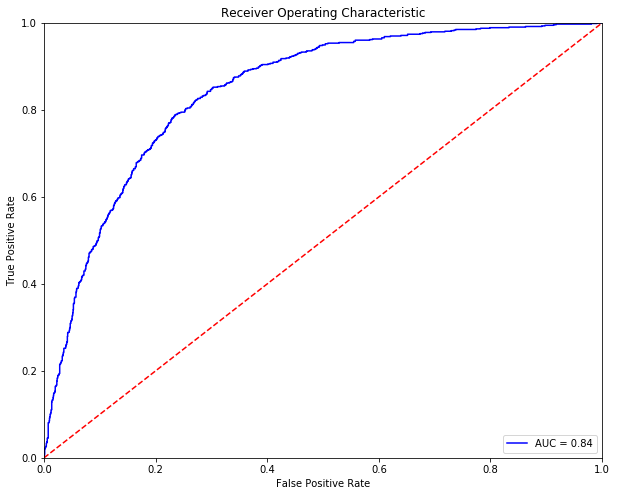

Optimal Threshold is 0.30168
Accuracy of Logistic Model on training data is: 0.772672309553


Predicted   0.0  1.0  __all__
Actual                       
0.0        1353  397     1750
1.0         167  564      731
__all__    1520  961     2481

In [263]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [264]:
table_70_70_PCA_20_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### Neural Network with Keras and Grid Search - 2

In [265]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=13))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.9min finished


The accuracy of the model on training data is: 0.816721368112


Predicted     0     1  __all__
Actual                        
0          3486   553     4039
1           508  1242     1750
__all__    3994  1795     5789

The accuracy of the model on test data is: 0.809351068118


Predicted     0    1  __all__
Actual                       
0          1507  243     1750
1           230  501      731
__all__    1737  744     2481

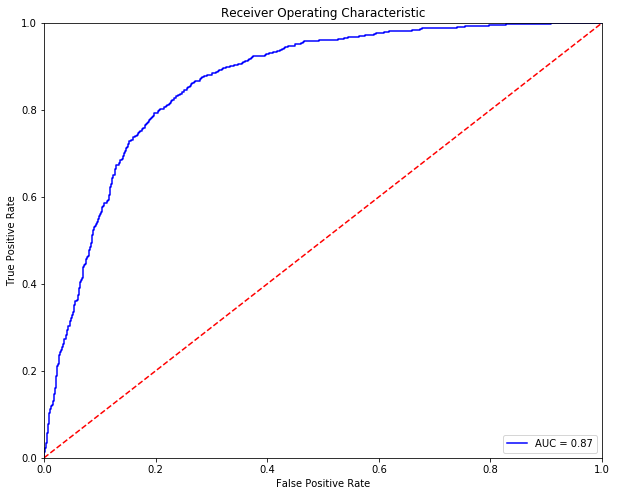

Optimal Threshold is 0.375368
Accuracy of Logistic Model on training data is: 0.796049979847


Predicted   0.0  1.0  __all__
Actual                       
0.0        1394  356     1750
1.0         150  581      731
__all__    1544  937     2481

In [266]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [267]:
table_70_70_PCA_20_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_70_70_PCA_20_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_70_70_PCA_20_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

In [268]:
table_70_70_PCA_20_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_20_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_70_70_PCA_20_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_70_70_PCA_20_test.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_20_train.set_index(['index'],drop=True,inplace=True)
table_70_70_PCA_20_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_20_train)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_20_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_20_test_roc)

Comparision Table for Training Accuracies:


accuracy      TP      TN     FP     FN       FPR  \
index                                                                          
KNeighborsClassifier        1.000000  1750.0  4039.0    0.0    0.0  0.000000   
LogisticRegression          0.798584  1336.0  3287.0  752.0  414.0  0.186185   
RandomForestClassifier      0.985835  1677.0  4030.0    9.0   73.0  0.002228   
AdaBoostClassifier          0.806875  1233.0  3438.0  601.0  517.0  0.148799   
GradientBoostingClassifier  0.813267  1252.0  3456.0  583.0  498.0  0.144343   
ExtraTreeClassifier         0.796511  1356.0  3255.0  784.0  394.0  0.194107   
BaggingClassifier           0.991881  1703.0  4039.0    0.0   47.0  0.000000   
VotingClassifier            0.974607  1622.0  4020.0   19.0  128.0  0.004704   
Neural Network-1            0.864398  1278.0  3726.0  313.0  472.0  0.077494   
Neural-Network-2            0.816721  1242.0  3486.0  553.0  508.0  0.136915   

                                 FNR  
index                                 
KNeighborsClassifier        0.000000  
LogisticRegression          0.236571  
RandomForestClassifier      0.041714  
AdaBoostClassifier          0.295429  
GradientBoostingClassifier  0.284571  
ExtraTreeClassifier         0.225143  
BaggingClassifier           0.026857  
VotingClassifier            0.073143  
Neural Network-1            0.269714  
Neural-Network-2            0.290286

Comparision Table for Test Accuracies:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.796453  400.0  1576.0  174.0  331.0  0.099429   
LogisticRegression          0.810157  550.0  1460.0  290.0  181.0  0.165714   
RandomForestClassifier      0.780734  398.0  1539.0  211.0  333.0  0.120571   
AdaBoostClassifier          0.805320  492.0  1506.0  244.0  239.0  0.139429   
GradientBoostingClassifier  0.815397  506.0  1517.0  233.0  225.0  0.133143   
ExtraTreeClassifier         0.797662  547.0  1432.0  318.0  184.0  0.181714   
BaggingClassifier           0.801693  454.0  1535.0  215.0  277.0  0.122857   
VotingClassifier            0.797662  457.0  1522.0  228.0  274.0  0.130286   
Neural Network-1            0.787183  437.0  1516.0  234.0  294.0  0.133714   
Neural-Network-2            0.809351  501.0  1507.0  243.0  230.0  0.138857   

                                 FNR  
index                                 
KNeighborsClassifier        0.452804  
LogisticRegression          0.247606  
RandomForestClassifier      0.455540  
AdaBoostClassifier          0.326949  
GradientBoostingClassifier  0.307798  
ExtraTreeClassifier         0.251710  
BaggingClassifier           0.378933  
VotingClassifier            0.374829  
Neural Network-1            0.402189  
Neural-Network-2            0.314637

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy     TP      TN     FP     FN       FPR  \
index                                                                         
KNeighborsClassifier        0.787586  575.0  1379.0  371.0  156.0  0.212000   
LogisticRegression          0.786780  575.0  1377.0  373.0  156.0  0.213143   
RandomForestClassifier      0.783555  491.0  1453.0  297.0  240.0  0.169714   
AdaBoostClassifier          0.785570  574.0  1375.0  375.0  157.0  0.214286   
GradientBoostingClassifier  0.796453  582.0  1394.0  356.0  149.0  0.203429   
ExtraTreeClassifier         0.793229  562.0  1406.0  344.0  169.0  0.196571   
BaggingClassifier           0.787989  575.0  1380.0  370.0  156.0  0.211429   
VotingClassifier            0.790407  577.0  1384.0  366.0  154.0  0.209143   
Neural Network-1            0.772672  564.0  1353.0  397.0  167.0  0.226857   
Neural-Network-2            0.796050  581.0  1394.0  356.0  150.0  0.203429   

                                 FNR  threshold       auc  
index                                                      
KNeighborsClassifier        0.213406   0.294521  0.850016  
LogisticRegression          0.213406   0.464738  0.870055  
RandomForestClassifier      0.328317   0.400000  0.829483  
AdaBoostClassifier          0.214774   0.476657  0.861902  
GradientBoostingClassifier  0.203830   0.350114  0.867373  
ExtraTreeClassifier         0.231190   0.276923  0.836473  
BaggingClassifier           0.213406   0.370000  0.856890  
VotingClassifier            0.210670   0.374699  0.855342  
Neural Network-1            0.228454   0.301680  0.843965  
Neural-Network-2            0.205198   0.375368  0.865131

In [269]:
table_70_70_PCA_train_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_70_PCA_test_avg=pd.DataFrame(columns=['accuracy','FPR','FNR'])
table_70_70_PCA_test_roc_avg=pd.DataFrame(columns=['accuracy','FPR','FNR','auc'])

In [270]:
table_70_70_PCA_train_avg['accuracy']=(table_70_70_PCA_0_train['accuracy']+table_70_70_PCA_10_train['accuracy']+table_70_70_PCA_20_train['accuracy'])/3.0
table_70_70_PCA_train_avg['FPR']=(table_70_70_PCA_0_train['FPR']+table_70_70_PCA_10_train['FPR']+table_70_70_PCA_20_train['FPR'])/3.0
table_70_70_PCA_train_avg['FNR']=(table_70_70_PCA_0_train['FNR']+table_70_70_PCA_10_train['FNR']+table_70_70_PCA_20_train['FNR'])/3.0

In [271]:
table_70_70_PCA_test_avg['accuracy']=(table_70_70_PCA_0_test['accuracy']+table_70_70_PCA_10_test['accuracy']+table_70_70_PCA_20_test['accuracy'])/3.0
table_70_70_PCA_test_avg['FPR']=(table_70_70_PCA_0_test['FPR']+table_70_70_PCA_10_test['FPR']+table_70_70_PCA_20_test['FPR'])/3.0
table_70_70_PCA_test_avg['FNR']=(table_70_70_PCA_0_test['FNR']+table_70_70_PCA_10_test['FNR']+table_70_70_PCA_20_test['FNR'])/3.0

In [272]:
table_70_70_PCA_test_roc_avg['accuracy']=(table_70_70_PCA_0_test_roc['accuracy']+table_70_70_PCA_10_test_roc['accuracy']+table_70_70_PCA_20_test_roc['accuracy'])/3.0
table_70_70_PCA_test_roc_avg['FPR']=(table_70_70_PCA_0_test_roc['FPR']+table_70_70_PCA_10_test_roc['FPR']+table_70_70_PCA_20_test_roc['FPR'])/3.0
table_70_70_PCA_test_roc_avg['FNR']=(table_70_70_PCA_0_test_roc['FNR']+table_70_70_PCA_10_test_roc['FNR']+table_70_70_PCA_20_test_roc['FNR'])/3.0
table_70_70_PCA_test_roc_avg['auc']=(table_70_70_PCA_0_test_roc['auc']+table_70_70_PCA_10_test_roc['auc']+table_70_70_PCA_20_test_roc['auc'])/3.0

In [273]:
print("-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------")
print("Comparision Table for Training Accuracies:")
display(table_70_70_PCA_train_avg)

print("Comparision Table for Test Accuracies:")
display(table_70_70_PCA_test_avg)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_70_70_PCA_test_roc_avg)

-----------------------------------------------------------------------Average accuracies---------------------------------------------------------------------
Comparision Table for Training Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        1.000000  0.000000  0.000000
LogisticRegression          0.797489  0.189050  0.234001
RandomForestClassifier      0.986181  0.002625  0.040066
AdaBoostClassifier          0.806011  0.155789  0.283500
GradientBoostingClassifier  0.811712  0.137591  0.307443
ExtraTreeClassifier         0.804284  0.167615  0.262048
BaggingClassifier           0.971613  0.005080  0.083356
VotingClassifier            0.973168  0.005091  0.077862
Neural Network-1            0.865434  0.067372  0.292366
Neural-Network-2            0.813324  0.145688  0.282762

Comparision Table for Test Accuracies:


accuracy       FPR       FNR
index                                                   
KNeighborsClassifier        0.790945  0.103843  0.451464
LogisticRegression          0.807201  0.177680  0.227989
RandomForestClassifier      0.779390  0.121543  0.448748
AdaBoostClassifier          0.806261  0.154934  0.283671
GradientBoostingClassifier  0.809351  0.137712  0.312346
ExtraTreeClassifier         0.796587  0.165921  0.288943
BaggingClassifier           0.798065  0.124440  0.380383
VotingClassifier            0.796856  0.131360  0.368637
Neural Network-1            0.780599  0.130200  0.424592
Neural-Network-2            0.810292  0.148906  0.283896

Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


accuracy       FPR       FNR       auc
index                                                             
KNeighborsClassifier        0.794035  0.205708  0.206566  0.856916
LogisticRegression          0.797259  0.202621  0.203016  0.871836
RandomForestClassifier      0.783689  0.174141  0.313514  0.837203
AdaBoostClassifier          0.795513  0.204162  0.205236  0.868741
GradientBoostingClassifier  0.799140  0.200335  0.202043  0.870889
ExtraTreeClassifier         0.791885  0.200582  0.225679  0.838256
BaggingClassifier           0.791079  0.207834  0.211383  0.862990
VotingClassifier            0.790541  0.209020  0.210460  0.861000
Neural Network-1            0.775225  0.224439  0.225556  0.840404
Neural-Network-2            0.801559  0.198008  0.199447  0.869913

In [274]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')